**Repository:**  
https://github.com/rano667/AdEase-Timeseries-Forecasting

**Notebooks:**  
EDA → https://colab.research.google.com/drive/1es8O-Ty2oBzPK6wwC4UDU3b68bC9VzM9?usp=sharing  
Modeling → https://colab.research.google.com/drive/13y0h8tMvqw8_c0UUnRJQ2YTZoyvXWODq?usp=sharing


# 📌 Overall Project Plan for AdEase Time Series

## 1. Problem Understanding & Setup

- **Problem:** Forecast Wikipedia page views across 550 days for ~145k pages, split by title, language, access type, access origin, incorporating campaign effect (English only).

- **Business Use:** Predict traffic to optimize ad placements per language/region.

- **Models:**
  - ARIMA  
  - SARIMAX (with exogenous campaign data)  
  - Prophet (with exogenous campaign data)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import gc

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_clean = pd.read_parquet("/content/drive/MyDrive/Wikipedia/train_clean.parquet")
campaign = pd.read_csv("/content/drive/MyDrive/Wikipedia/Exog_Campaign_eng")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Shape after reload:", train_clean.shape)

Shape after reload: (142185, 563)


In [ ]:
train_clean.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...   nan_pattern  mean_views  std_views             Title  \
0        26.0  ...    no_missing   21.756364  29.390758              2NE1   
1        10.0  ...    no_missing   25.392727  33.984813               2PM   
2         4.0  ...    no_missing    5.203636  13.505932                3C   
3        11.0  ...    no_missing   17.125455  19.337118           4minute   
4         0.0  ...  leading_only    4.840000  17.323028  52_Hz_I_Love_You   

   Language  AccessType  AccessOrigin  median_views  max_views  total_views  
0        zh  all-access        spider          16.0      490.0      11966.0  
1        zh  all-access        spider          17.0      621.0      13966.0  
2        zh  all-access        spider           4.0      210.0       2862.0  
3        zh  all-access        spider          13.0      303.0       9419.0  
4        zh  all-access        spider           0.0      234.0       2662.0  

[5 rows x 563 columns]

In [ ]:
# detect date columns robustly
date_cols = [c for c in train_clean.columns if re.match(r'^\d{4}-\d{2}-\d{2}$', c)]
print("num date cols:", len(date_cols))
print("first / last date columns:", date_cols[0], date_cols[-1])
# convert date list to datetime for plotting use
dates = pd.to_datetime(date_cols)

num date cols: 550
first / last date columns: 2015-07-01 2016-12-31


## 📊 AdEase Time-Series Preprocessing & EDA

Explore the full time-series forecasting workflow — including ARIMA, SARIMAX, and Prophet model comparisons — in the following Colab notebook:

[🔗 Open AdEase Time-Series EDA Notebook in Google Colab](https://colab.research.google.com/drive/1es8O-Ty2oBzPK6wwC4UDU3b68bC9VzM9?usp=sharing)
- https://colab.research.google.com/drive/1es8O-Ty2oBzPK6wwC4UDU3b68bC9VzM9?usp=sharing


## 5. Data Reshaping for Modeling  

### ✅ Tasks

1. **Pivot the data** so that for each page, we get a **(date, views)** series.  
2. **Pick a subset of pages** — representative pages across languages — to keep the dataset manageable.  
3. **Prepare for stationarity checks** in **Step 6**.

### A. Reshaping (long and wide)

In [ ]:
# melt into long format
ts_data = train_clean.melt(
    id_vars=['Page','Title','Language','AccessType','AccessOrigin'],
    value_vars=date_cols,
    var_name='date',
    value_name='views'
)
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['views'] = ts_data['views'].astype(float)
print("long shape:", ts_data.shape)


long shape: (78201750, 7)


In [ ]:
print("long shape:", ts_data.shape)

long shape: (78201750, 7)


In [ ]:
ts_data.head()


Page             Title  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52_Hz_I_Love_You   

  Language  AccessType AccessOrigin       date  views  
0       zh  all-access       spider 2015-07-01   18.0  
1       zh  all-access       spider 2015-07-01   11.0  
2       zh  all-access       spider 2015-07-01    1.0  
3       zh  all-access       spider 2015-07-01   35.0  
4       zh  all-access       spider 2015-07-01    0.0

In [ ]:
ts_data[ts_data["Page"] == "2NE1_zh.wikipedia.org_all-access_spider"].head()

Page Title Language  AccessType  \
0       2NE1_zh.wikipedia.org_all-access_spider  2NE1       zh  all-access   
142185  2NE1_zh.wikipedia.org_all-access_spider  2NE1       zh  all-access   
284370  2NE1_zh.wikipedia.org_all-access_spider  2NE1       zh  all-access   
426555  2NE1_zh.wikipedia.org_all-access_spider  2NE1       zh  all-access   
568740  2NE1_zh.wikipedia.org_all-access_spider  2NE1       zh  all-access   

       AccessOrigin       date  views  
0            spider 2015-07-01   18.0  
142185       spider 2015-07-02   11.0  
284370       spider 2015-07-03    5.0  
426555       spider 2015-07-04   13.0  
568740       spider 2015-07-05   14.0

### B. Selection Strategies

#### **1. Representative (A) — Stratified Sample**

For each language, pick:
- **Top 3 pages** by `mean_views`
- **1 page** with the **highest standard deviation (`std`)** — i.e., high-variance or volatile pages
- **1 low-traffic page** (non-zero views)

➡️ This gives approximately **5 × #languages** rows (manageable size).

---

#### **2. High-Traffic (B) — Production**

For each language, pick:
- **Top K pages** by `total_views` or `mean_views`  
  _(e.g., K = 50 or 100 depending on compute capacity)_

**Alternative:**  
- Pick **all pages** with `mean_views >= threshold`  
  _(e.g., threshold = 50)_


In [ ]:
# representative sample
def stratified_sample(df, languages, top_k=3, var_k=1, low_k=1):
    pages = []
    for lang in languages:
        grp = df[df['Language']==lang]
        pages += grp.sort_values('mean_views', ascending=False).head(top_k)['Page'].tolist()
        pages += grp.sort_values('std_views', ascending=False).head(var_k)['Page'].tolist()
        pages += grp[grp['mean_views']>0].sort_values('mean_views', ascending=True).head(low_k)['Page'].tolist()
    return list(dict.fromkeys(pages))

languages = train_clean['Language'].unique().tolist()  # or select subset
rep_pages = stratified_sample(train_clean, languages, top_k=3, var_k=1, low_k=1)
len(rep_pages)

39

In [ ]:
# high-traffic sample
K = 50
top_pages_per_lang = []
for lang in languages:
    grp = train_clean[train_clean['Language']==lang]
    top_pages_per_lang += grp.sort_values('mean_views', ascending=False).head(K)['Page'].tolist()
# optional: unique()
top_pages_per_lang = list(dict.fromkeys(top_pages_per_lang))
len(top_pages_per_lang)


450

### C. Pivot subset to modeling format (wide for ARIMA loop; long for Prophet)

In [ ]:
# subset to pages (example: rep_pages)
ts_subset = ts_data[ts_data['Page'].isin(rep_pages)].copy()

# wide for ARIMA-style (columns = pages)
ts_wide = ts_subset.pivot(index='date', columns='Page', values='views')

# prophet-ready for a single page:
df_prophet = ts_subset[ts_subset['Page']==rep_pages[0]][['date','views']].rename(columns={'date':'ds','views':'y'})


## 6. Stationarity Checks  

### ✅ Tasks:
- Perform **ADF test** to check stationarity.  
- If non-stationary, apply transformations:  
  - Differencing  
  - Log transform  
  - Seasonal differencing  
- Decompose series into **trend, seasonality, residuals**.  


In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Utility Functions ---
def check_stationarity(series, alpha=0.05):
    s = series.dropna()
    res = adfuller(s)
    is_stationary = res[1] < alpha
    return {
        'adf_stat': res[0],
        'pvalue': res[1],
        'stationary': is_stationary,
        'crit': res[4]
    }

def plot_rolling_stats(series, title):
    rolling_mean = series.rolling(window=7).mean()
    rolling_std = series.rolling(window=7).std()
    plt.figure(figsize=(12,4))
    plt.plot(series, label='Original', alpha=0.7)
    plt.plot(rolling_mean, label='Rolling Mean (7d)')
    plt.plot(rolling_std, label='Rolling Std (7d)')
    plt.title(title)
    plt.legend()
    plt.show()

def decompose_and_plot(series, freq=7):
    result = seasonal_decompose(series.dropna(), period=freq, model='additive', extrapolate_trend='freq')
    result.plot()
    plt.suptitle("Seasonal Decomposition", y=1.02)
    plt.show()
    return result

def plot_acf_pacf(series, lags=40):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(series.dropna(), ax=axes[0], lags=lags)
    plot_pacf(series.dropna(), ax=axes[1], lags=lags)
    plt.show()


🔹 Analyzing page: Wikipedia:首页_zh.wikipedia.org_all-access_all-agents
ADF Statistic: -2.657 | p-value: 0.0817 | Stationary: False


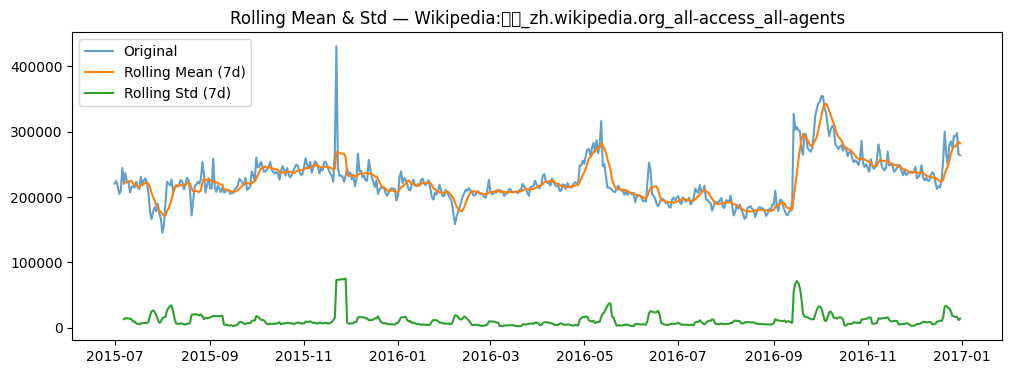

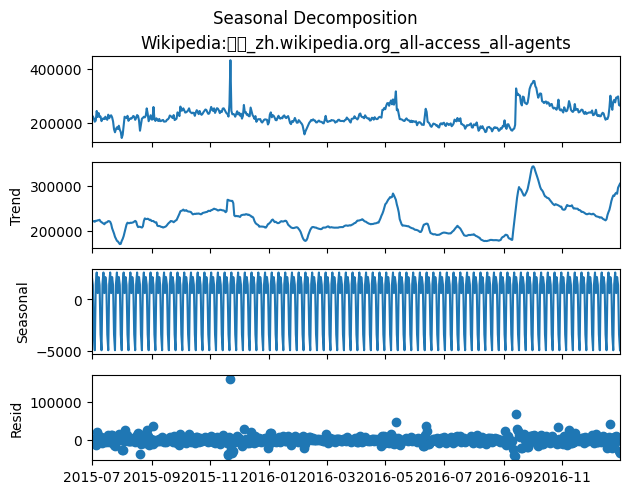

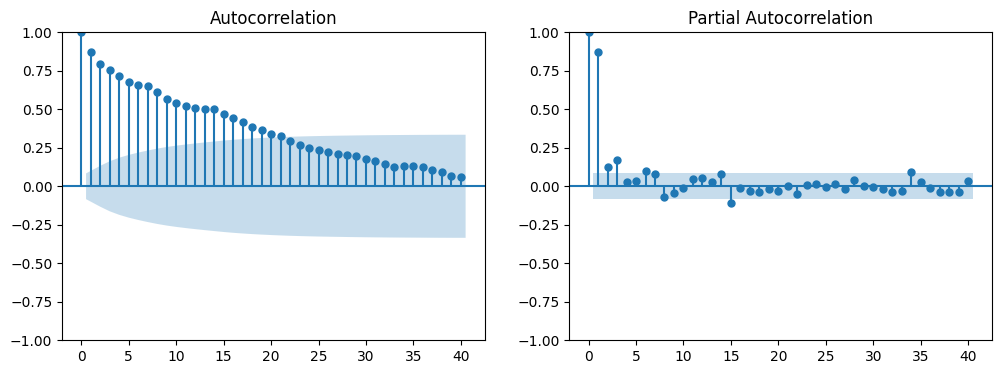


🔹 Analyzing page: Wikipedia:首页_zh.wikipedia.org_desktop_all-agents
ADF Statistic: -2.802 | p-value: 0.0579 | Stationary: False


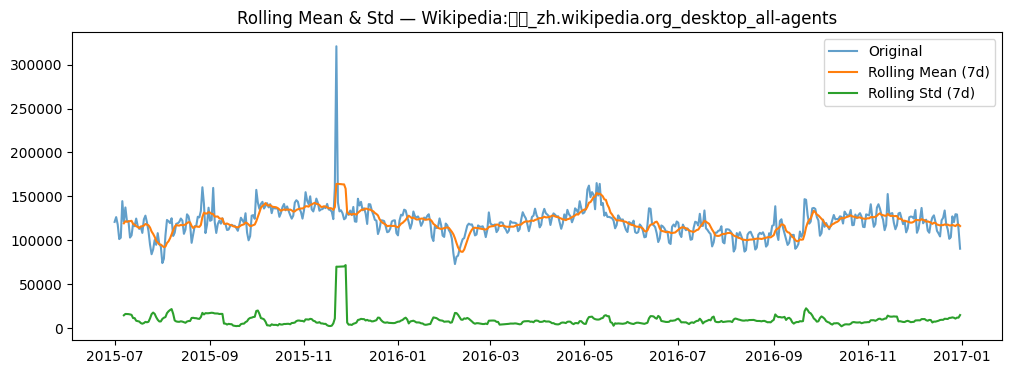

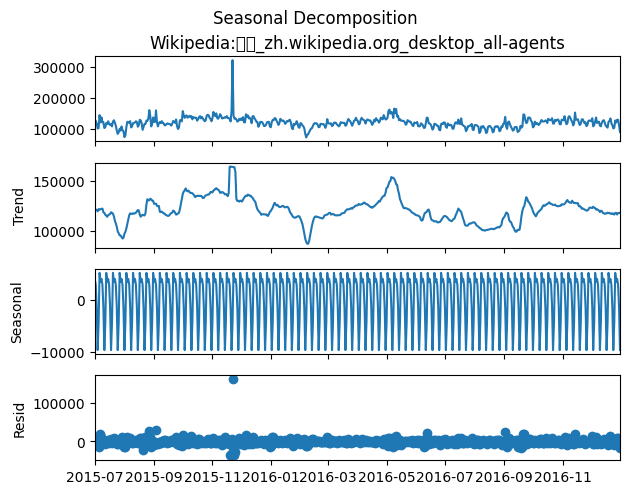

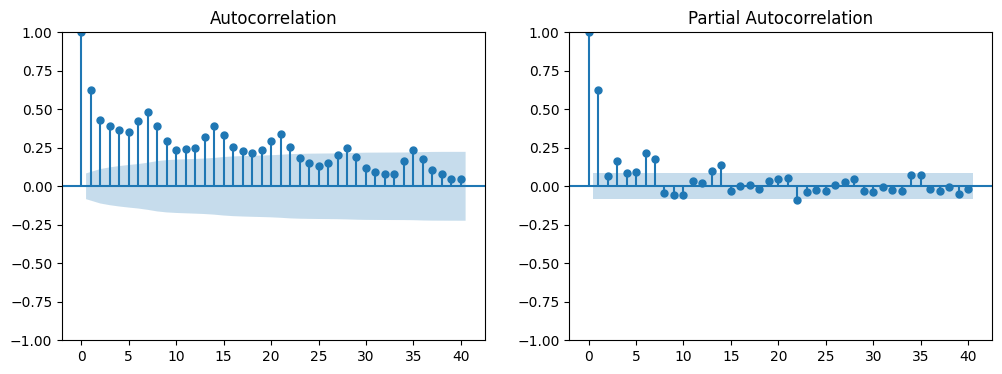


🔹 Analyzing page: Wikipedia:首页_zh.wikipedia.org_mobile-web_all-agents
ADF Statistic: -2.579 | p-value: 0.0974 | Stationary: False


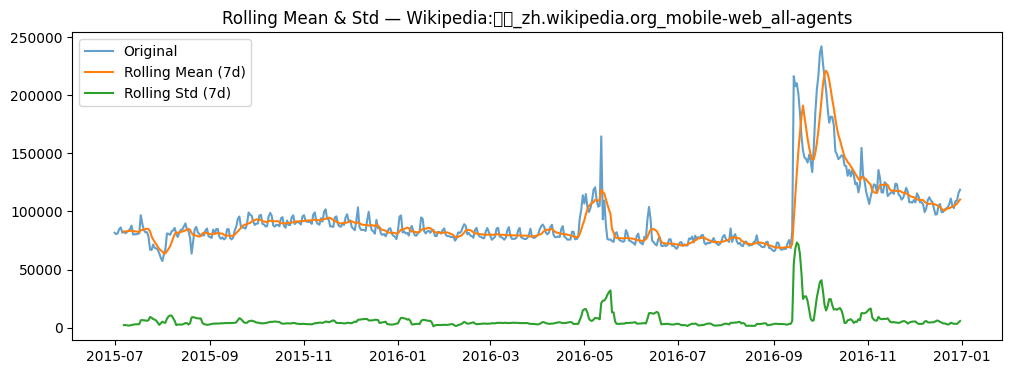

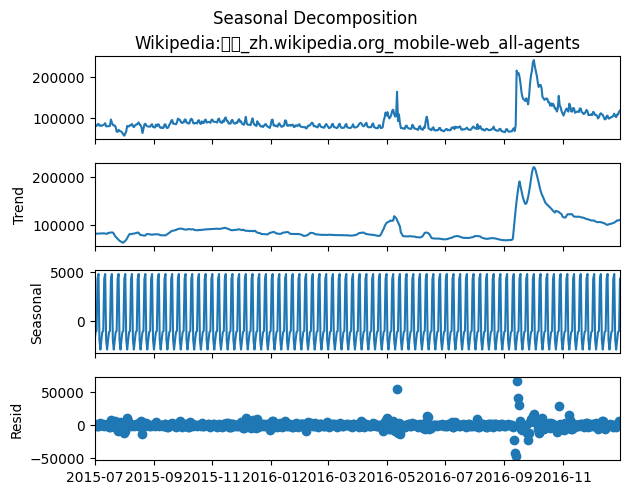

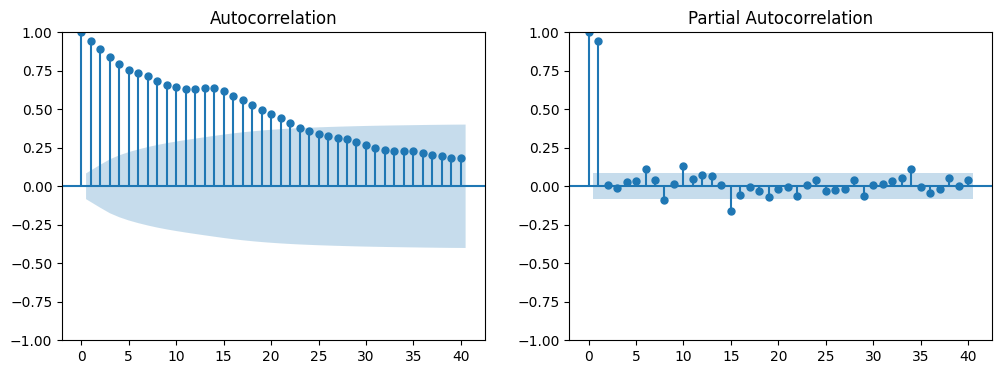


🔹 Analyzing page: 福音戰士新劇場版：Q_zh.wikipedia.org_all-access_all-agents
ADF Statistic: -15.307 | p-value: 0.0000 | Stationary: True


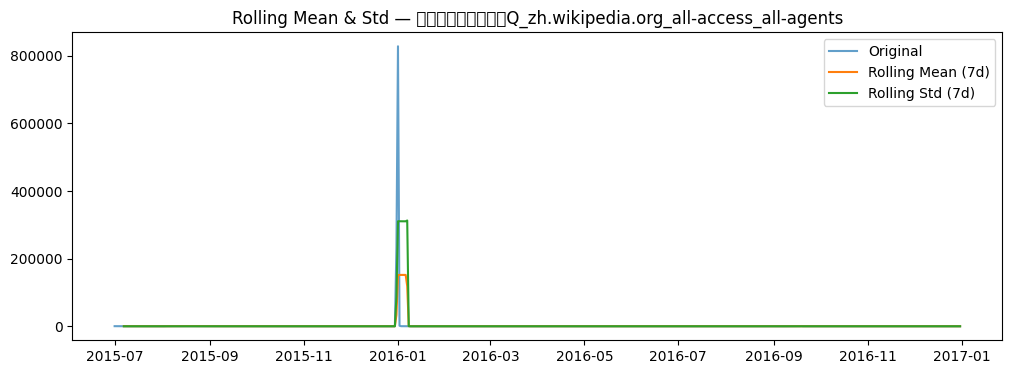

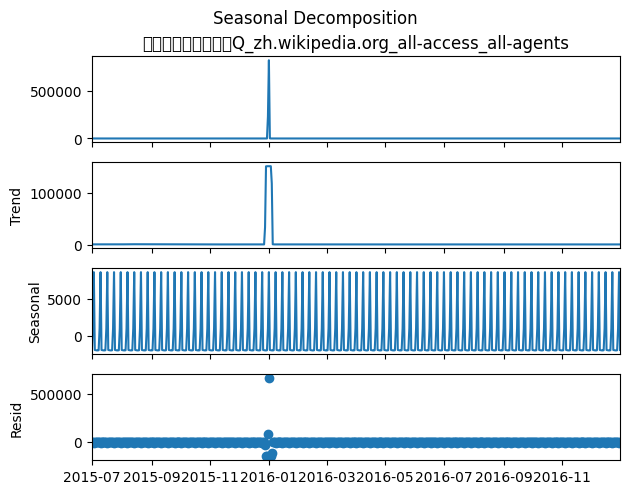

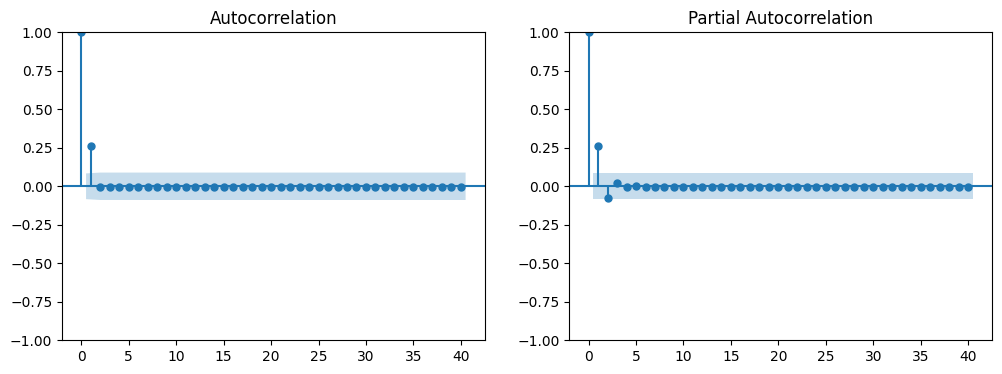


🔹 Analyzing page: 洪晨穎_zh.wikipedia.org_all-access_spider
ADF Statistic: -1.966 | p-value: 0.3019 | Stationary: False


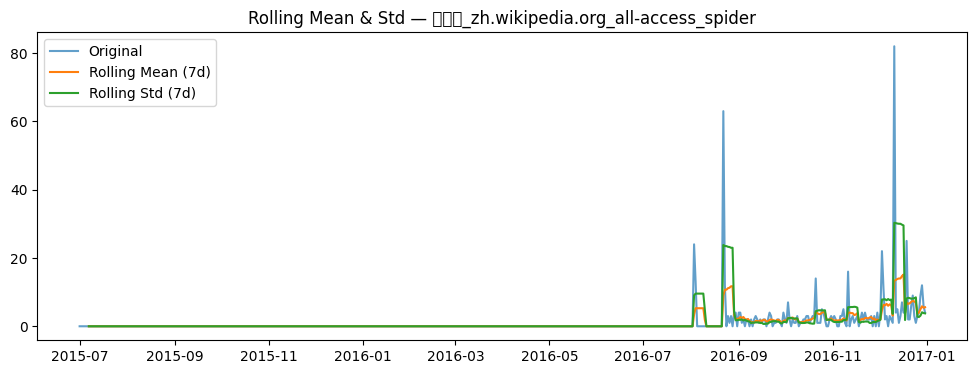

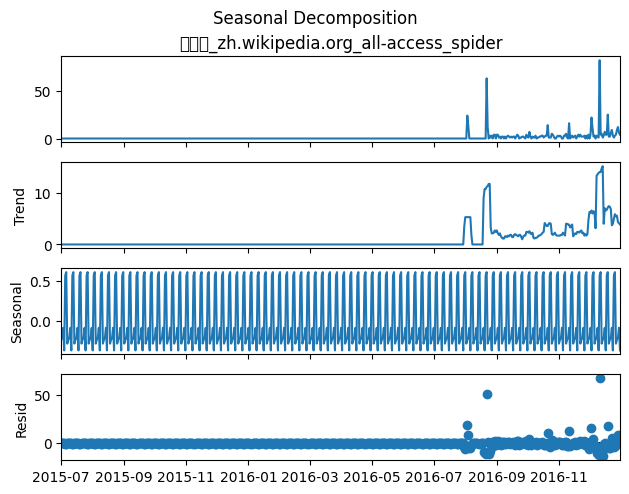

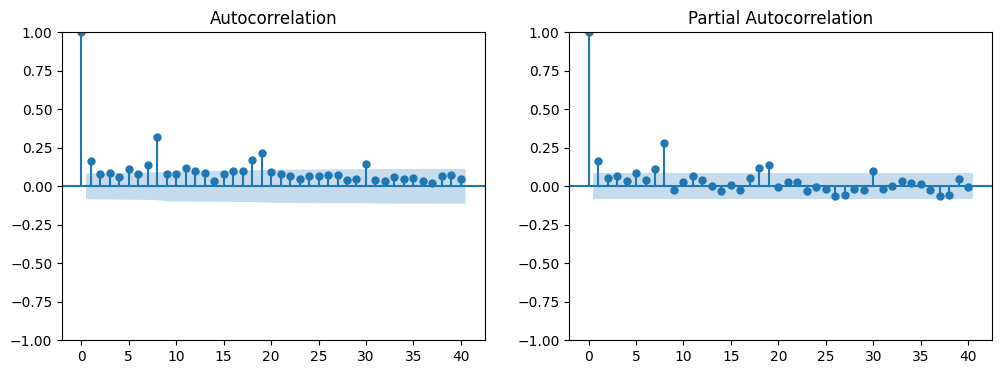


🔹 Analyzing page: Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents
ADF Statistic: -3.557 | p-value: 0.0066 | Stationary: True


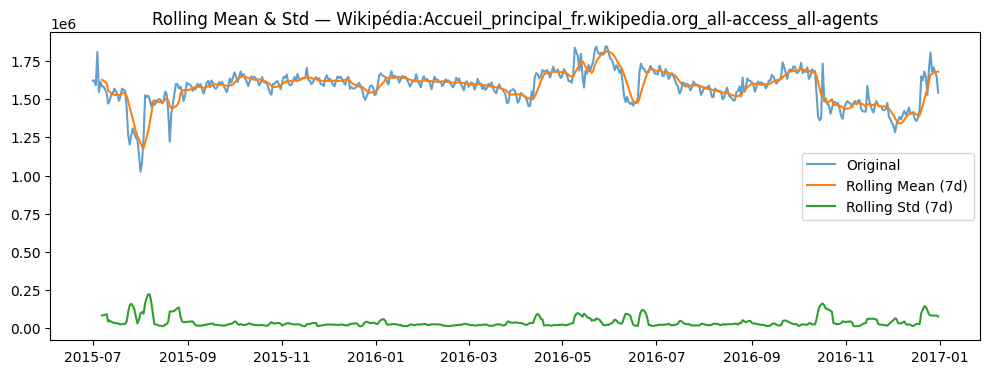

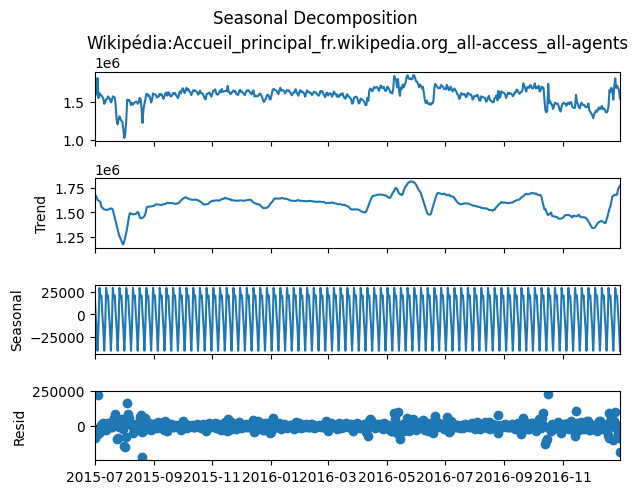

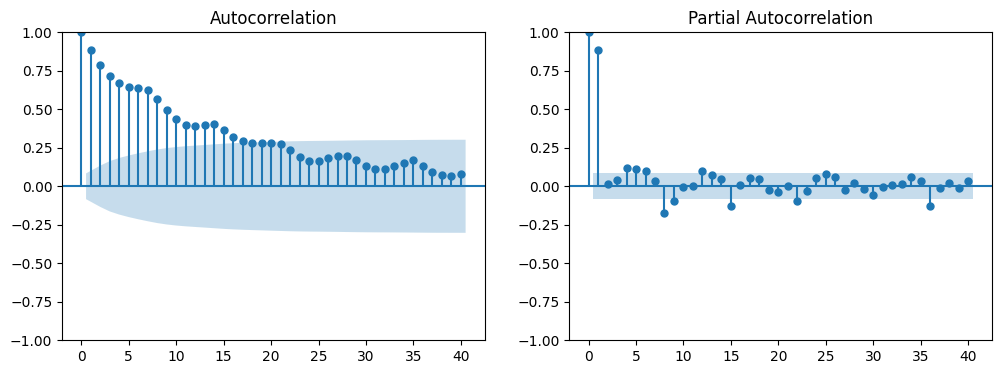


🔹 Analyzing page: Wikipédia:Accueil_principal_fr.wikipedia.org_mobile-web_all-agents
ADF Statistic: 0.336 | p-value: 0.9789 | Stationary: False


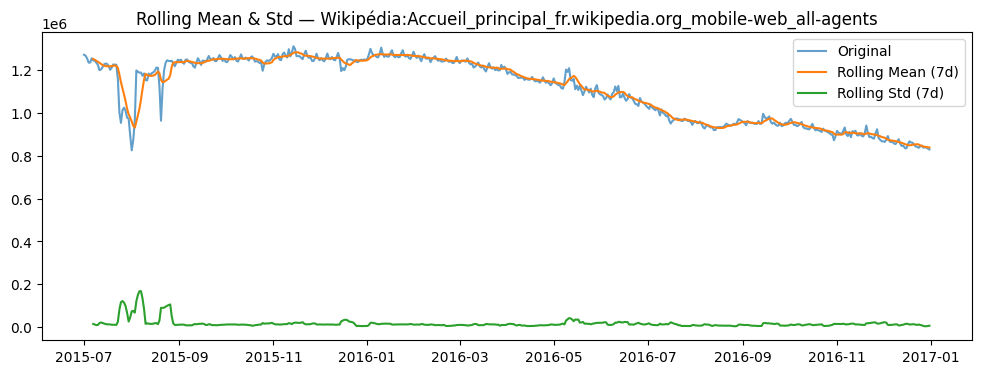

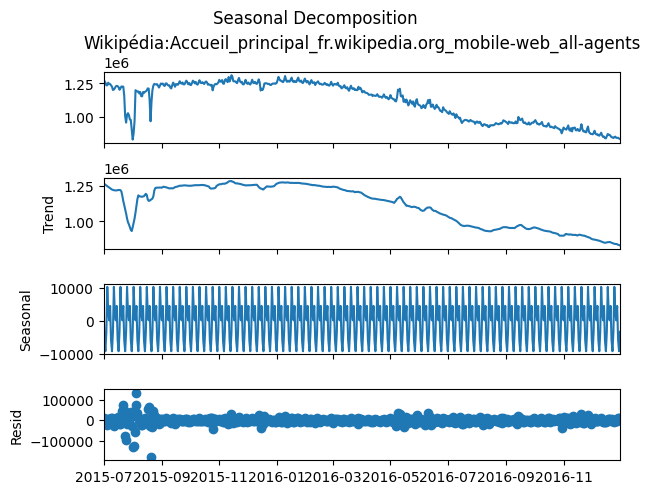

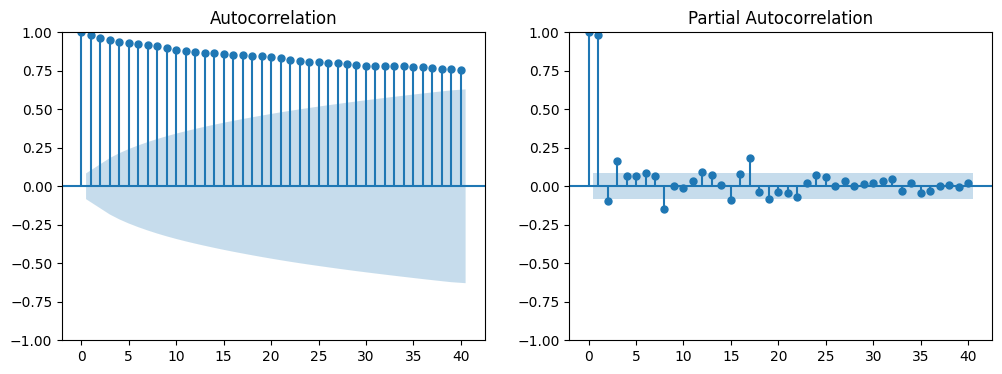


🔹 Analyzing page: Wikipédia:Accueil_principal_fr.wikipedia.org_desktop_all-agents
ADF Statistic: -1.681 | p-value: 0.4409 | Stationary: False


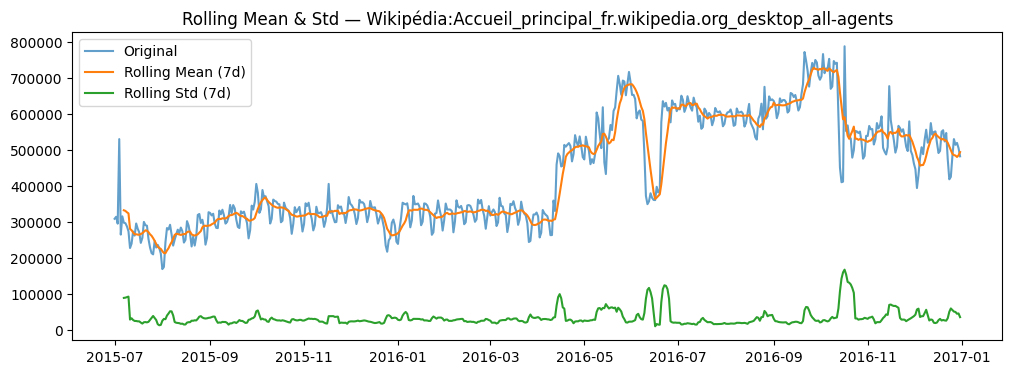

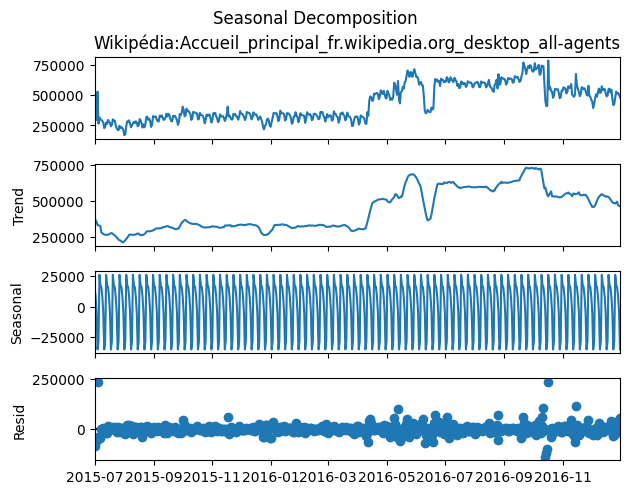

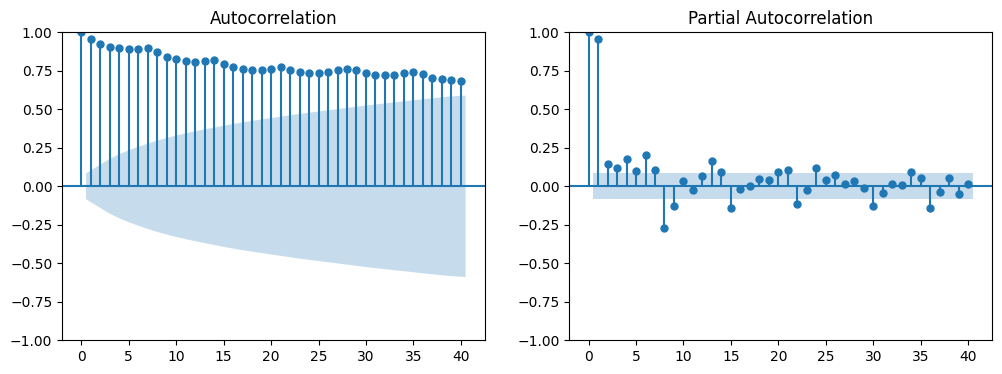


🔹 Analyzing page: Organisme_de_placement_collectif_en_valeurs_mobilières_fr.wikipedia.org_all-access_all-agents
ADF Statistic: -4.409 | p-value: 0.0003 | Stationary: True


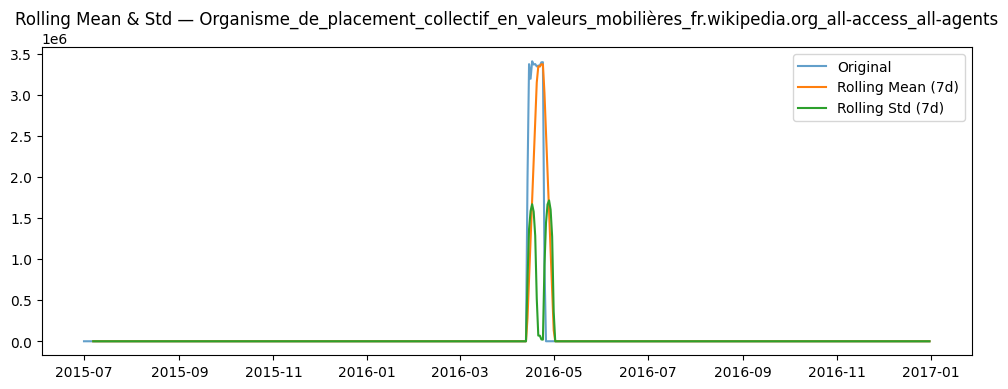

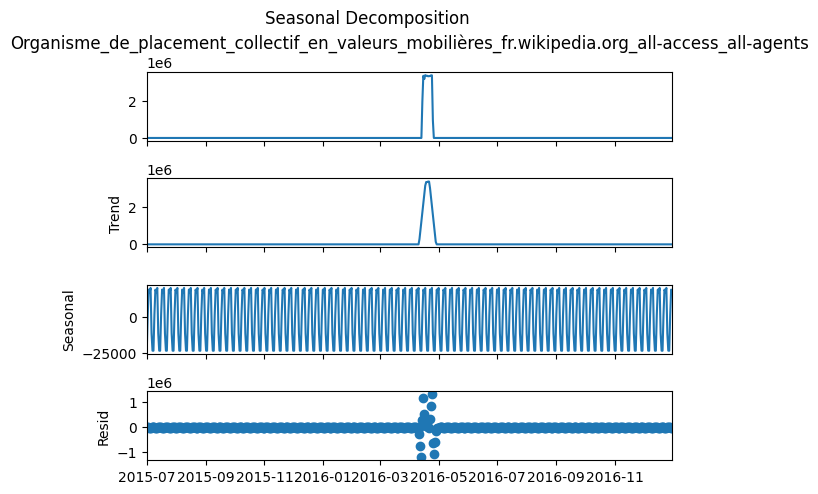

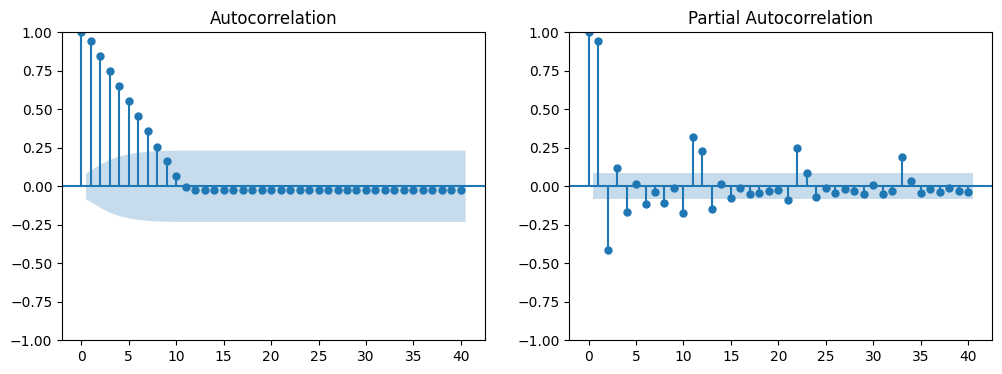


🔹 Analyzing page: Skam_(série_télévisée)_fr.wikipedia.org_all-access_spider
ADF Statistic: -0.369 | p-value: 0.9152 | Stationary: False


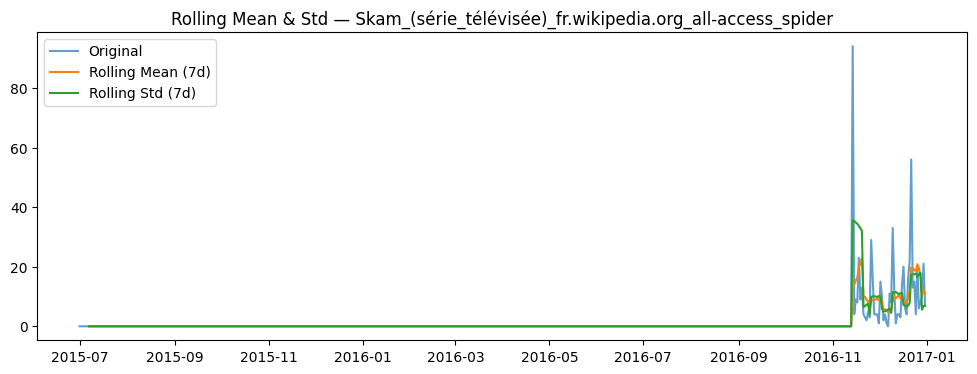

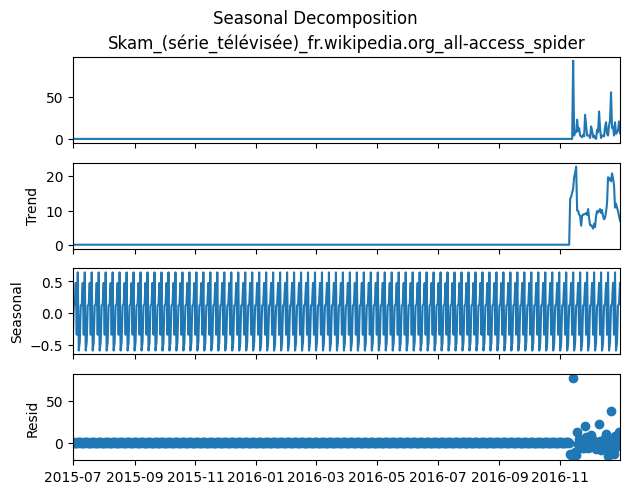

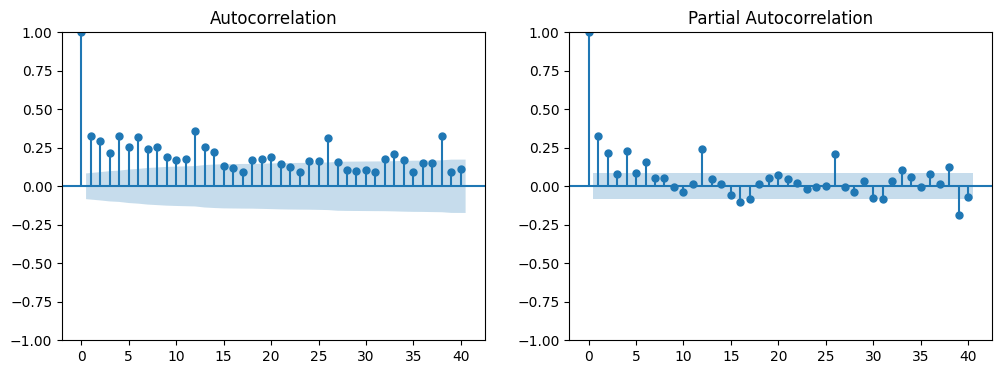


🔹 Analyzing page: Main_Page_en.wikipedia.org_all-access_all-agents
ADF Statistic: -2.990 | p-value: 0.0358 | Stationary: True


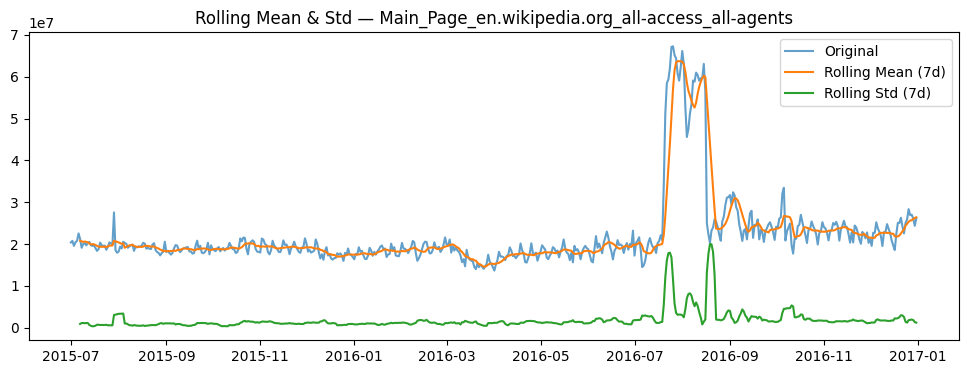

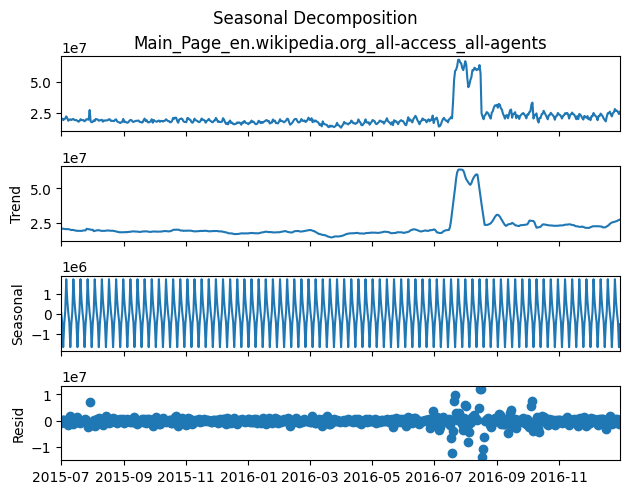

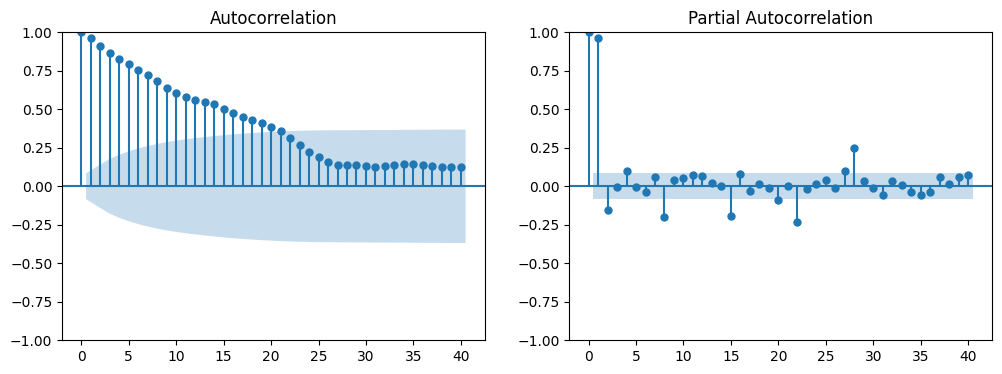


🔹 Analyzing page: Main_Page_en.wikipedia.org_desktop_all-agents
ADF Statistic: -2.815 | p-value: 0.0562 | Stationary: False


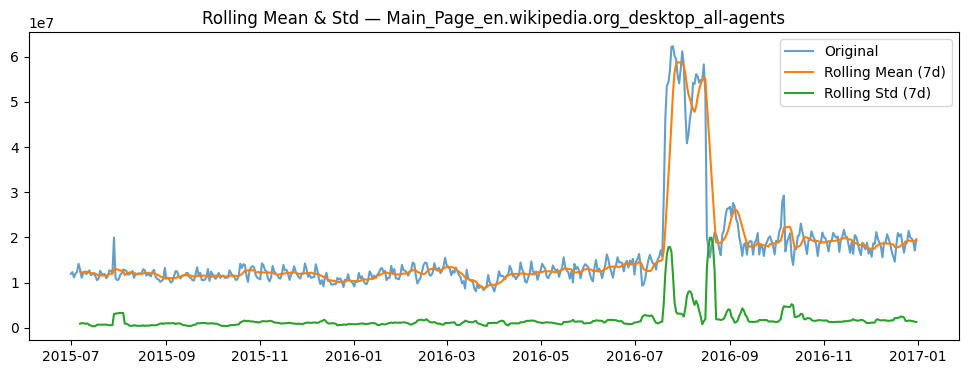

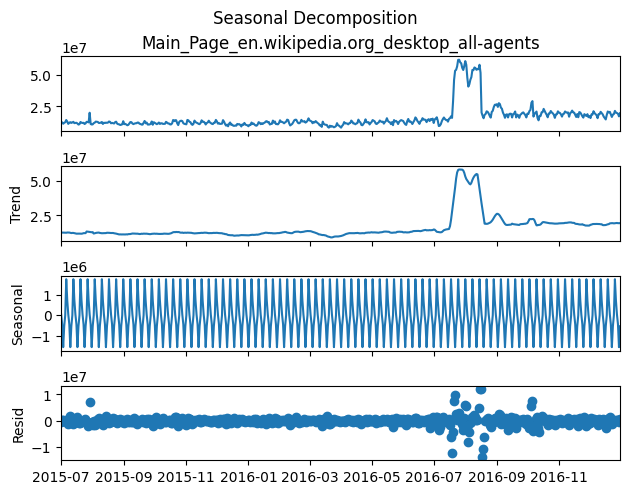

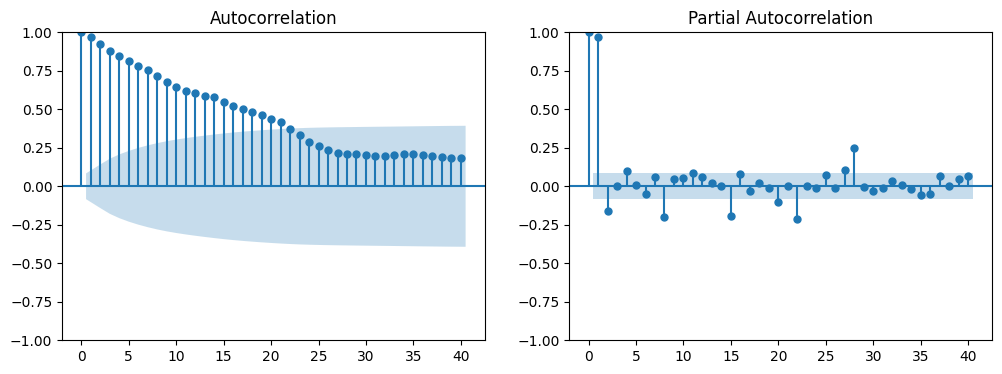


🔹 Analyzing page: Main_Page_en.wikipedia.org_mobile-web_all-agents
ADF Statistic: -1.117 | p-value: 0.7082 | Stationary: False


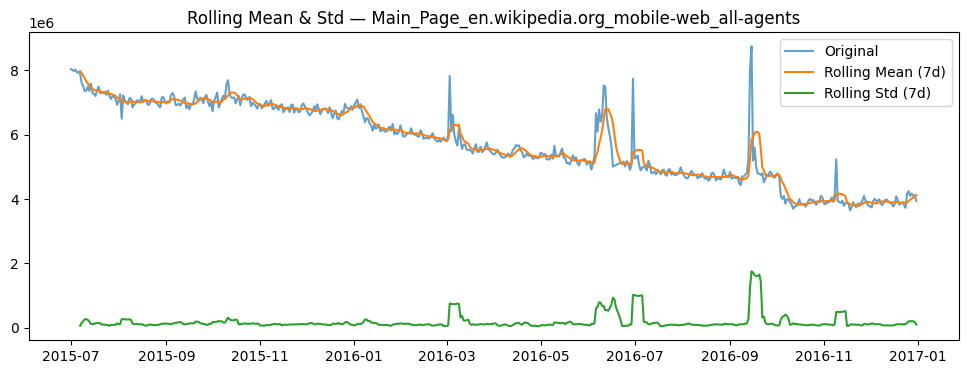

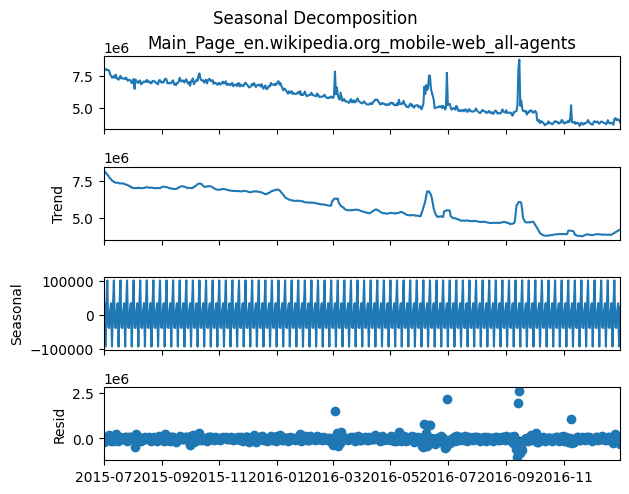

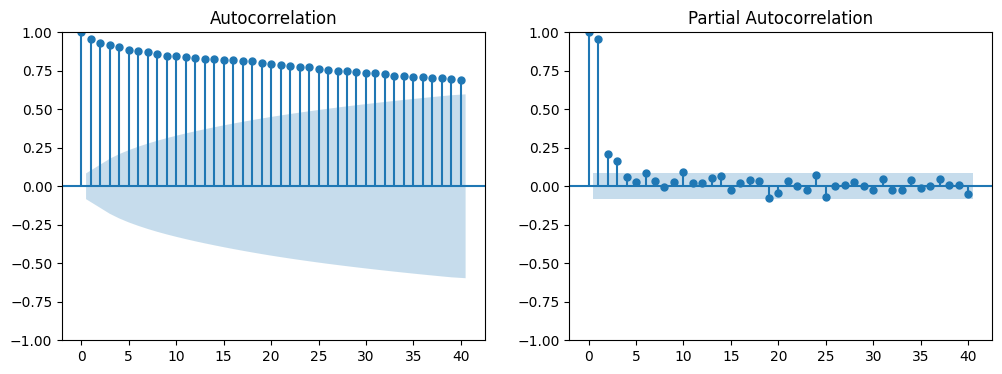


🔹 Analyzing page: Adelisa_Grabus_en.wikipedia.org_all-access_all-agents
ADF Statistic: -2.112 | p-value: 0.2398 | Stationary: False


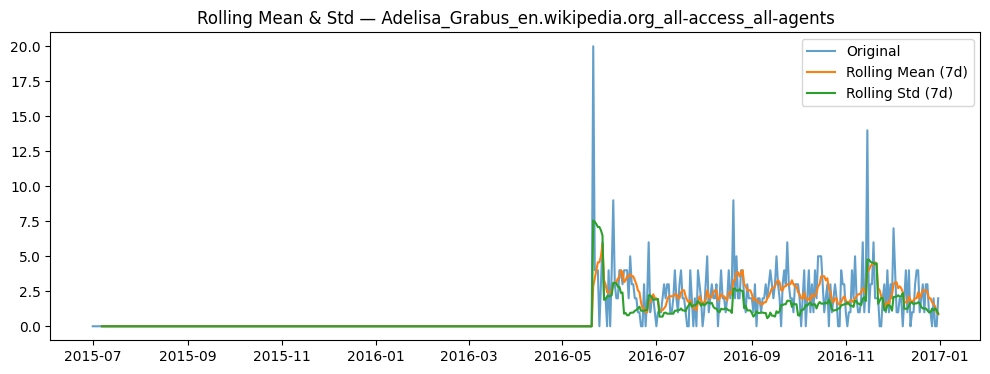

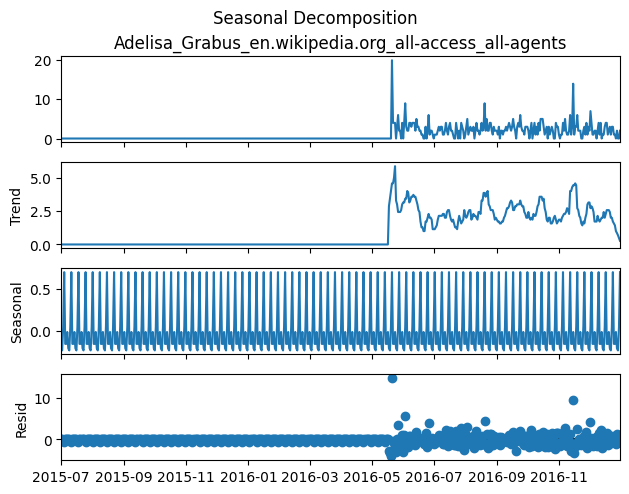

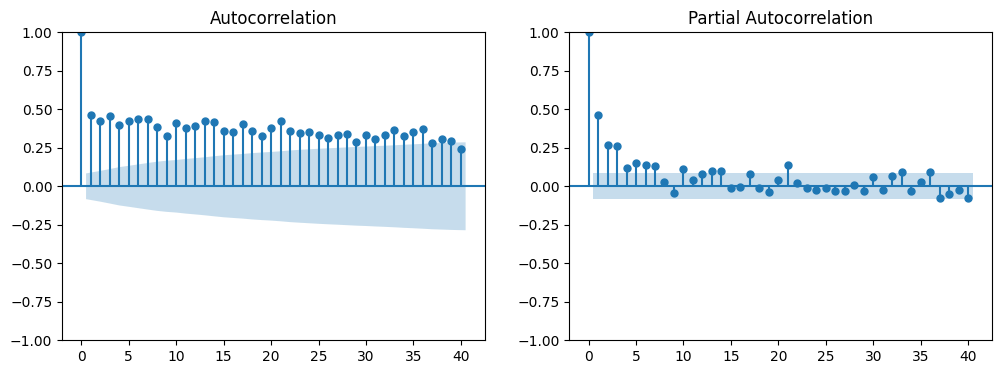


🔹 Analyzing page: Special:Search_commons.wikimedia.org_all-access_all-agents
ADF Statistic: -2.972 | p-value: 0.0376 | Stationary: True


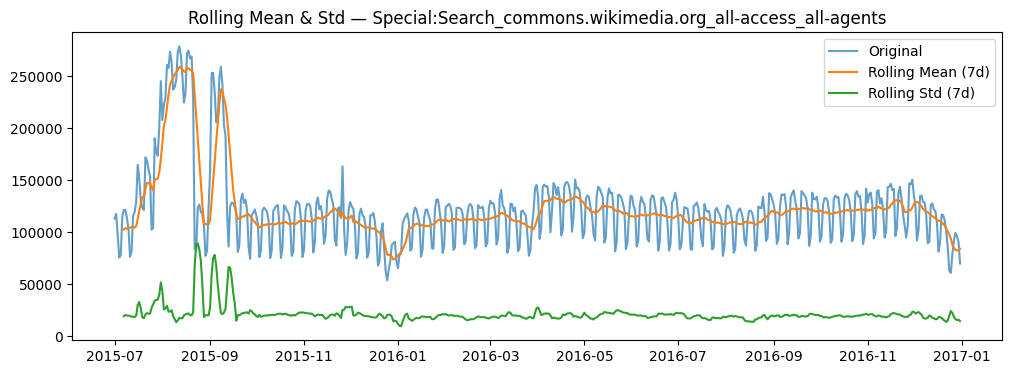

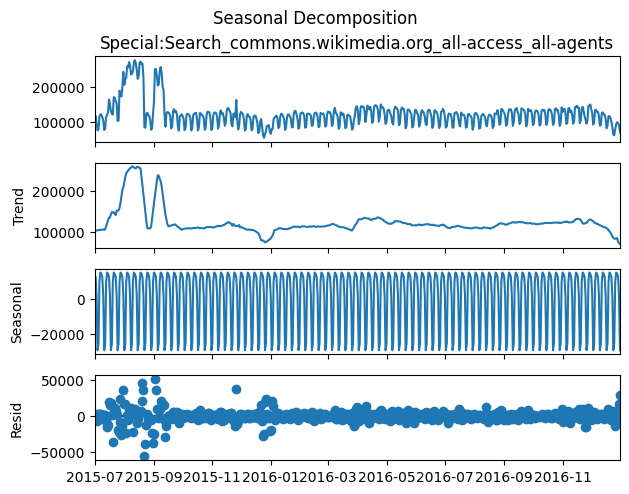

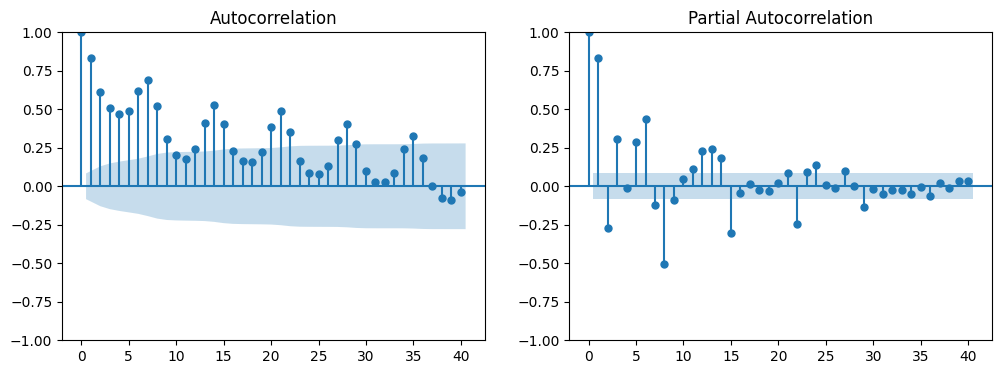


🔹 Analyzing page: Special:Search_commons.wikimedia.org_desktop_all-agents
ADF Statistic: -2.871 | p-value: 0.0488 | Stationary: True


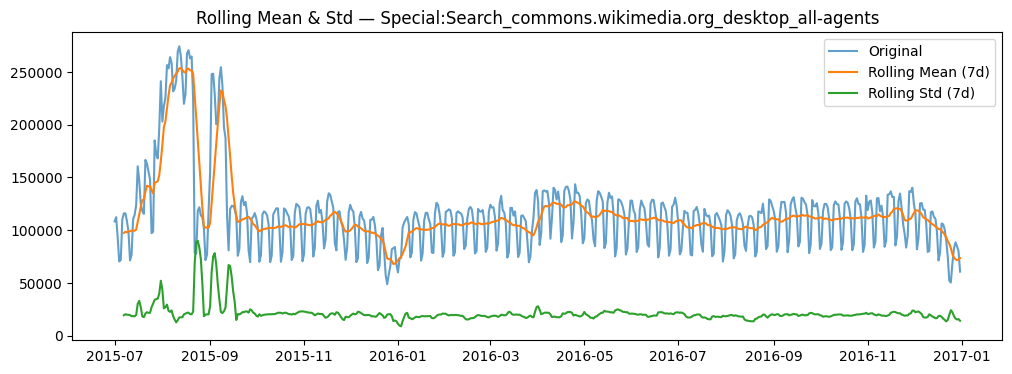

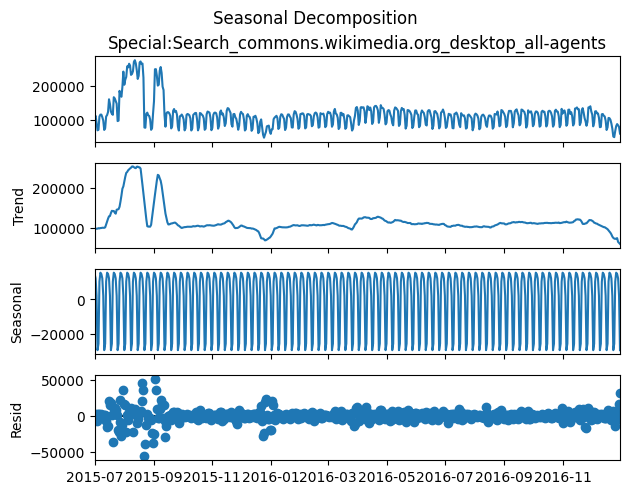

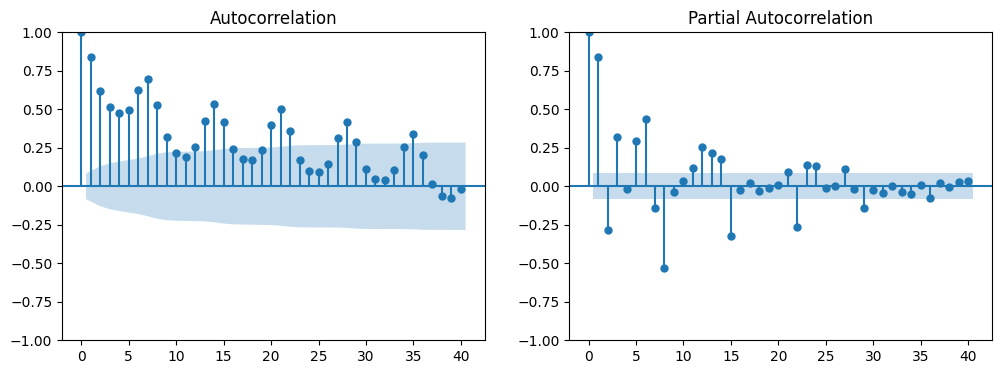


🔹 Analyzing page: Special:CreateAccount_commons.wikimedia.org_all-access_all-agents
ADF Statistic: -2.113 | p-value: 0.2393 | Stationary: False


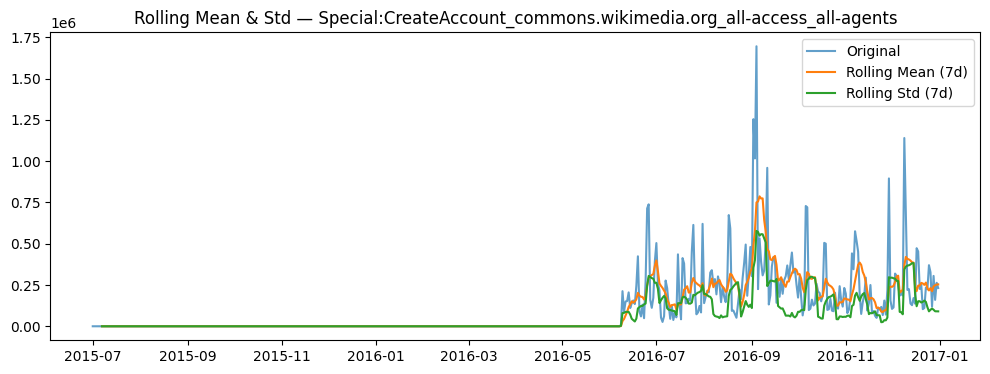

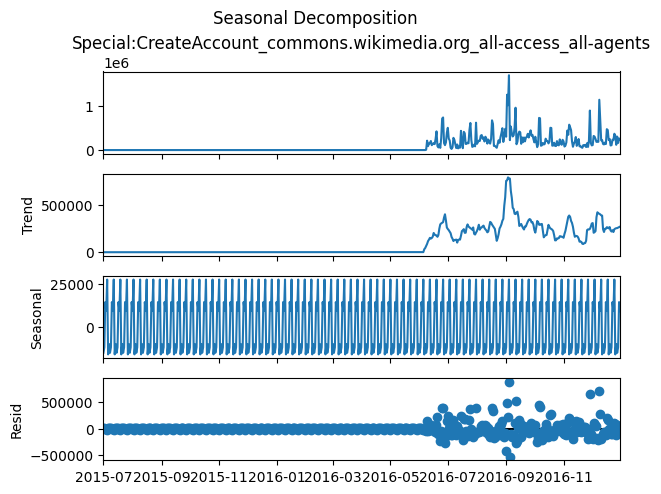

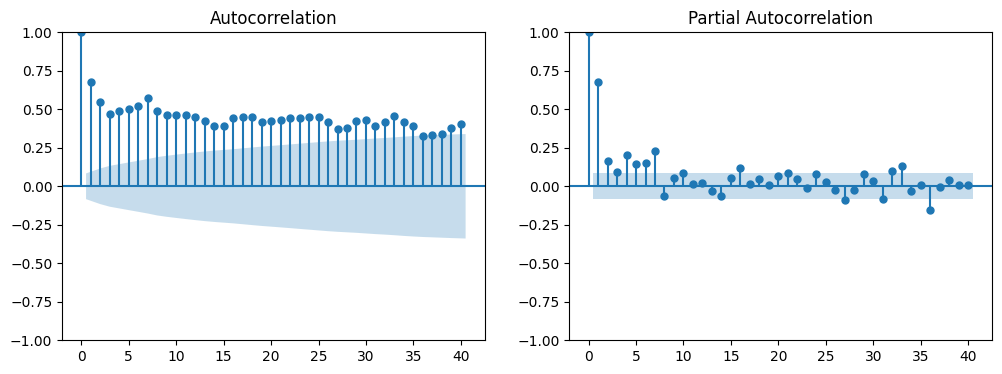


🔹 Analyzing page: File:Autofellatio_standing.jpg_commons.wikimedia.org_all-access_spider
ADF Statistic: -5.467 | p-value: 0.0000 | Stationary: True


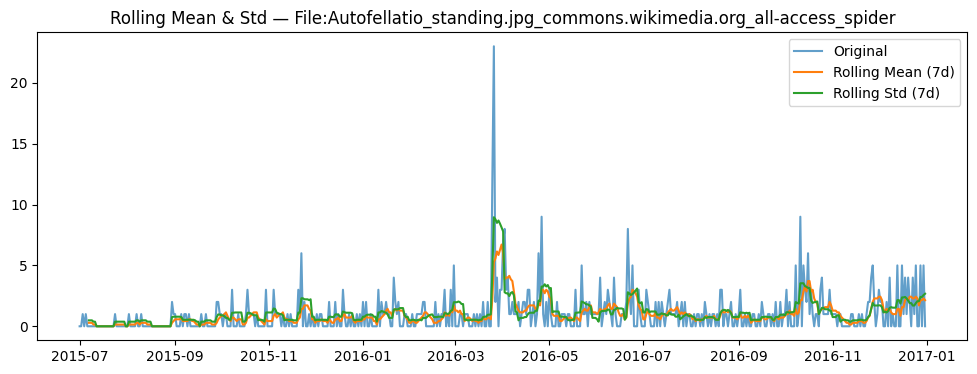

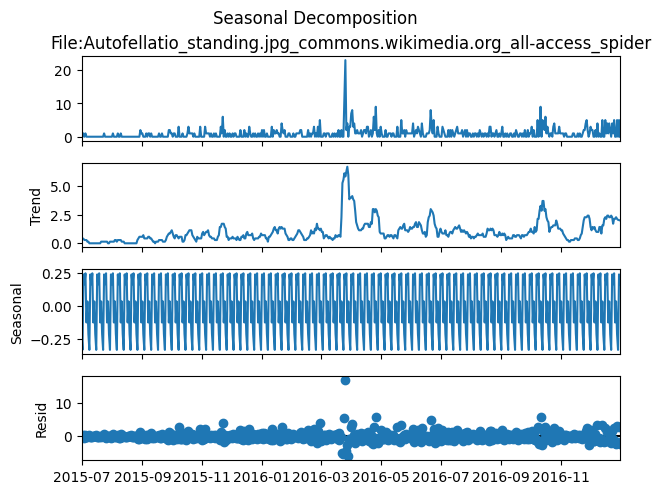

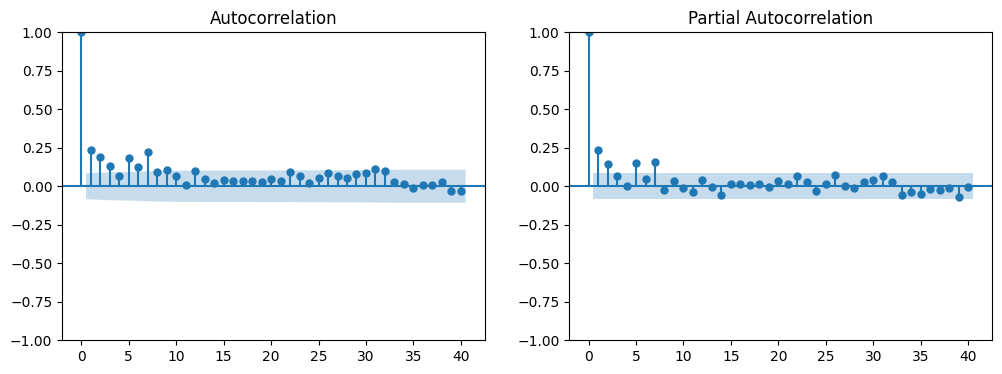


🔹 Analyzing page: Заглавная_страница_ru.wikipedia.org_all-access_all-agents
ADF Statistic: -4.128 | p-value: 0.0009 | Stationary: True


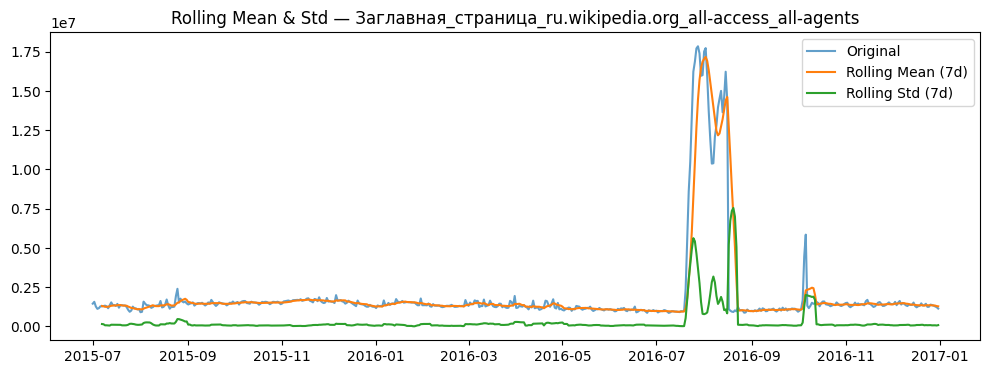

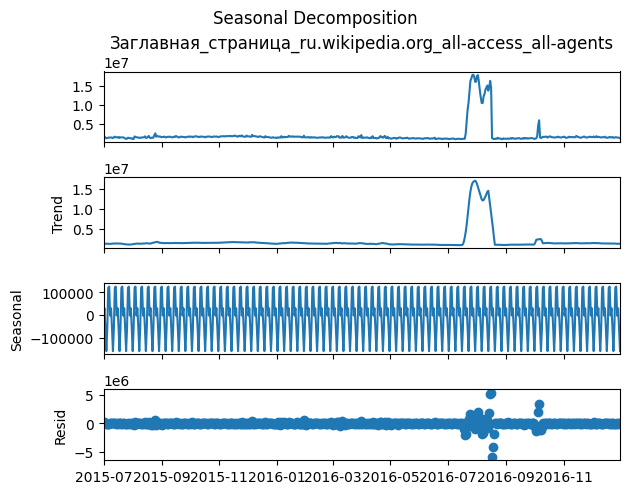

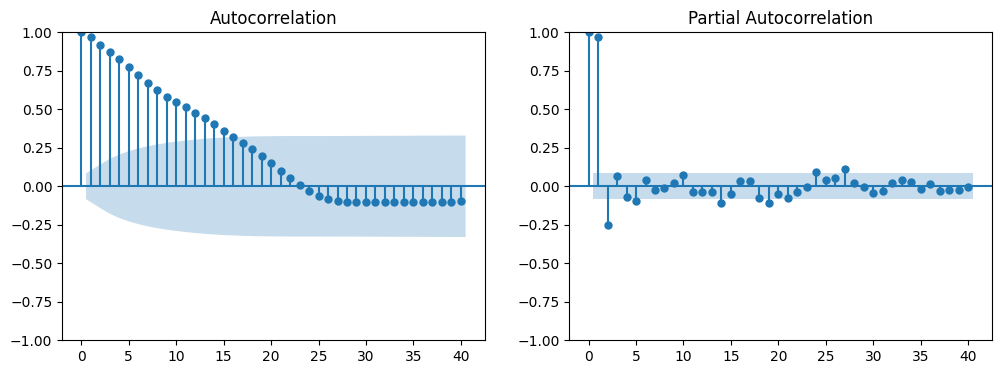


🔹 Analyzing page: Заглавная_страница_ru.wikipedia.org_desktop_all-agents
ADF Statistic: -4.095 | p-value: 0.0010 | Stationary: True


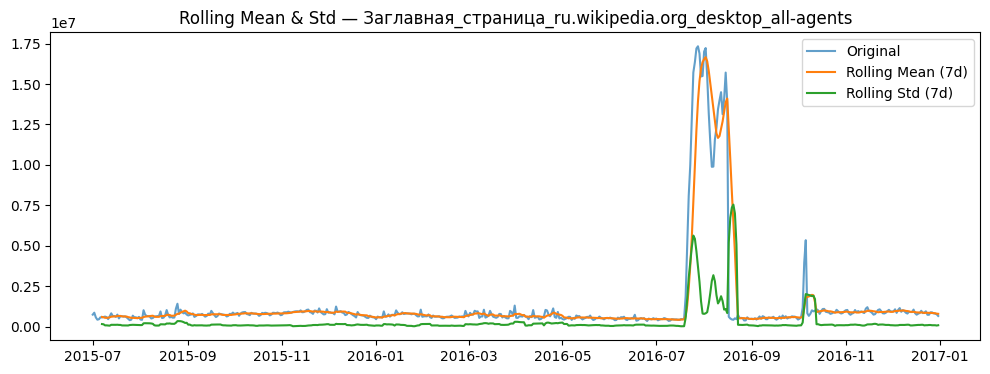

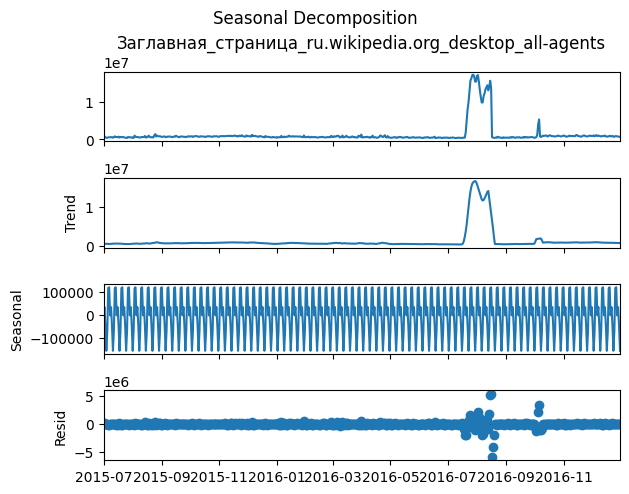

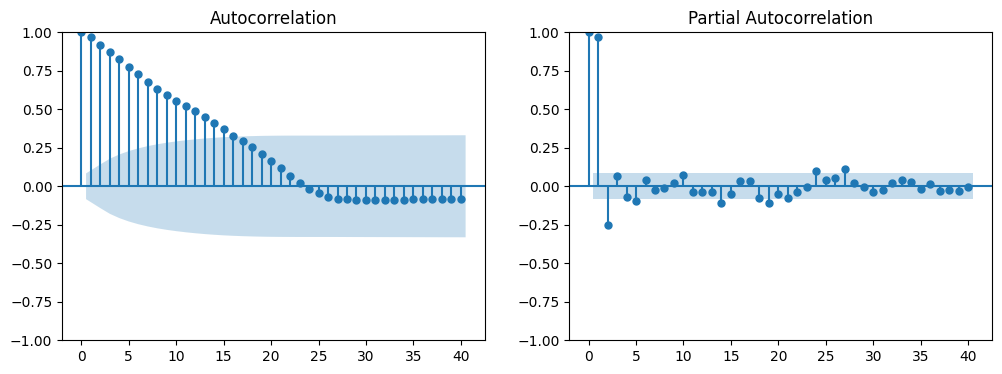


🔹 Analyzing page: Заглавная_страница_ru.wikipedia.org_mobile-web_all-agents
ADF Statistic: -0.163 | p-value: 0.9428 | Stationary: False


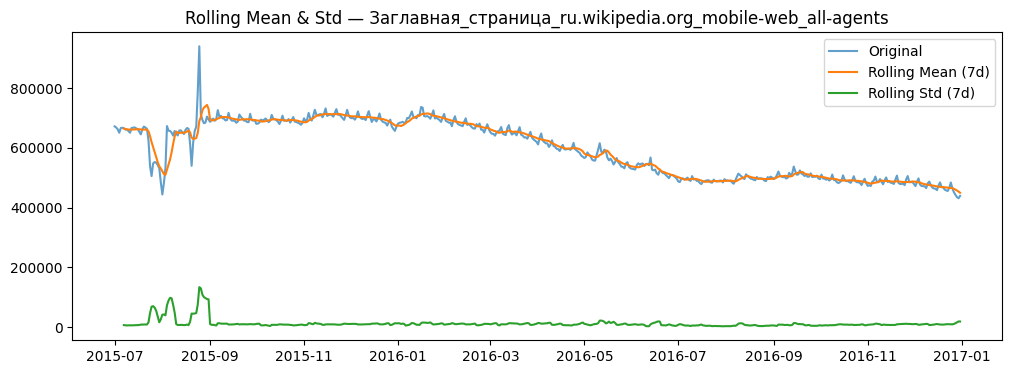

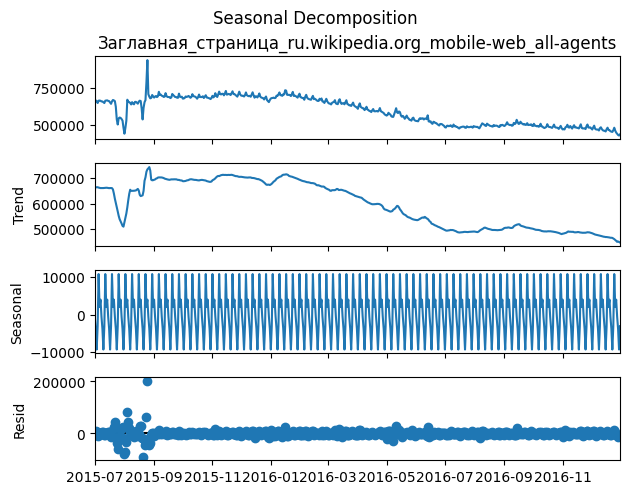

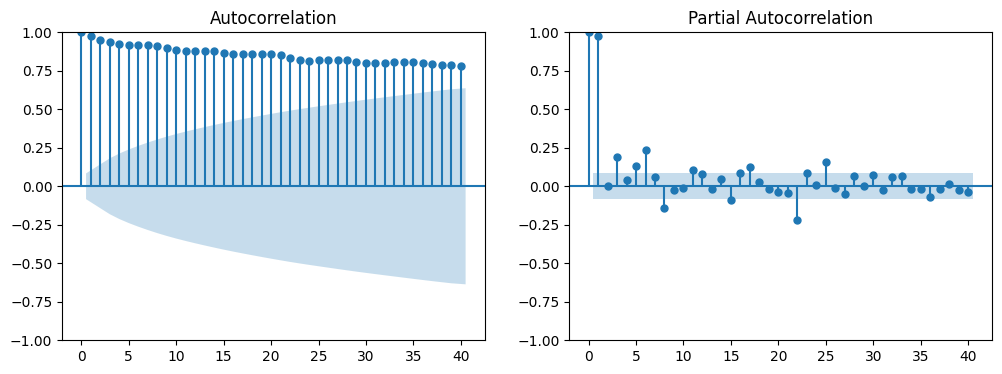


🔹 Analyzing page: Рождественский_сочельник_ru.wikipedia.org_all-access_spider
ADF Statistic: -6.169 | p-value: 0.0000 | Stationary: True


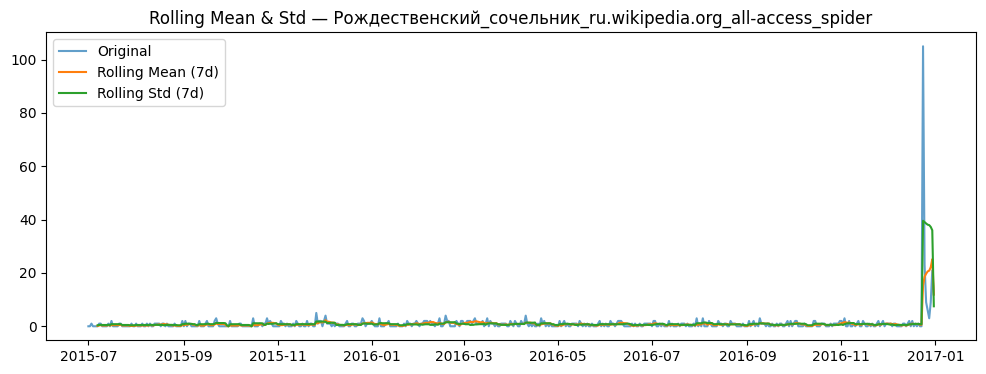

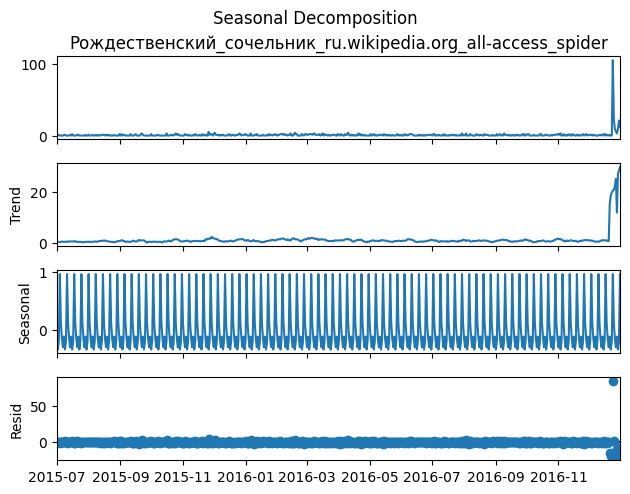

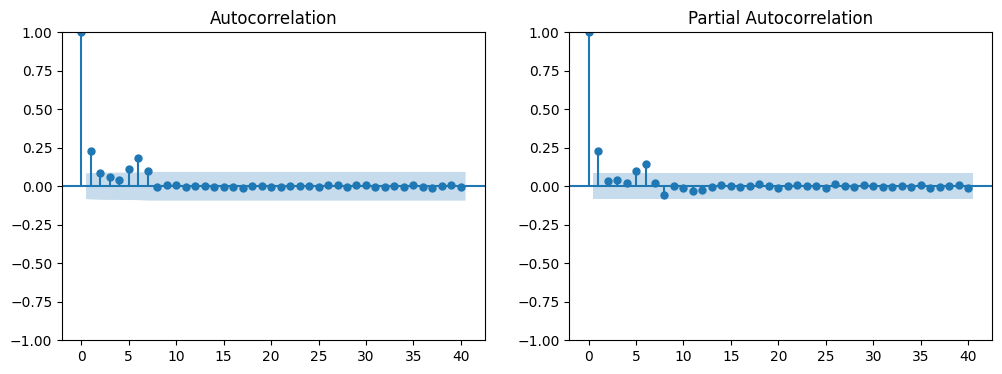


🔹 Analyzing page: MediaWiki_www.mediawiki.org_all-access_all-agents
ADF Statistic: -11.068 | p-value: 0.0000 | Stationary: True


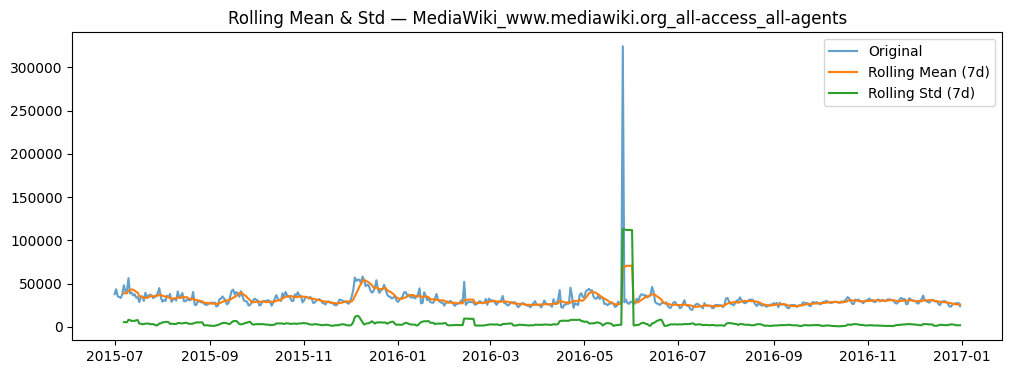

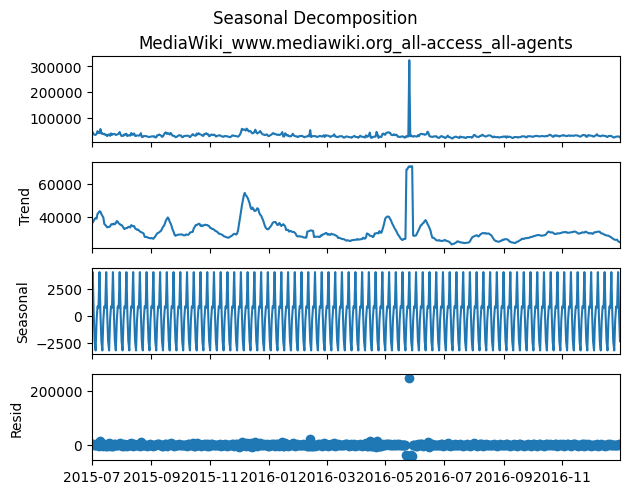

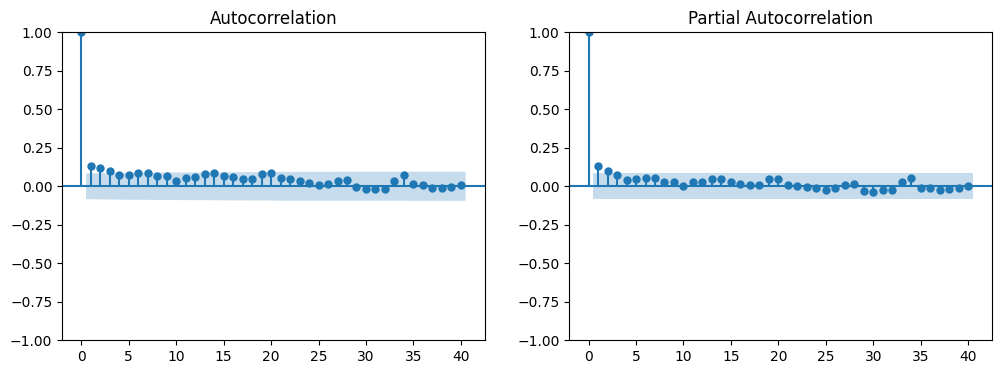


🔹 Analyzing page: MediaWiki_www.mediawiki.org_desktop_all-agents
ADF Statistic: -14.194 | p-value: 0.0000 | Stationary: True


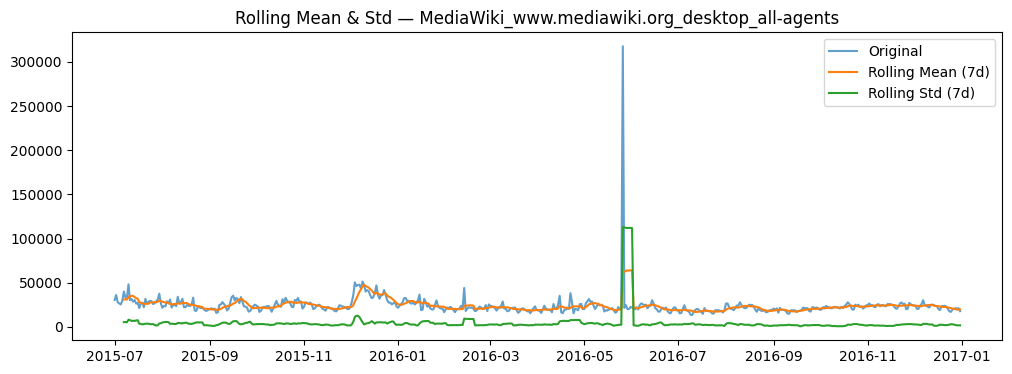

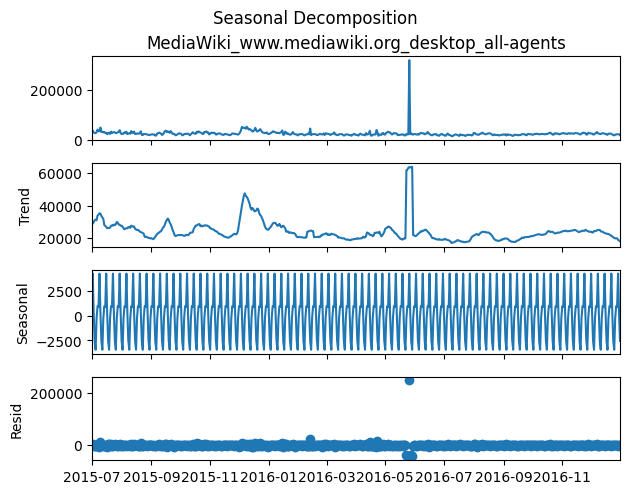

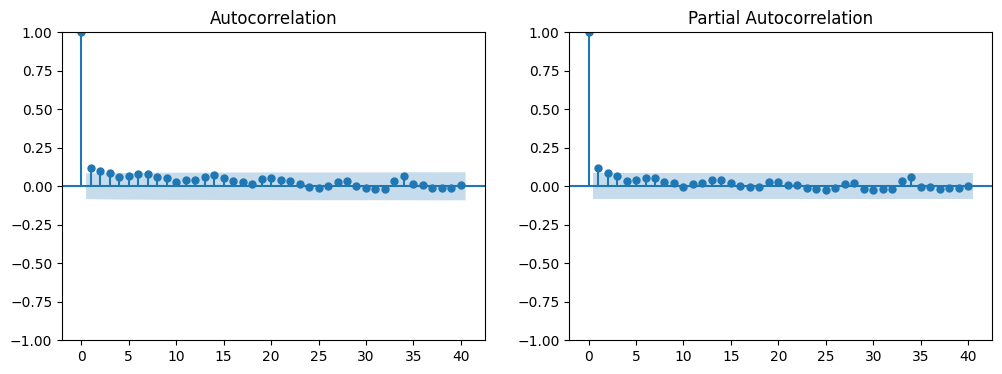


🔹 Analyzing page: Parsoid/Developer_Setup_www.mediawiki.org_all-access_all-agents
ADF Statistic: -5.157 | p-value: 0.0000 | Stationary: True


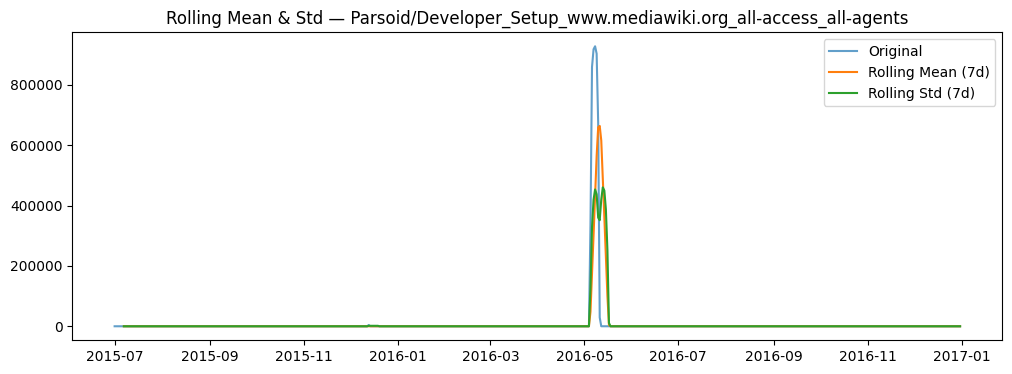

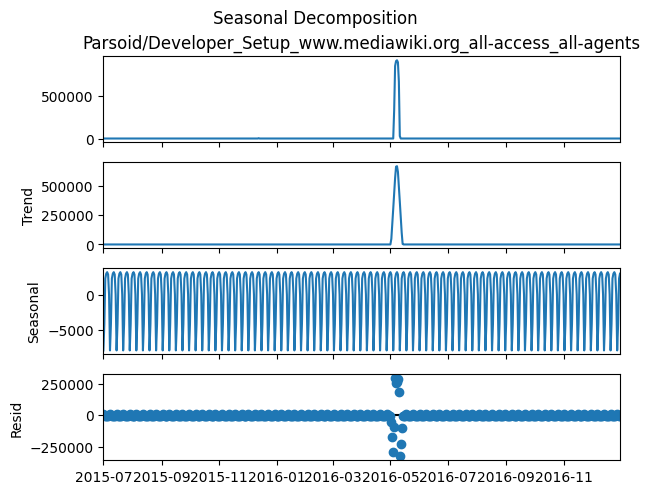

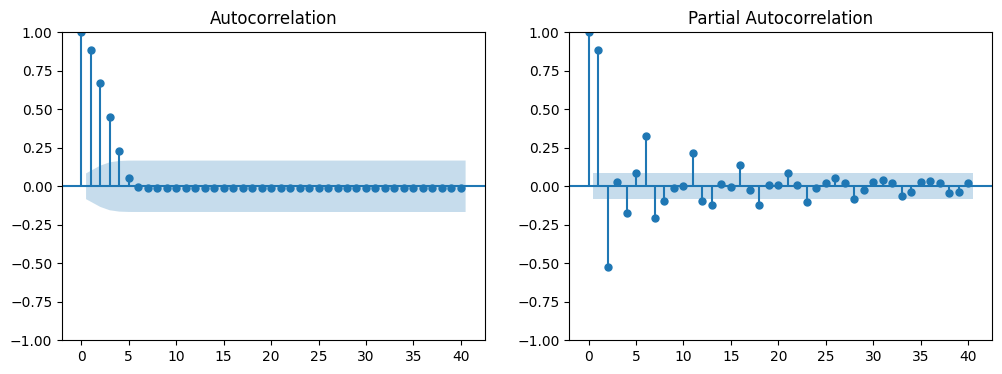


🔹 Analyzing page: Wikimedia_Engineering/Introducing_Victoria_Coleman_-_Chief_Technology_Officer_www.mediawiki.org_all-access_spider
ADF Statistic: -1.793 | p-value: 0.3841 | Stationary: False


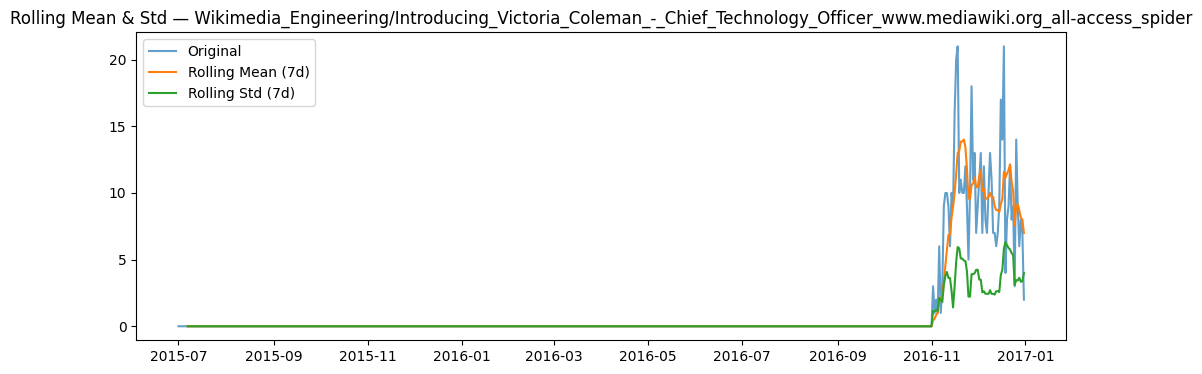

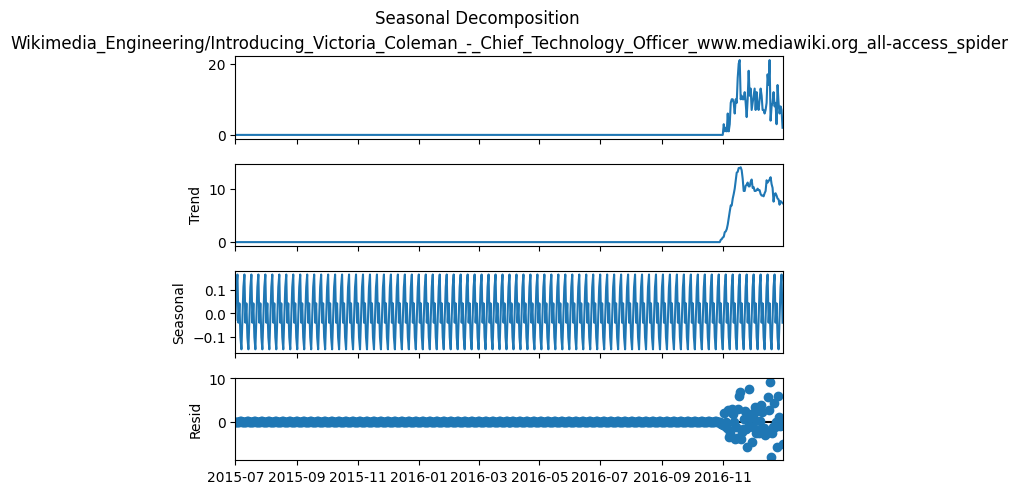

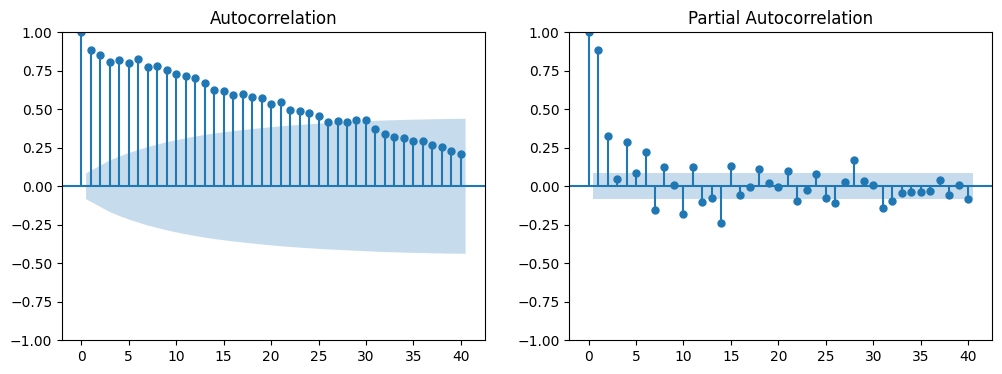


🔹 Analyzing page: Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents
ADF Statistic: -1.520 | p-value: 0.5236 | Stationary: False


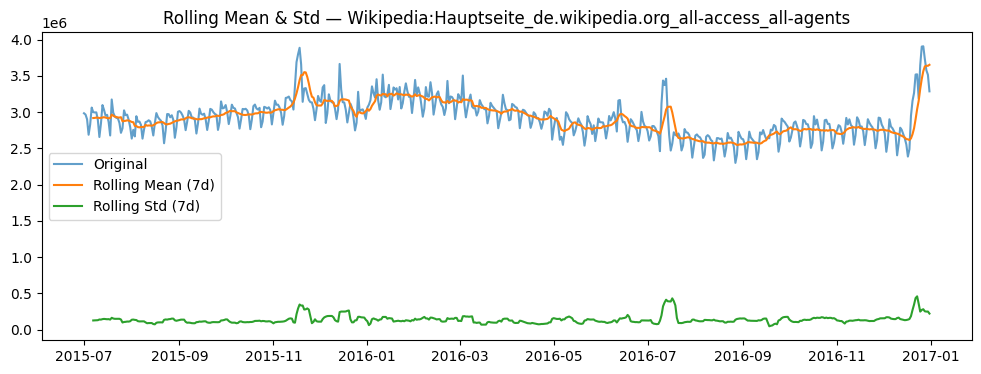

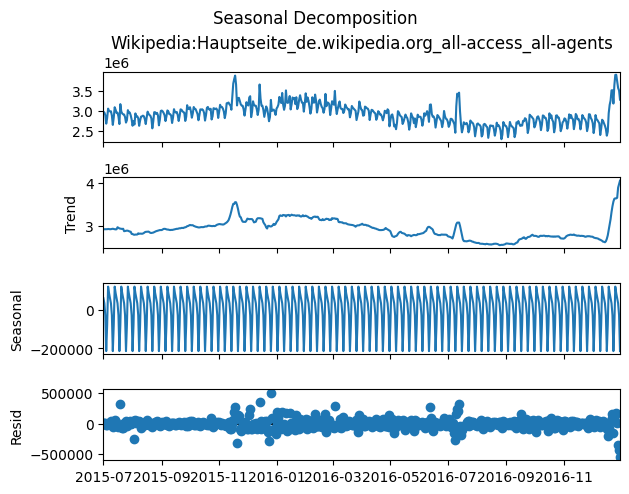

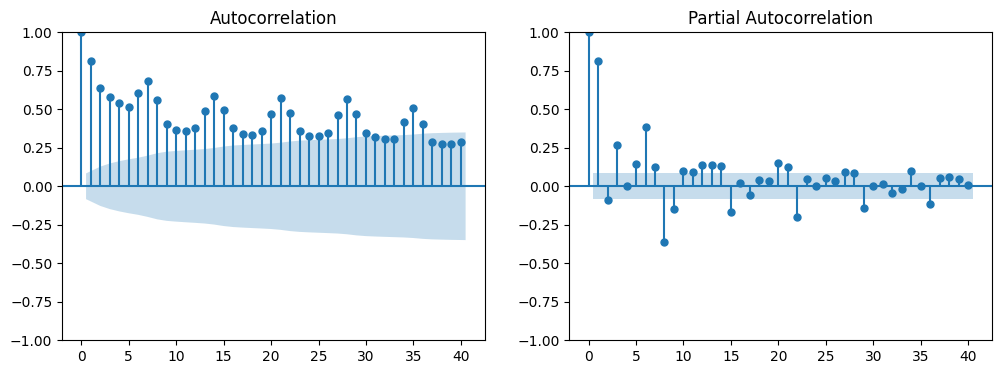


🔹 Analyzing page: Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents
ADF Statistic: 0.316 | p-value: 0.9781 | Stationary: False


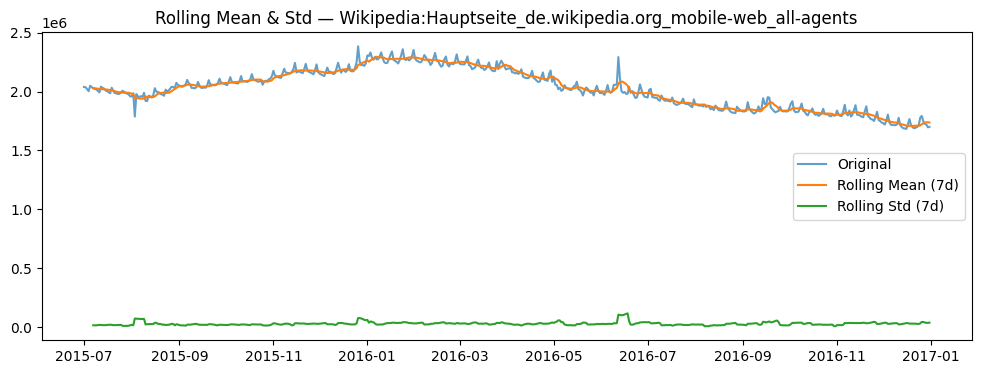

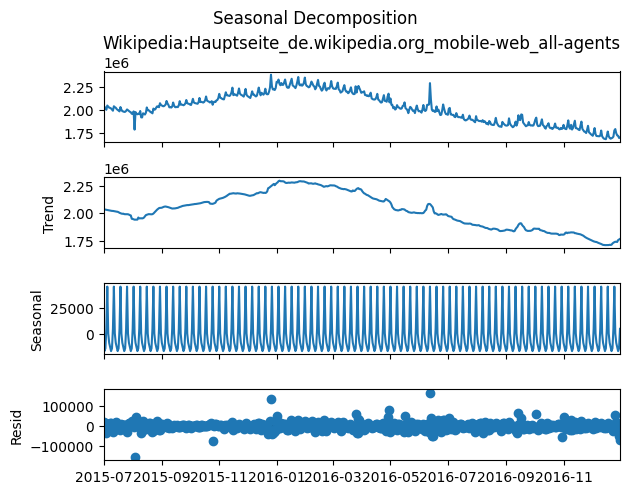

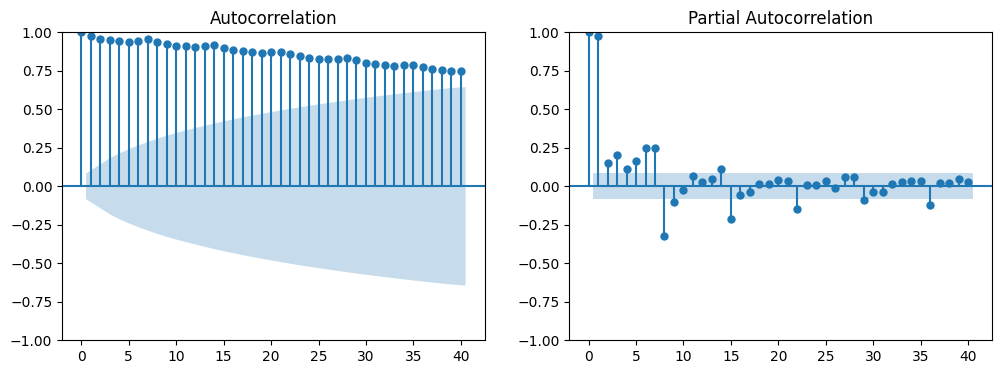


🔹 Analyzing page: Wikipedia:Hauptseite_de.wikipedia.org_desktop_all-agents
ADF Statistic: -2.900 | p-value: 0.0453 | Stationary: True


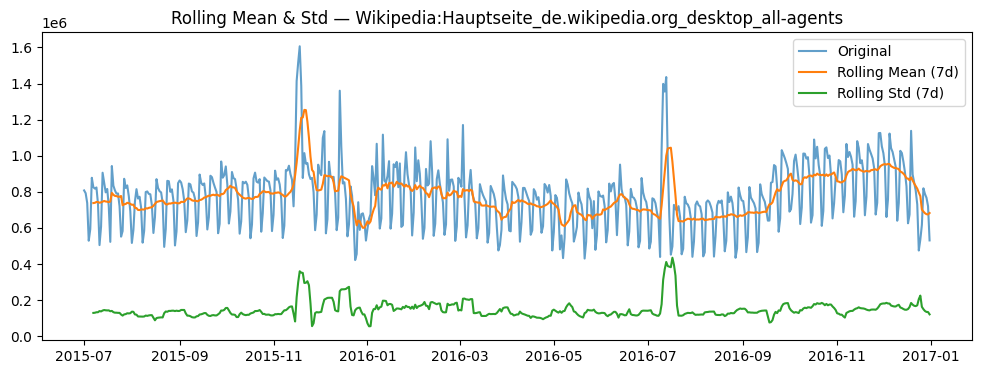

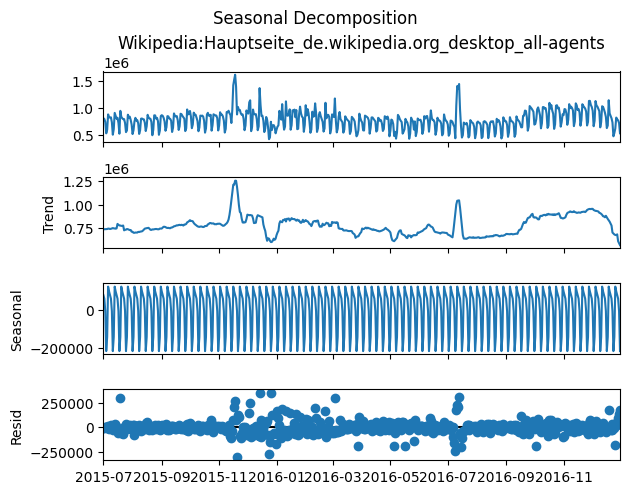

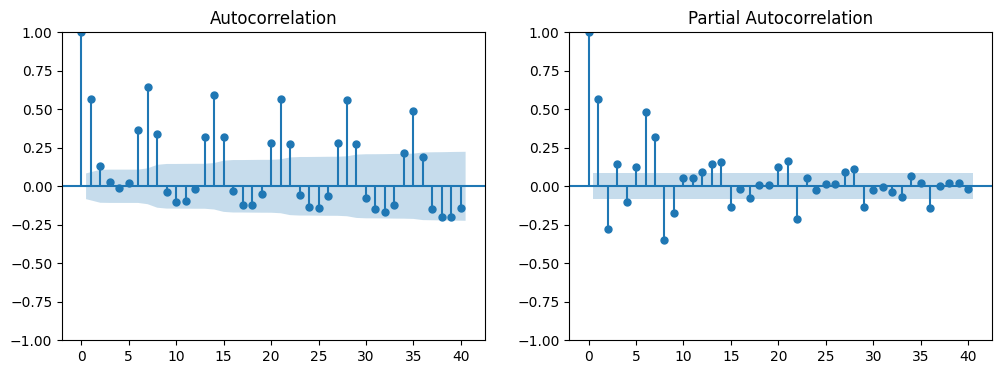


🔹 Analyzing page: Kellyanne_Conway_de.wikipedia.org_all-access_spider
ADF Statistic: -3.132 | p-value: 0.0243 | Stationary: True


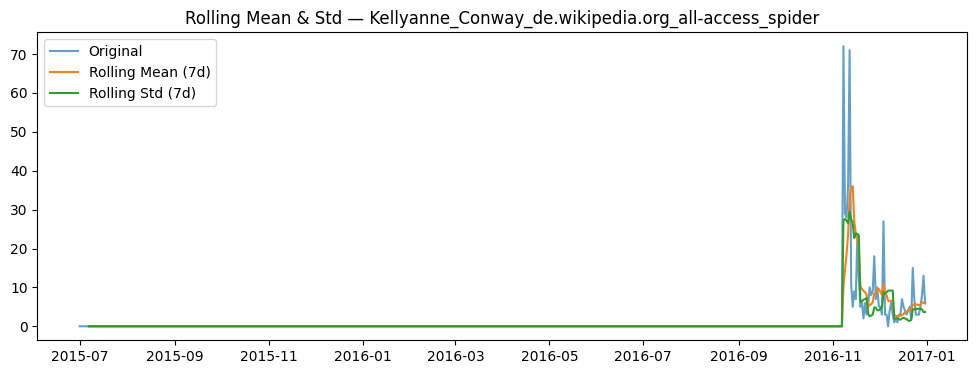

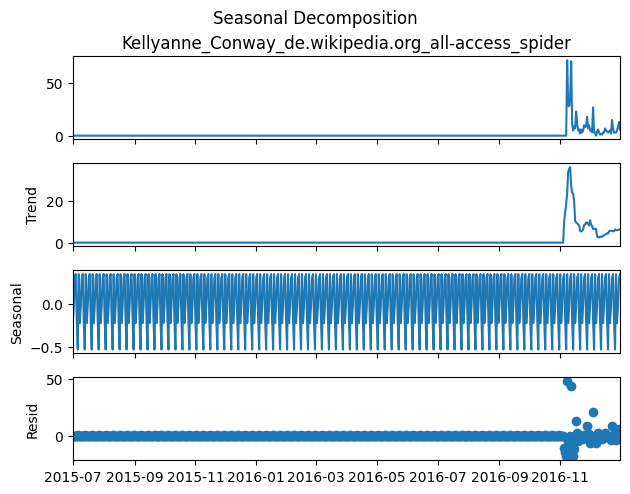

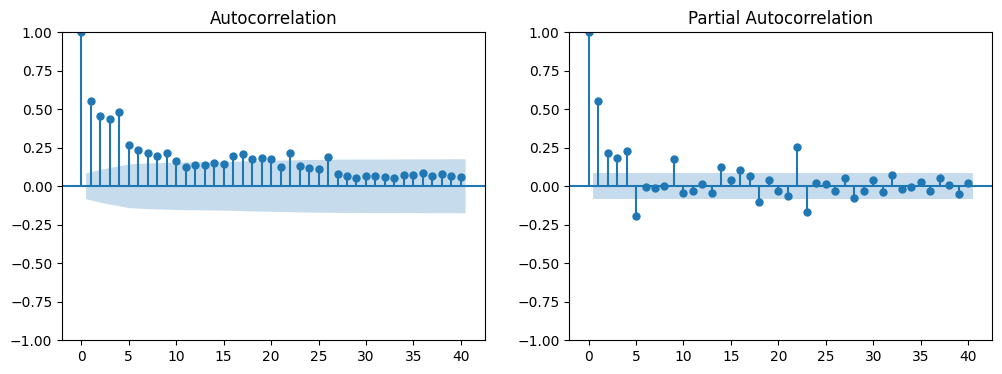


🔹 Analyzing page: メインページ_ja.wikipedia.org_all-access_all-agents
ADF Statistic: -1.429 | p-value: 0.5682 | Stationary: False


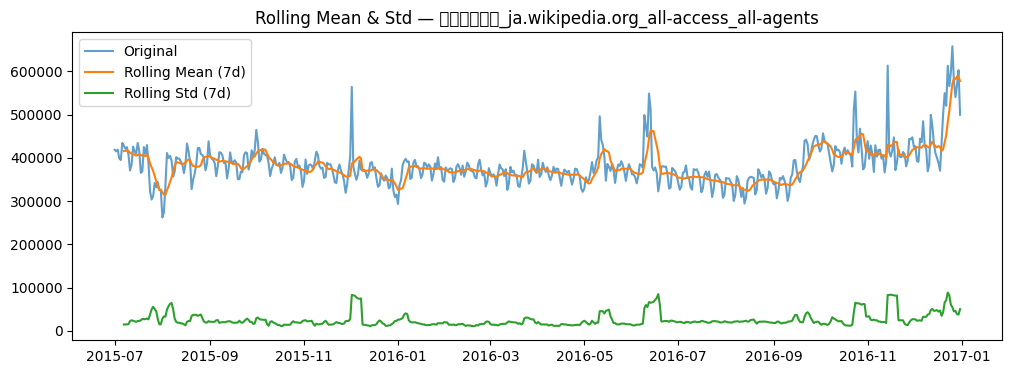

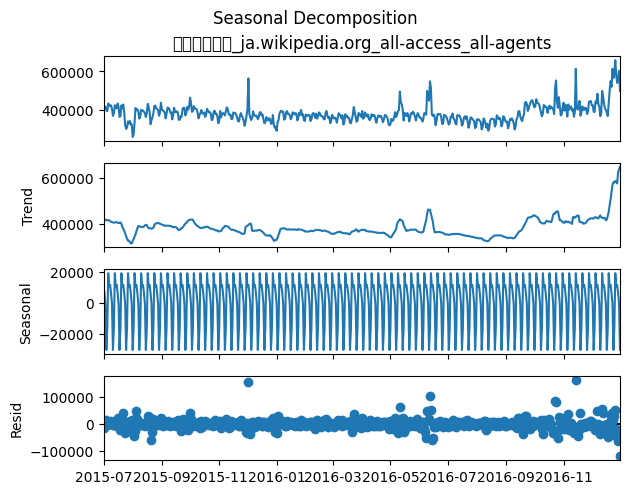

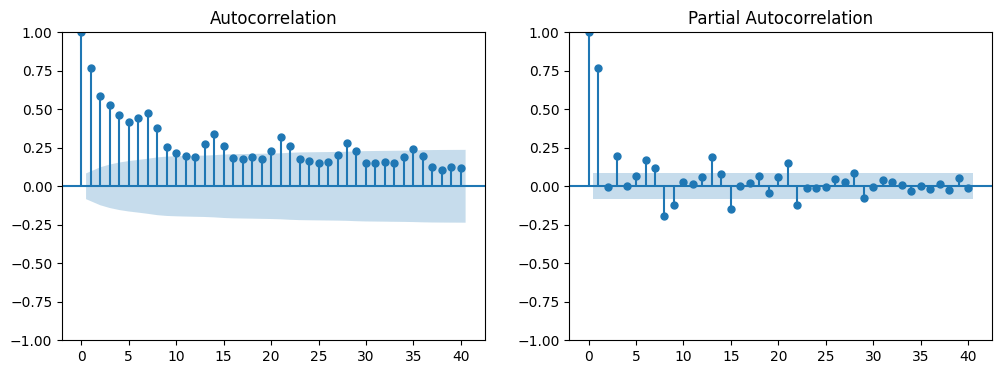


🔹 Analyzing page: メインページ_ja.wikipedia.org_desktop_all-agents
ADF Statistic: -2.472 | p-value: 0.1225 | Stationary: False


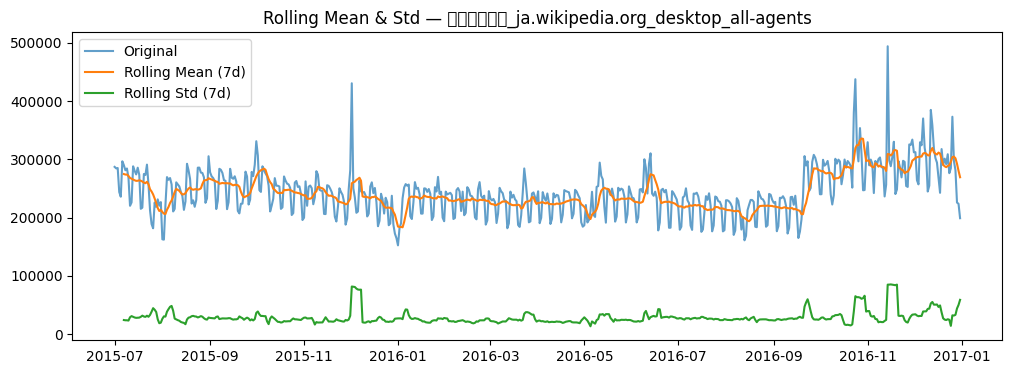

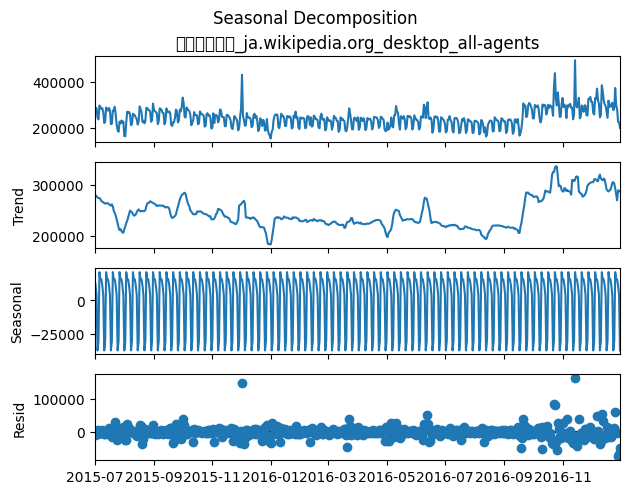

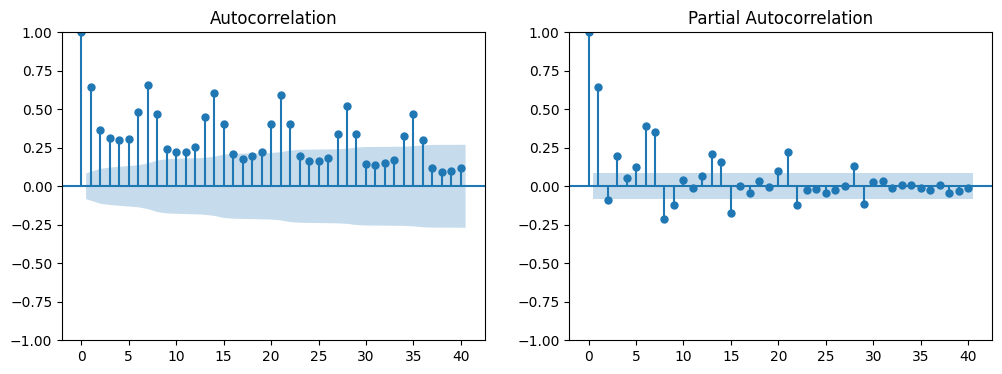


🔹 Analyzing page: 特別:検索_ja.wikipedia.org_all-access_all-agents
ADF Statistic: -3.855 | p-value: 0.0024 | Stationary: True


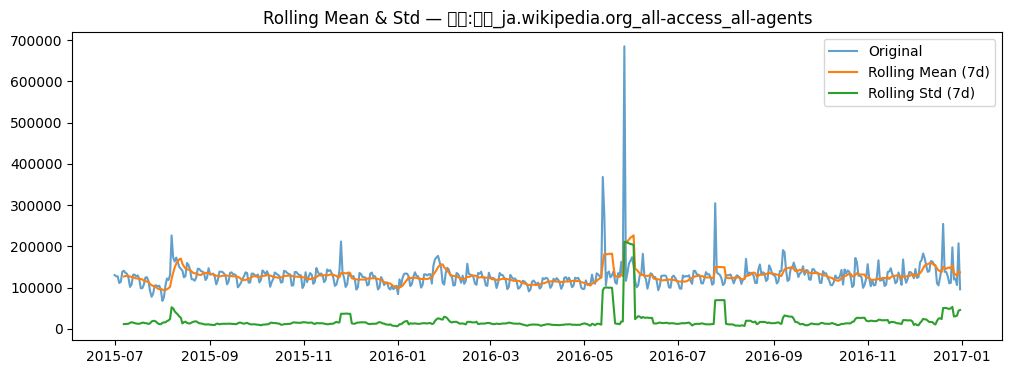

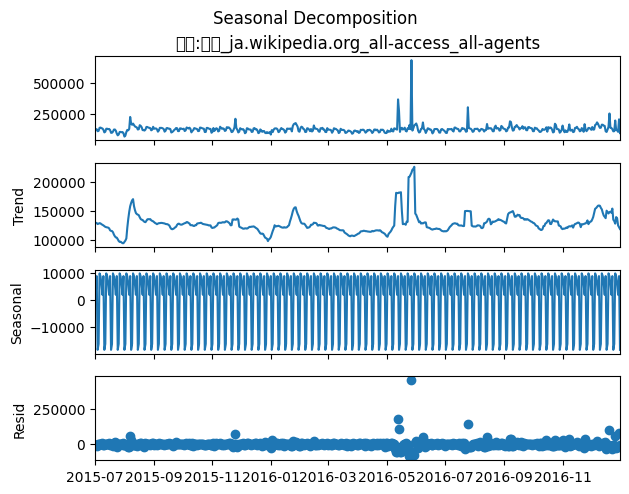

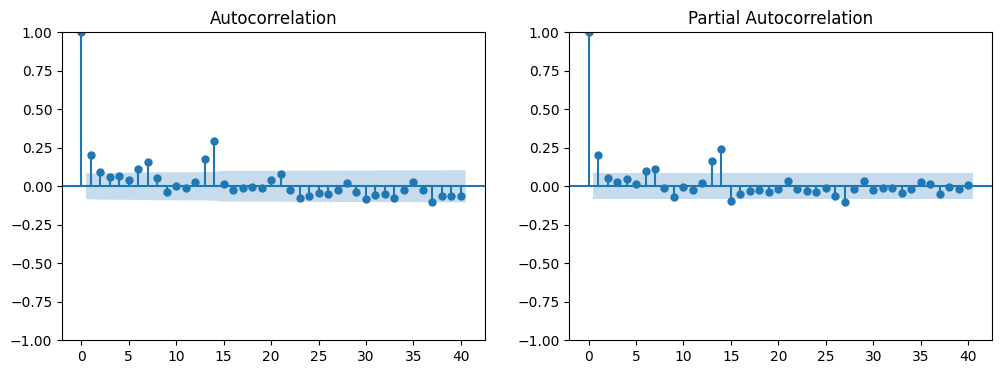


🔹 Analyzing page: キングオブコメディ_ja.wikipedia.org_all-access_all-agents
ADF Statistic: -14.300 | p-value: 0.0000 | Stationary: True


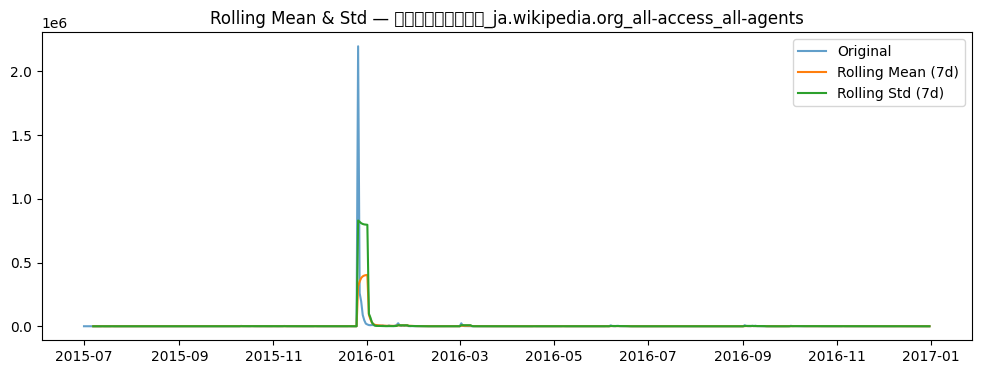

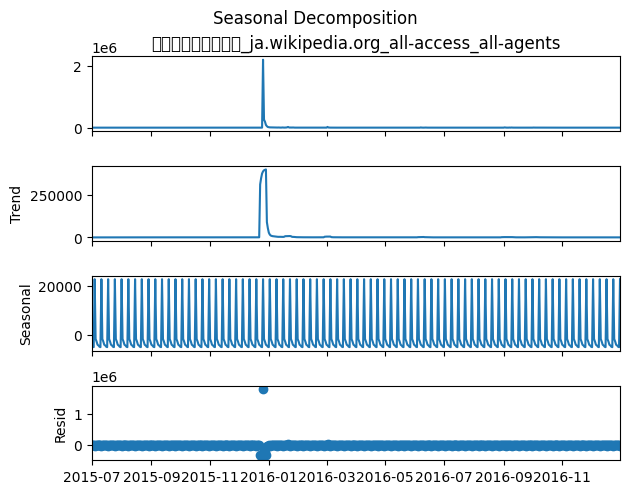

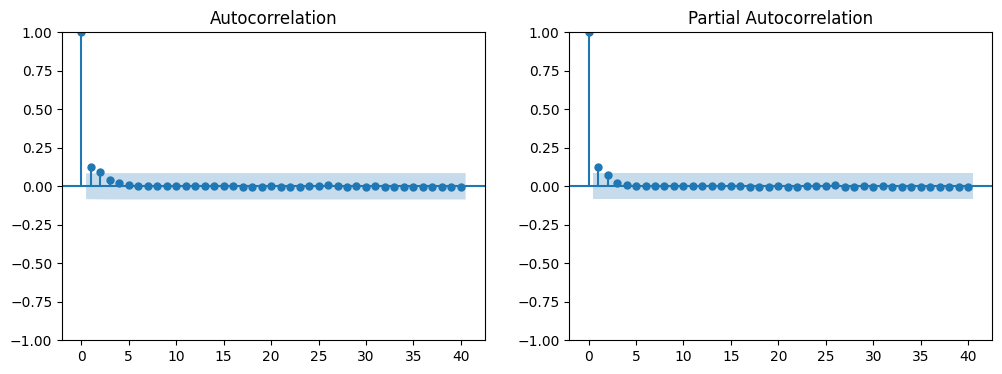


🔹 Analyzing page: MediaWiki:EnhancedCollapsibleElements.js_ja.wikipedia.org_all-access_spider
ADF Statistic: -23.524 | p-value: 0.0000 | Stationary: True


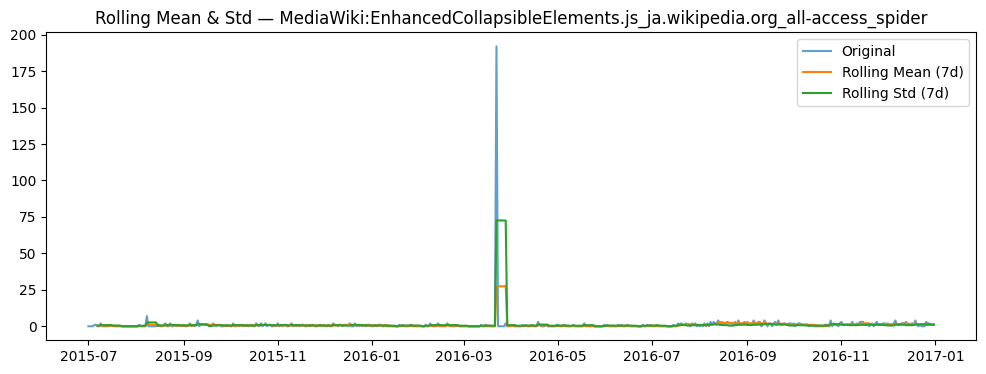

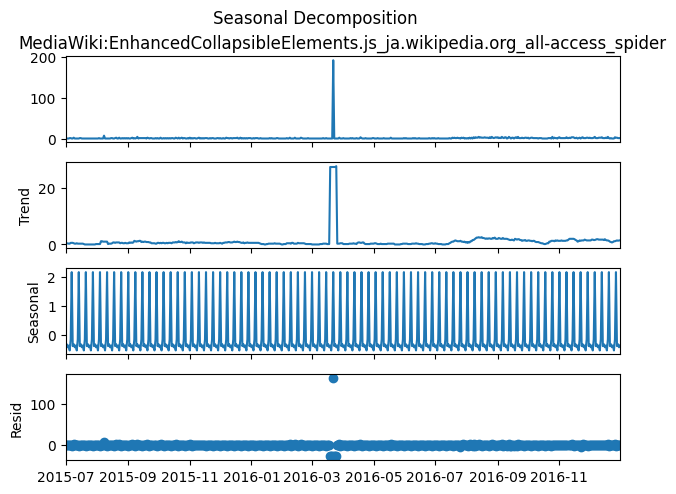

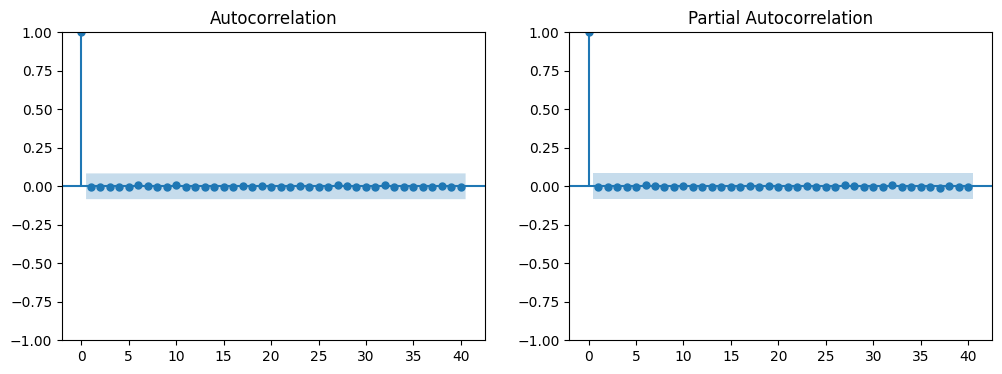


🔹 Analyzing page: Wikipedia:Portada_es.wikipedia.org_all-access_all-agents
ADF Statistic: -1.061 | p-value: 0.7304 | Stationary: False


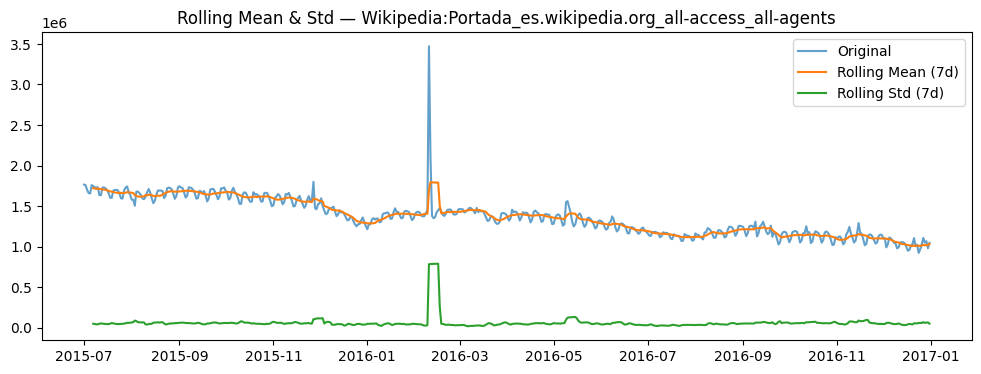

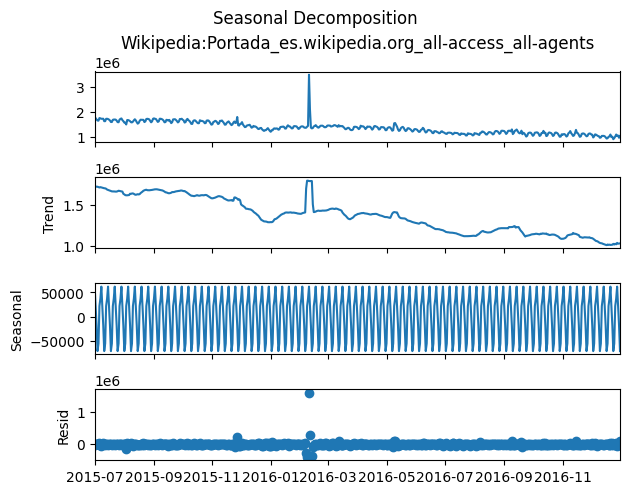

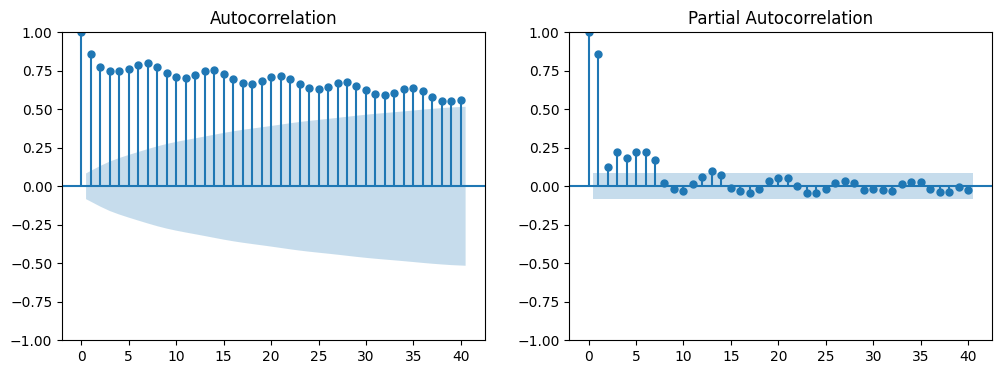


🔹 Analyzing page: Wikipedia:Portada_es.wikipedia.org_mobile-web_all-agents
ADF Statistic: -0.434 | p-value: 0.9042 | Stationary: False


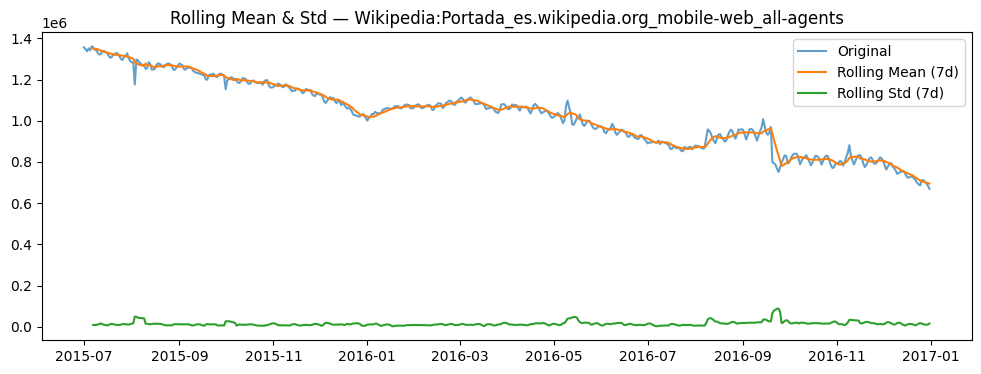

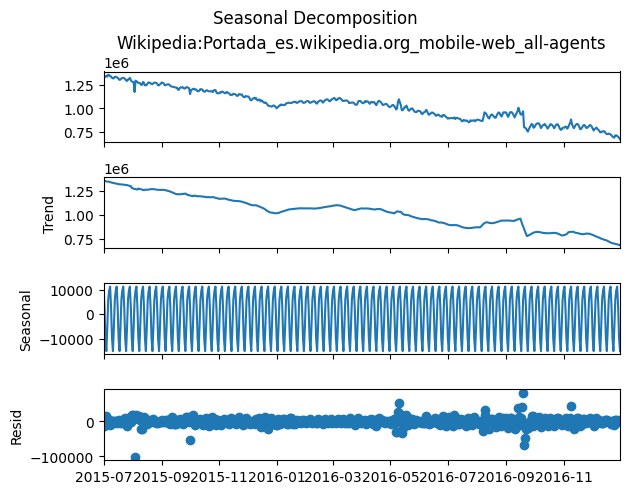

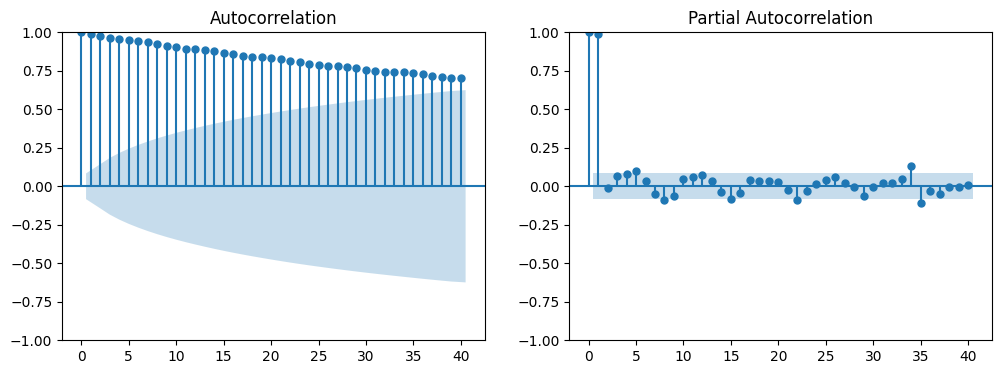


🔹 Analyzing page: Especial:Buscar_es.wikipedia.org_all-access_all-agents
ADF Statistic: -2.829 | p-value: 0.0543 | Stationary: False


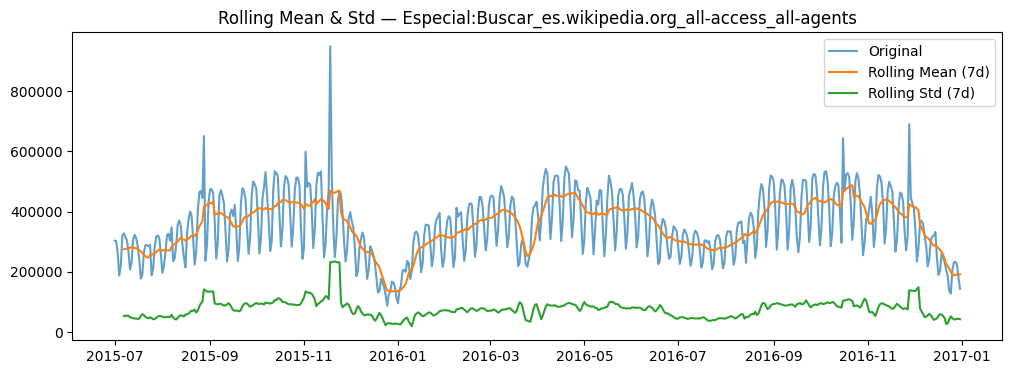

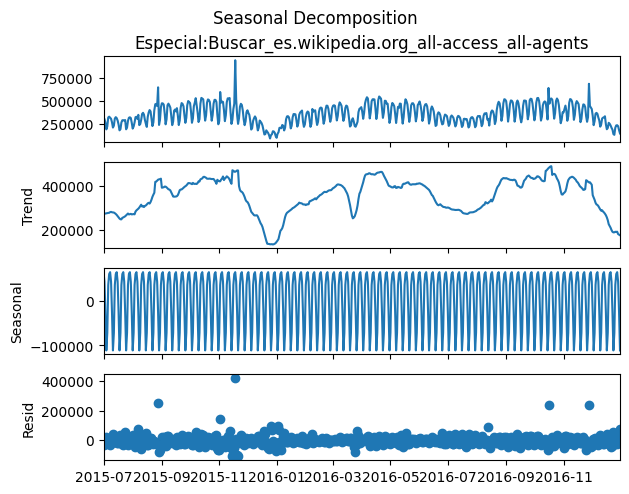

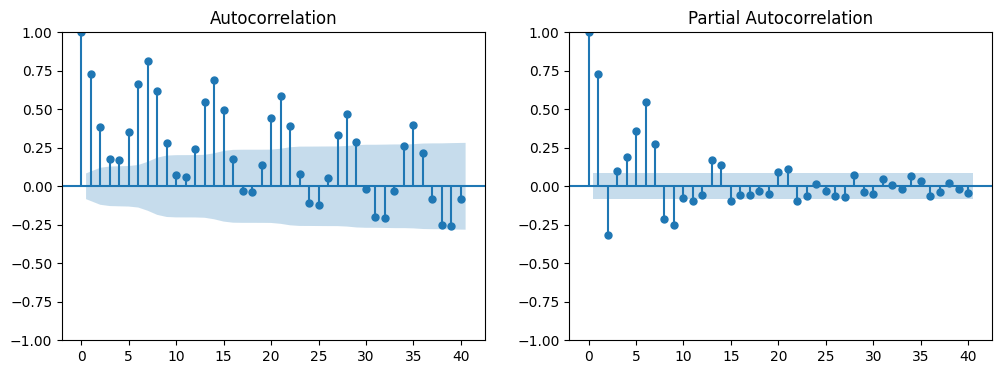


🔹 Analyzing page: Donald_Trump_Jr._es.wikipedia.org_all-access_spider
ADF Statistic: -3.169 | p-value: 0.0218 | Stationary: True


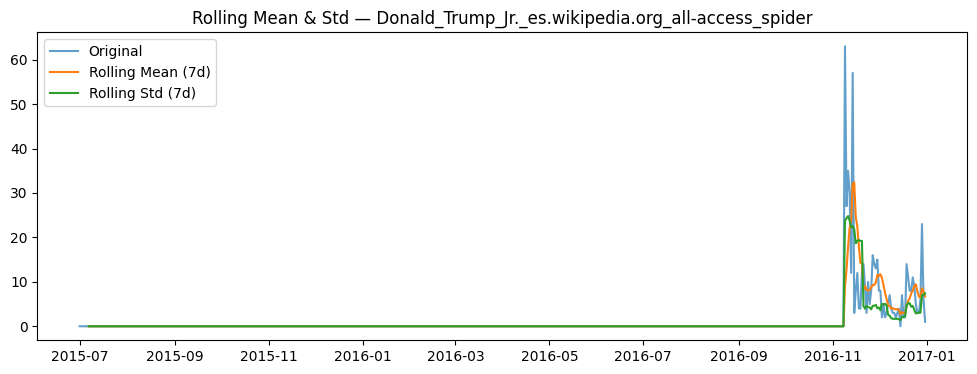

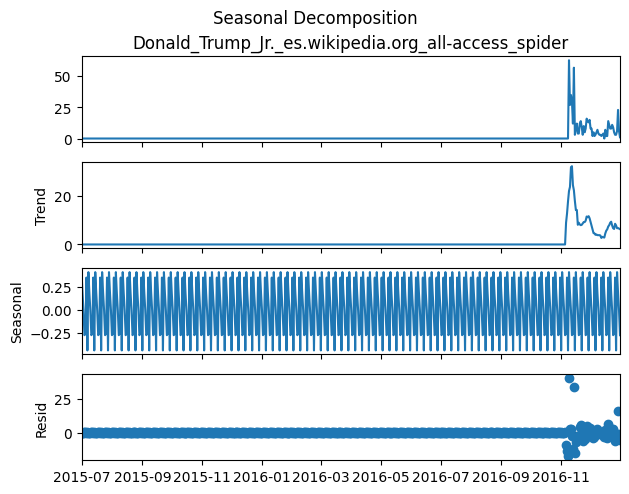

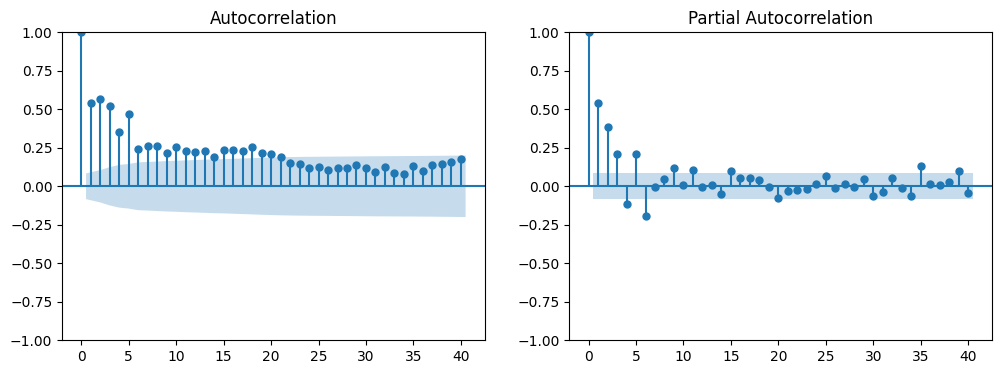

In [ ]:
# --- Loop over representative pages ---
stationarity_results = []

for page in rep_pages:
    print(f"\n🔹 Analyzing page: {page}")
    series = ts_wide[page].dropna()

    # ADF test
    res = check_stationarity(series)
    print(f"ADF Statistic: {res['adf_stat']:.3f} | p-value: {res['pvalue']:.4f} | Stationary: {res['stationary']}")

    # Rolling mean & variance
    plot_rolling_stats(series, f"Rolling Mean & Std — {page}")

    # Decomposition
    decompose_and_plot(series)

    # ACF/PACF
    plot_acf_pacf(series)

    # Store results
    stationarity_results.append({'Page': page, **res})

    # Free memory after each loop
    plt.close('all')
    gc.collect()


In [ ]:
# --- Summarize stationarity results ---
stationarity_summary = pd.DataFrame(stationarity_results)
display(stationarity_summary)

Page   adf_stat  \
0   Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  -2.657357   
1    Wikipedia:首页_zh.wikipedia.org_desktop_all-agents  -2.802483   
2   Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...  -2.579122   
3   福音戰士新劇場版：Q_zh.wikipedia.org_all-access_all-agents -15.306822   
4              洪晨穎_zh.wikipedia.org_all-access_spider  -1.965600   
5   Wikipédia:Accueil_principal_fr.wikipedia.org_a...  -3.556861   
6   Wikipédia:Accueil_principal_fr.wikipedia.org_m...   0.336084   
7   Wikipédia:Accueil_principal_fr.wikipedia.org_d...  -1.681051   
8   Organisme_de_placement_collectif_en_valeurs_mo...  -4.409367   
9   Skam_(série_télévisée)_fr.wikipedia.org_all-ac...  -0.368781   
10   Main_Page_en.wikipedia.org_all-access_all-agents  -2.990145   
11      Main_Page_en.wikipedia.org_desktop_all-agents  -2.814829   
12   Main_Page_en.wikipedia.org_mobile-web_all-agents  -1.117106   
13  Adelisa_Grabus_en.wikipedia.org_all-access_all...  -2.111746   
14  Special:Search_commons.wikimedia.org_all-acces...  -2.971810   
15  Special:Search_commons.wikimedia.org_desktop_a...  -2.870980   
16  Special:CreateAccount_commons.wikimedia.org_al...  -2.112953   
17  File:Autofellatio_standing.jpg_commons.wikimed...  -5.466603   
18  Заглавная_страница_ru.wikipedia.org_all-access...  -4.128016   
19  Заглавная_страница_ru.wikipedia.org_desktop_al...  -4.094982   
20  Заглавная_страница_ru.wikipedia.org_mobile-web...  -0.163155   
21  Рождественский_сочельник_ru.wikipedia.org_all-...  -6.168744   
22  MediaWiki_www.mediawiki.org_all-access_all-agents -11.067696   
23     MediaWiki_www.mediawiki.org_desktop_all-agents -14.194235   
24  Parsoid/Developer_Setup_www.mediawiki.org_all-...  -5.156569   
25  Wikimedia_Engineering/Introducing_Victoria_Col...  -1.792709   
26  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  -1.520025   
27  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...   0.316024   
28  Wikipedia:Hauptseite_de.wikipedia.org_desktop_...  -2.900289   
29  Kellyanne_Conway_de.wikipedia.org_all-access_s...  -3.131660   
30      メインページ_ja.wikipedia.org_all-access_all-agents  -1.429105   
31         メインページ_ja.wikipedia.org_desktop_all-agents  -2.471843   
32       特別:検索_ja.wikipedia.org_all-access_all-agents  -3.854522   
33   キングオブコメディ_ja.wikipedia.org_all-access_all-agents -14.300236   
34  MediaWiki:EnhancedCollapsibleElements.js_ja.wi... -23.524375   
35  Wikipedia:Portada_es.wikipedia.org_all-access_...  -1.060839   
36  Wikipedia:Portada_es.wikipedia.org_mobile-web_...  -0.434367   
37  Especial:Buscar_es.wikipedia.org_all-access_al...  -2.828754   
38  Donald_Trump_Jr._es.wikipedia.org_all-access_s...  -3.169150   

          pvalue  stationary  \
0   8.171247e-02       False   
1   5.791990e-02       False   
2   9.738949e-02       False   
3   4.238877e-28        True   
4   3.018570e-01       False   
5   6.641374e-03        True   
6   9.789408e-01       False   
7   4.409013e-01       False   
8   2.857052e-04        True   
9   9.151822e-01       False   
10  3.582506e-02        True   
11  5.618654e-02       False   
12  7.082022e-01       False   
13  2.398176e-01       False   
14  3.761219e-02        True   
15  4.882814e-02        True   
16  2.393380e-01       False   
17  2.450898e-06        True   
18  8.702509e-04        True   
19  9.871873e-04        True   
20  9.427734e-01       False   
21  6.887349e-08        True   
22  4.636893e-20        True   
23  1.834290e-26        True   
24  1.077634e-05        True   
25  3.840874e-01       False   
26  5.235831e-01       False   
27  9.780678e-01       False   
28  4.531445e-02        True   
29  2.429721e-02        True   
30  5.682462e-01       False   
31  1.224764e-01       False   
32  2.396235e-03        True   
33  1.232623e-26        True   
34  0.000000e+00        True   
35  7.304336e-01       False   
36  9.042007e-01       False   
37  5.428235e-02       False   
38  2.184129e-02        True   

                                               

### Automatic Log + Differencing for Non-Stationary Series

#### ARIMA and SARIMAX — Stationarity Considerations

Although **ARIMA** and **SARIMAX** can fit **non-stationary data** directly, it’s still important to **check for stationarity** first to determine the correct **d** and **D** parameters.

If you skip checking stationarity, the model might:

- **Over-difference** → removes too much structure from the data  
- **Under-difference** → leaves trends, resulting in **residuals that aren’t white noise**, leading to **poor forecasts**


In [ ]:
# --- Make a copy of wide data ---
ts_transformed = ts_wide.copy()

def transform_for_stationarity(series, alpha=0.05):
    """Apply log + differencing until stationary or 2 rounds max."""
    s = series.dropna()
    steps = []

    # --- Step 1: check base ---
    res = adfuller(s)
    if res[1] < alpha:
        return s, "original"

    # --- Step 2: log transform ---
    s_log = np.log1p(s)
    res_log = adfuller(s_log.dropna())
    if res_log[1] < alpha:
        return s_log, "log"

    # --- Step 3: first difference ---
    s_diff1 = s_log.diff().dropna()
    res_diff1 = adfuller(s_diff1)
    if res_diff1[1] < alpha:
        return s_diff1, "log+diff1"

    # --- Step 4: seasonal difference (weekly) ---
    s_diff2 = s_diff1.diff(7).dropna()
    res_diff2 = adfuller(s_diff2)
    if res_diff2[1] < alpha:
        return s_diff2, "log+diff1+diff7"

    return s_diff2, "non-stationary_after_all"


In [ ]:
# --- Apply transformations ---
transformation_results = []

for page in ts_wide.columns:
    series = ts_wide[page].dropna()
    transformed, method = transform_for_stationarity(series)
    ts_transformed[page] = transformed.reindex(ts_wide.index)
    transformation_results.append({
        "Page": page,
        "Transformation": method
    })
    plt.close('all')
    gc.collect()

In [ ]:
transformation_summary = pd.DataFrame(transformation_results)
# display(transformation_summary.value_counts("Transformation"))

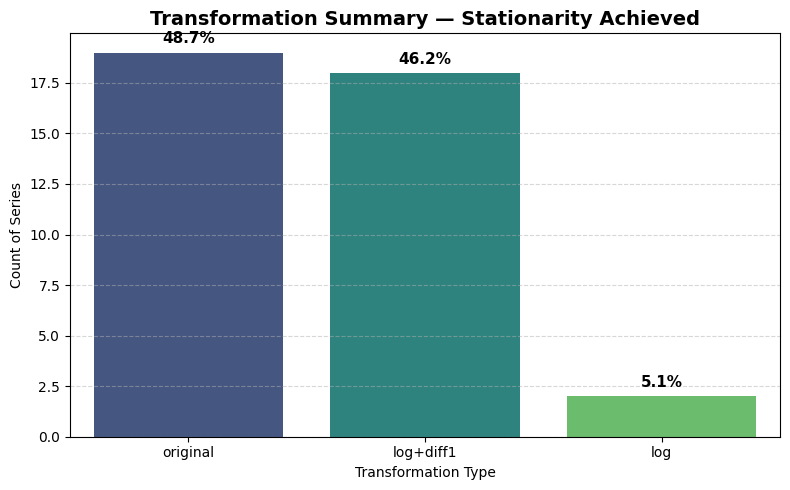

Transformation  Count  Percentage
0       original     19        48.7
1      log+diff1     18        46.2
2            log      2         5.1

In [ ]:
# Count the transformations
transformation_counts = transformation_summary['Transformation'].value_counts().reset_index()
transformation_counts.columns = ['Transformation', 'Count']

# Calculate percentages
total = transformation_counts['Count'].sum()
transformation_counts['Percentage'] = (transformation_counts['Count'] / total * 100).round(1)

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=transformation_counts,
    x='Transformation',
    y='Count',
    palette='viridis'
)

# Annotate with percentages
for i, row in transformation_counts.iterrows():
    plt.text(i, row['Count'] + 0.3, f"{row['Percentage']}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Transformation Summary — Stationarity Achieved', fontsize=14, fontweight='bold')
plt.xlabel('Transformation Type')
plt.ylabel('Count of Series')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: display the table below
display(transformation_counts)

In [ ]:
# Save the transformation mapping DataFrame
save_path = "/content/drive/My Drive/Wikipedia/"


# transformation_summary.to_csv(save_path + "transformation_summary.csv", index=False)

In [ ]:
# Create an empty DataFrame to store the transformed time series
ts_stationary = pd.DataFrame(index=ts_wide.index)

# Iterate through each page (column) in ts_wide
for page in ts_wide.columns:
    series = ts_wide[page].dropna()

    # Find the transformation method for the current page
    transformation_method = transformation_summary[transformation_summary['Page'] == page]['Transformation'].iloc[0]

    # Apply the transformation
    if transformation_method == 'original':
        transformed_series = series
    elif transformation_method == 'log':
        transformed_series = np.log1p(series)
    elif transformation_method == 'log+diff1':
        transformed_series = np.log1p(series).diff().dropna()
    elif transformation_method == 'log+diff1+diff7': # Although none were found, include for completeness
         transformed_series = np.log1p(series).diff().dropna().diff(7).dropna()
    else:
        # Handle cases where transformation is 'non-stationary_after_all' or unexpected
        print(f"Warning: No suitable transformation found for page: {page}. Skipping transformation.")
        transformed_series = series # Keep original or handle as needed

    # Add the transformed series to the new DataFrame
    ts_stationary[page] = transformed_series.reindex(ts_wide.index)

print("Transformed data prepared in ts_stationary.")
display(ts_stationary.head())

Transformed data prepared in ts_stationary.


Adelisa_Grabus_en.wikipedia.org_all-access_all-agents  \
date                                                                
2015-07-01                                                NaN       
2015-07-02                                                0.0       
2015-07-03                                                0.0       
2015-07-04                                                0.0       
2015-07-05                                                0.0       

            Donald_Trump_Jr._es.wikipedia.org_all-access_spider  \
date                                                              
2015-07-01                                                0.0     
2015-07-02                                                0.0     
2015-07-03                                                0.0     
2015-07-04                                                0.0     
2015-07-05                                                0.0     

            Especial:Buscar_es.wikipedia.org_all-access_all-agents  \
date                                                                 
2015-07-01                                          12.622797        
2015-07-02                                          12.621986        
2015-07-03                                          12.477595        
2015-07-04                                          12.144431        
2015-07-05                                          12.303816        

            File:Autofellatio_standing.jpg_commons.wikimedia.org_all-access_spider  \
date                                                                                 
2015-07-01                                                0.0                        
2015-07-02                                                0.0                        
2015-07-03                                                1.0                        
2015-07-04                                                0.0                        
2015-07-05                                                1.0                        

            Kellyanne_Conway_de.wikipedia.org_all-access_spider  \
date                                                              
2015-07-01                                                0.0     
2015-07-02                                                0.0     
2015-07-03                                                0.0     
2015-07-04                                                0.0     
2015-07-05                                                0.0     

            Main_Page_en.wikipedia.org_all-access_all-agents  \
date                                                           
2015-07-01                                        20381245.0   
2015-07-02                                        20752194.0   
2015-07-03                                        19573967.0   
2015-07-04                                        20439645.0   
2015-07-05                                        20772109.0   

            Main_Page_en.wikipedia.org_desktop_all-agents  \
date                                                        
2015-07-01                                            NaN   
2015-07-02                                       0.032226   
2015-07-03                                      -0.097629   
2015-07-04                                       0.067902   
2015-07-05                                       0.032612   

            Main_Page_en.wikipedia.org_mobile-web_all-agents  \
date                                                           
2015-07-01                                               NaN   
2015-07-02                                         -0.002631   
2015-07-03                                         -0.004762   
2015-07-04                                          0.005536   
2015-07-05                                         -0.011890   

            MediaWiki:EnhancedCollapsibleElements.js_ja.wikipedia.org_all-access_spider  \
date                                                                         

In [ ]:
# ts_stationary.to_csv(save_path + "ts_stationary.csv", index=False)

## 7. Modeling

### (a) ARIMA  
- Perform **grid search** for parameters `(p, d, q)`.  
- Forecast and evaluate performance using **MAPE**.  

#### Workflow
1. **Pick a page** from your representative sample.  
2. **Determine transformation & differencing** from `transformation_summary`:  
   - If `"log"` in method → fit on `np.log1p(series)` and invert forecast with `np.expm1(...)`.  
   - If `"diff1"` in method → set `d=1` in ARIMA; otherwise `d=0`.  

3. **Grid search for ARIMA (p,d,q)**  
   - Keep `(p,d,q)` small to limit compute.  

4. **Rolling-origin evaluation**  
   - Train on all but last `h` days, forecast `h` days.  

5. **Compute MAPE** on the **original scale** (after inverse transformation if log applied).  

#### Notes
- Memory-conscious → works on representative subset, not all ~145k pages.  
- Internal ARIMA differencing handles `d` automatically; no manual cumulative inversion needed.  
- Can scale or tune further after confirming results on 1–3 pages.

#### 1) Utility functions — fit / forecast / evaluate

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# MAPE (safe with eps)
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.abs(y_true) + eps
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# Helper: get transformation info for a page from transformation_summary (DataFrame)
def get_transformation_for_page(page, transformation_summary):
    # transformation_summary columns: ['Page','Transformation']
    row = transformation_summary[transformation_summary['Page'] == page]
    if row.empty:
        return "original"
    return row['Transformation'].iloc[0]

#### 2) Fit & forecast single ARIMA (grid search) with evaluation

In [ ]:
# Single-page grid search + rolling forecast evaluation
def arima_grid_search_and_eval(page, ts_wide, transformation_summary,
                               p_range=(0,1,2), q_range=(0,1,2),
                               test_horizon=30, seasonal=False, seasonal_period=7):
    """
    Grid search ARIMA for a single page, evaluate with last `test_horizon` days.
    Returns best result dict containing order, model_fit, forecast, mape.
    """

    # Prepare series
    series = ts_wide[page].astype(float).dropna()
    if len(series) < (test_horizon + 60):  # ensure enough history
        raise ValueError(f"Series too short for page {page}")

    # Determine transformation and differencing (d)
    method = get_transformation_for_page(page, transformation_summary)
    use_log = 'log' in method
    d = 1 if 'diff1' in method else 0

    # transformed series for fitting
    y = np.log1p(series) if use_log else series

    # train/test split (last h days for test)
    train_y = y.iloc[:-test_horizon]
    test_y_orig = series.iloc[-test_horizon:]   # original scale test truth
    test_index = test_y_orig.index

    best = {'mape': np.inf, 'order': None, 'model_res': None, 'forecast': None, 'pred_series': None}

    # grid search (small ranges to keep compute reasonable)
    for p in p_range:
        for q in q_range:
            order = (p, d, q)
            try:
                # Fit model (non-seasonal)
                model = ARIMA(train_y, order=order)
                res = model.fit()
                # Forecast h steps (returned in transformed level-space)
                pred_trans = res.forecast(steps=test_horizon)
                # invert transform if log used
                if use_log:
                    pred_orig = np.expm1(pred_trans)  # invert log1p
                else:
                    pred_orig = pred_trans

                # match indices
                pred_orig = pd.Series(pred_orig, index=test_index)

                # compute MAPE on original scale
                m = mape(test_y_orig.values, pred_orig.values)
                # store best
                if m < best['mape']:
                    best.update({
                        'mape': m,
                        'order': order,
                        'model_res': res,
                        'forecast': pred_orig,
                        'pred_series': pred_orig
                    })
            except Exception as e:
                # skip failures (non-invertible, convergence, etc.)
                # print(f"skip {order} for {page}: {e}")
                continue

    return best

#### 3) Run the function for one page (example)

Best order: (0, 1, 2)
MAPE (30-day): 8.52268139681461


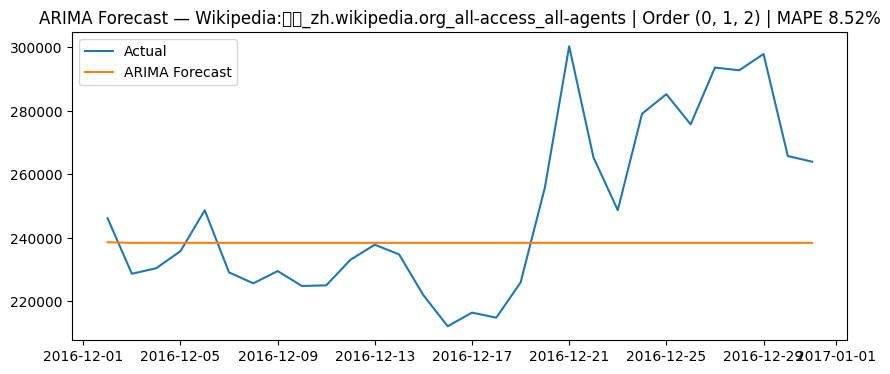

6634

In [ ]:
page = rep_pages[0]           # e.g. 'Adelisa_Grabus_...'
result = arima_grid_search_and_eval(page, ts_wide, transformation_summary,
                                   p_range=[0,1,2], q_range=[0,1,2],
                                   test_horizon=30)

print("Best order:", result['order'])
print("MAPE (30-day):", result['mape'])
# Plot actual vs forecast
test_idx = result['forecast'].index
actual = ts_wide[page].loc[test_idx]
plt.figure(figsize=(10,4))
plt.plot(actual.index, actual.values, label='Actual')
plt.plot(result['forecast'].index, result['forecast'].values, label='ARIMA Forecast')
plt.title(f"ARIMA Forecast — {page} | Order {result['order']} | MAPE {result['mape']:.2f}%")
plt.legend()
plt.show()

# Add garbage collection
gc.collect()

#### 4) Run across representative pages (batch)

In [ ]:
results = []
for page in rep_pages:
    try:
        print("Running ARIMA grid for:", page)
        res = arima_grid_search_and_eval(page, ts_wide, transformation_summary,
                                         p_range=[0,1,2], q_range=[0,1,2],
                                         test_horizon=30)
        results.append({
            'Page': page,
            'BestOrder': res['order'],
            'MAPE_30': res['mape']
        })
    except Exception as e:
        print("Failed for", page, ":", e)

    # Add garbage collection inside the loop
    gc.collect()


arima_df = pd.DataFrame(results).sort_values('MAPE_30')
display(arima_df)
# save results
arima_df.to_csv(save_path + "arima_rep_sample_results.csv", index=False)

# Add garbage collection after creating the DataFrame
gc.collect()

Running ARIMA grid for: Wikipedia:首页_zh.wikipedia.org_all-access_all-agents
Running ARIMA grid for: Wikipedia:首页_zh.wikipedia.org_desktop_all-agents
Running ARIMA grid for: Wikipedia:首页_zh.wikipedia.org_mobile-web_all-agents
Running ARIMA grid for: 福音戰士新劇場版：Q_zh.wikipedia.org_all-access_all-agents
Running ARIMA grid for: 洪晨穎_zh.wikipedia.org_all-access_spider
Running ARIMA grid for: Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents
Running ARIMA grid for: Wikipédia:Accueil_principal_fr.wikipedia.org_mobile-web_all-agents
Running ARIMA grid for: Wikipédia:Accueil_principal_fr.wikipedia.org_desktop_all-agents
Running ARIMA grid for: Organisme_de_placement_collectif_en_valeurs_mobilières_fr.wikipedia.org_all-access_all-agents
Running ARIMA grid for: Skam_(série_télévisée)_fr.wikipedia.org_all-access_spider
Running ARIMA grid for: Main_Page_en.wikipedia.org_all-access_all-agents
Running ARIMA grid for: Main_Page_en.wikipedia.org_desktop_all-agents
Running ARIMA grid for: M

Page  BestOrder       MAPE_30
27  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...  (0, 1, 0)  1.633610e+00
6   Wikipédia:Accueil_principal_fr.wikipedia.org_m...  (1, 1, 0)  2.043922e+00
12   Main_Page_en.wikipedia.org_mobile-web_all-agents  (1, 1, 2)  2.981621e+00
20  Заглавная_страница_ru.wikipedia.org_mobile-web...  (0, 1, 1)  3.451179e+00
2   Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...  (2, 1, 0)  4.898976e+00
5   Wikipédia:Accueil_principal_fr.wikipedia.org_a...  (2, 0, 2)  6.304340e+00
7   Wikipédia:Accueil_principal_fr.wikipedia.org_d...  (1, 1, 1)  7.114797e+00
35  Wikipedia:Portada_es.wikipedia.org_all-access_...  (2, 1, 2)  7.516568e+00
1    Wikipedia:首页_zh.wikipedia.org_desktop_all-agents  (0, 0, 2)  7.711223e+00
0   Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  (0, 1, 2)  8.522681e+00
36  Wikipedia:Portada_es.wikipedia.org_mobile-web_...  (2, 1, 2)  9.427664e+00
11      Main_Page_en.wikipedia.org_desktop_all-agents  (2, 1, 2)  9.586058e+00
10   Main_Page_en.wikipedia.org_all-access_all-agents  (0, 0, 2)  1.022049e+01
22  MediaWiki_www.mediawiki.org_all-access_all-agents  (2, 0, 1)  1.156143e+01
26  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  (2, 1, 1)  1.183058e+01
31         メインページ_ja.wikipedia.org_desktop_all-agents  (2, 1, 1)  1.203110e+01
23     MediaWiki_www.mediawiki.org_desktop_all-agents  (0, 0, 0)  1.256004e+01
30      メインページ_ja.wikipedia.org_all-access_all-agents  (2, 1, 0)  1.379331e+01
32       特別:検索_ja.wikipedia.org_all-access_all-agents  (2, 0, 1)  1.722790e+01
28  Wikipedia:Hauptseite_de.wikipedia.org_desktop_...  (1, 0, 2)  1.869162e+01
18  Заглавная_страница_ru.wikipedia.org_all-access...  (1, 0, 0)  2.257075e+01
14  Special:Search_commons.wikimedia.org_all-acces...  (0, 0, 2)  2.698410e+01
19  Заглавная_страница_ru.wikipedia.org_desktop_al...  (1, 0, 0)  2.994870e+01
15  Special:Search_commons.wikimedia.org_desktop_a...  (0, 0, 2)  3.389513e+01
16  Special:CreateAccount_commons.wikimedia.org_al...  (2, 1, 0)  3.883665e+01
25  Wikimedia_Engineering/Introducing_Victoria_Col...  (1, 1, 0)  4.117291e+01
37  Especial:Buscar_es.wikipedia.org_all-access_al...  (0, 0, 0)  4.872063e+01
4              洪晨穎_zh.wikipedia.org_all-access_spider  (0, 1, 0)  9.666667e+01
33   キングオブコメディ_ja.wikipedia.org_all-access_all-agents  (1, 0, 1)  1.373184e+03
3   福音戰士新劇場版：Q_zh.wikipedia.org_all-access_all-agents  (1, 0, 0)  1.603535e+03
8   Organisme_de_placement_collectif_en_valeurs_mo...  (1, 0, 0)  1.954018e+04
24  Parsoid/Developer_Setup_www.mediawiki.org_all-...  (1, 0, 0)  2.185105e+04
38  Donald_Trump_Jr._es.wikipedia.org_all-access_s...  (0, 0, 0)  2.448702e+08
29  Kellyanne_Conway_de.wikipedia.org_all-access_s...  (0, 0, 0)  2.544856e+08
9   Skam_(série_télévisée)_fr.wikipedia.org_all-ac...  (0, 1, 0)  3.333334e+08
34  MediaWiki:EnhancedCollapsibleElements.js_ja.wi...  (2, 0, 1)  1.053409e+09
21  Рождественский_сочельник_ru.wikipedia.org_all-...  (0, 0, 2)  2.587430e+09
13  Adelisa_Grabus_en.wikipedia.org_all-access_all...  (2, 1, 2)  3.145232e+09
17  File:Autofellatio_standing.jpg_commons.wikimed...  (0, 0, 0)  4.149978e+09

31

In [ ]:
arima_df.shape

(39, 3)

In [ ]:
arima_df.head()

Page  BestOrder   MAPE_30
27  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...  (0, 1, 0)  1.633610
6   Wikipédia:Accueil_principal_fr.wikipedia.org_m...  (1, 1, 0)  2.043922
12   Main_Page_en.wikipedia.org_mobile-web_all-agents  (1, 1, 2)  2.981621
20  Заглавная_страница_ru.wikipedia.org_mobile-web...  (0, 1, 1)  3.451179
2   Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...  (2, 1, 0)  4.898976


### (b) SARIMAX (with exogenous variables for English pages)  
- Incorporate **campaign variable** as exogenous input.  
- Evaluate forecast accuracy against baseline models.

In [ ]:
campaign.sample(5)

Exog
541     0
418     0
519     0
481     0
202     0

In [ ]:
ts_wide.sample(5)

Page        Adelisa_Grabus_en.wikipedia.org_all-access_all-agents  \
date                                                                
2015-12-11                                                0.0       
2016-12-13                                                0.0       
2016-07-26                                                2.0       
2016-02-15                                                0.0       
2016-09-03                                                3.0       

Page        Donald_Trump_Jr._es.wikipedia.org_all-access_spider  \
date                                                              
2015-12-11                                                0.0     
2016-12-13                                                3.0     
2016-07-26                                                0.0     
2016-02-15                                                0.0     
2016-09-03                                                0.0     

Page        Especial:Buscar_es.wikipedia.org_all-access_all-agents  \
date                                                                 
2015-12-11                                           243698.0        
2016-12-13                                           317059.0        
2016-07-26                                           320402.0        
2016-02-15                                           379640.0        
2016-09-03                                           273754.0        

Page        File:Autofellatio_standing.jpg_commons.wikimedia.org_all-access_spider  \
date                                                                                 
2015-12-11                                                0.0                        
2016-12-13                                                5.0                        
2016-07-26                                                2.0                        
2016-02-15                                                0.0                        
2016-09-03                                                0.0                        

Page        Kellyanne_Conway_de.wikipedia.org_all-access_spider  \
date                                                              
2015-12-11                                                0.0     
2016-12-13                                                1.0     
2016-07-26                                                0.0     
2016-02-15                                                0.0     
2016-09-03                                                0.0     

Page        Main_Page_en.wikipedia.org_all-access_all-agents  \
date                                                           
2015-12-11                                        17547647.0   
2016-12-13                                        23661288.0   
2016-07-26                                        67264258.0   
2016-02-15                                        20032776.0   
2016-09-03                                        32371673.0   

Page        Main_Page_en.wikipedia.org_desktop_all-agents  \
date                                                        
2015-12-11                                     10563834.0   
2016-12-13                                     19684441.0   
2016-07-26                                     62288712.0   
2016-02-15                                     13926896.0   
2016-09-03                                     27613249.0   

Page        Main_Page_en.wikipedia.org_mobile-web_all-agents  \
date                                                           
2015-12-11                                         6754505.0   
2016-12-13                                         3902733.0   
2016-07-26                                         4792867.0   
2016-02-15                                         5873376.0   
2016-09-03                                         4662526.0   

Page        MediaWiki:EnhancedCollapsibleElements.js_ja.wikipedia.org_all-access_spider  \
date                                                             

#### 🧱 Step 1: Prepare exogenous variable

In [ ]:
# Ensure 'date' column in campaign aligns with ts_wide index
campaign = campaign.reset_index()  # if index is date already, skip this
campaign.columns = ['date', 'Exog']

# Align to ts_wide
exog_series = campaign.set_index('date').reindex(ts_wide.index).fillna(0)

In [ ]:
exog_series.head()

Exog
date            
2015-07-01   0.0
2015-07-02   0.0
2015-07-03   0.0
2015-07-04   0.0
2015-07-05   0.0

#### 🧱 Step 2: Filter English pages

In [ ]:
ts_eng = ts_wide[[c for c in ts_wide.columns if '_en.' in c]]

#### 🧱 Step 3: Define SARIMAX modeling function

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings("ignore")

def fit_sarimax(series, exog, order=(1,1,1), forecast_steps=30):
    # Train-test split
    train = series.iloc[:-forecast_steps]
    test = series.iloc[-forecast_steps:]
    exog_train = exog.iloc[:-forecast_steps]
    exog_test = exog.iloc[-forecast_steps:]

    # Fit SARIMAX
    model = SARIMAX(train, order=order, exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)

    # Forecast
    forecast = result.forecast(steps=forecast_steps, exog=exog_test)

    # Evaluate
    mape_val = mape(test, forecast) * 100

    return result, mape_val, forecast, test


#### 🧱 Step 4: Apply SARIMAX with exogenous variables for English pages

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

warnings.filterwarnings("ignore")

# --- Basic configuration ---
H = 30  # forecast horizon
p_values = [0, 1, 2]
q_values = [0, 1, 2]
seasonal_candidates = [
    (0, 0, 0, 0),
    (0, 0, 0, 7),
    (1, 0, 1, 7)
]

# --- Helper functions ---
def compute_mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.abs(y_true) + eps
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def get_arima_order_from_table(page):
    try:
        if arima_df is None or arima_df.empty:
            return None
        row = arima_df[arima_df['Page'] == page]
        if not row.empty and 'BestOrderTuple' in row.columns and pd.notna(row['BestOrderTuple'].iloc[0]):
            return row['BestOrderTuple'].iloc[0]
        return None
    except Exception:
        return None


# --- Setup ---
exog_aligned = exog_series.reindex(ts_wide.index).fillna(0)
eng_pages = [p for p in ts_wide.columns if "_en.wikipedia.org" in p]
rep_pages = ts_wide.columns.tolist()

results = []

for page in tqdm(rep_pages, desc="Fitting SARIMAX for all pages"):
    try:
        series = ts_wide[page].astype(float).dropna()
        if len(series) < (H + 60):
            continue  # not enough data

        # Split
        y_train, y_test = series.iloc[:-H], series.iloc[-H:]

        # Get exogenous vars only if English page
        if page in eng_pages:
            exog_page = exog_aligned.loc[series.index].values
            exog_train, exog_test = exog_page[:-H], exog_page[-H:]
        else:
            exog_train = exog_test = None

        # Transformation
        trans = transformation_summary[transformation_summary['Page'] == page]
        method = trans['Transformation'].iloc[0] if not trans.empty else "original"
        d = 1 if 'diff1' in method else 0
        use_log = 'log' in method

        y_fit = np.log1p(y_train) if use_log else y_train.copy()

        # Candidate orders
        base_order = get_arima_order_from_table(page)
        candidate_orders = [(base_order[0], d, base_order[2])] if base_order else []
        for p in p_values:
            for q in q_values:
                candidate_orders.append((p, d, q))

        best_mape = np.inf
        best_order = None
        best_seasonal = None

        # --- Grid search ---
        for order in candidate_orders:
            for seasonal in seasonal_candidates:
                try:
                    model = SARIMAX(
                        y_fit,
                        order=order,
                        seasonal_order=seasonal,
                        exog=exog_train if page in eng_pages else None,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    )
                    res = model.fit(disp=False, method="lbfgs", maxiter=200)

                    pred_trans = res.forecast(steps=H, exog=exog_test if page in eng_pages else None)
                    pred = np.expm1(pred_trans) if use_log else pred_trans

                    m = compute_mape(y_test.values, pred.values)
                    if m < best_mape:
                        best_mape, best_order, best_seasonal = m, order, seasonal

                except Exception:
                    continue
                finally:
                    del model, res
                    gc.collect()

        results.append({
            "Page": page,
            "BestOrder": best_order,
            "BestSeasonal": best_seasonal,
            "MAPE_30": best_mape,
            "UsedExog": page in eng_pages
        })

    except Exception as e:
        print(f"⚠️ Error for {page}: {e}")
        continue


# --- Save results ---
sarimax_df = pd.DataFrame(results).sort_values("MAPE_30")
if "save_path" in locals():
    out_path = save_path + "sarimax_results_all.csv"
    sarimax_df.to_csv(out_path, index=False)
    print(f"SARIMAX results saved to {out_path}")
else:
    print("⚠️ save_path not defined, showing preview:")
display(sarimax_df.head(20))

Fitting SARIMAX for all pages: 100%|██████████| 39/39 [09:48<00:00, 15.10s/it]


SARIMAX results saved to /content/drive/My Drive/Wikipedia/sarimax_results_all.csv


Page  BestOrder  \
20  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...  (2, 1, 0)   
28  Wikipédia:Accueil_principal_fr.wikipedia.org_m...  (0, 1, 0)   
7    Main_Page_en.wikipedia.org_mobile-web_all-agents  (1, 1, 2)   
31  Заглавная_страница_ru.wikipedia.org_mobile-web...  (1, 1, 1)   
21  Wikipedia:Portada_es.wikipedia.org_all-access_...  (0, 1, 0)   
25  Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...  (2, 1, 0)   
24   Wikipedia:首页_zh.wikipedia.org_desktop_all-agents  (2, 0, 2)   
9   MediaWiki_www.mediawiki.org_all-access_all-agents  (2, 0, 0)   
27  Wikipédia:Accueil_principal_fr.wikipedia.org_d...  (1, 1, 2)   
22  Wikipedia:Portada_es.wikipedia.org_mobile-web_...  (0, 1, 1)   
10     MediaWiki_www.mediawiki.org_desktop_all-agents  (0, 0, 1)   
6       Main_Page_en.wikipedia.org_desktop_all-agents  (0, 1, 0)   
26  Wikipédia:Accueil_principal_fr.wikipedia.org_a...  (0, 0, 2)   
19  Wikipedia:Hauptseite_de.wikipedia.org_desktop_...  (2, 0, 1)   
23  Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  (0, 1, 2)   
35         メインページ_ja.wikipedia.org_desktop_all-agents  (1, 1, 1)   
15  Special:Search_commons.wikimedia.org_all-acces...  (2, 0, 1)   
18  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  (0, 1, 0)   
16  Special:Search_commons.wikimedia.org_desktop_a...  (2, 0, 1)   
34      メインページ_ja.wikipedia.org_all-access_all-agents  (0, 1, 1)   

    BestSeasonal    MAPE_30  UsedExog  
20  (1, 0, 1, 7)   1.082723     False  
28  (1, 0, 1, 7)   1.373425     False  
7   (1, 0, 1, 7)   2.895882      True  
31  (1, 0, 1, 7)   3.046451     False  
21  (1, 0, 1, 7)   4.267627     False  
25  (0, 0, 0, 0)   4.898975     False  
24  (1, 0, 1, 7)   4.999358     False  
9   (1, 0, 1, 7)   5.279311     False  
27  (1, 0, 1, 7)   5.760717     False  
22  (1, 0, 1, 7)   6.141526     False  
10  (1, 0, 1, 7)   6.965224     False  
6   (1, 0, 1, 7)   7.813514      True  
26  (1, 0, 1, 7)   8.301278     False  
19  (1, 0, 1, 7)   8.426582     False  
23  (0, 0, 0, 0)   8.522699     False  
35  (1, 0, 1, 7)   8.664435     False  
15  (1, 0, 1, 7)   8.896485     False  
18  (1, 0, 1, 7)  10.695185     False  
16  (1, 0, 1, 7)  11.304713     False  
34  (1, 0, 1, 7)  12.337792     False

### (c) Prophet  
- Leverage Prophet’s ability to handle **holidays/campaign effects**.  
- Prepare data in **`ds`, `y` format**. <- already done
- Compare forecasts with ARIMA/SARIMAX results.  

In [ ]:
df_prophet.shape

(550, 2)

In [ ]:
df_prophet.head(5)

ds         y
27383  2015-07-01  220658.0
169568 2015-07-02  224568.0
311753 2015-07-03  216749.0
453938 2015-07-04  204914.0
596123 2015-07-05  208939.0

In [ ]:
exog_series.shape

(550, 1)

In [ ]:
exog_series.head()

Exog
date            
2015-07-01   0.0
2015-07-02   0.0
2015-07-03   0.0
2015-07-04   0.0
2015-07-05   0.0

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/170rdvff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/sgkkvhm3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57406', 'data', 'file=/tmp/tmpc_u6bxa1/170rdvff.json', 'init=/tmp/tmpc_u6bxa1/sgkkvhm3.json', 'output', 'file=/tmp/tmpc_u6bxa1/prophet_modeld3ffhjo_/prophet_model-20251019104926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAPE (30-day forecast) for Adelisa_Grabus_en.wikipedia.org_all-access_all-agents: 224047602023828448.00%


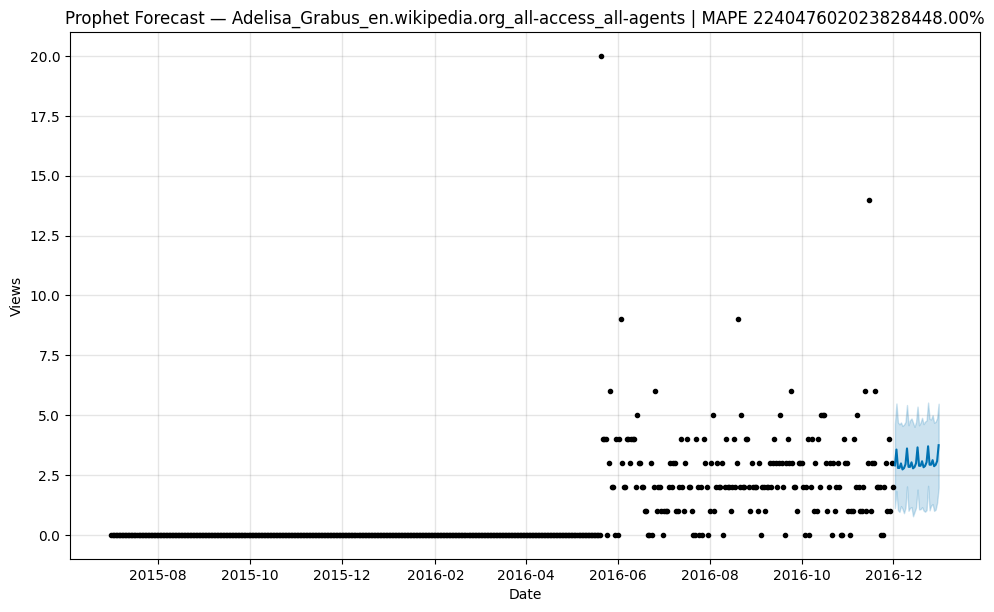

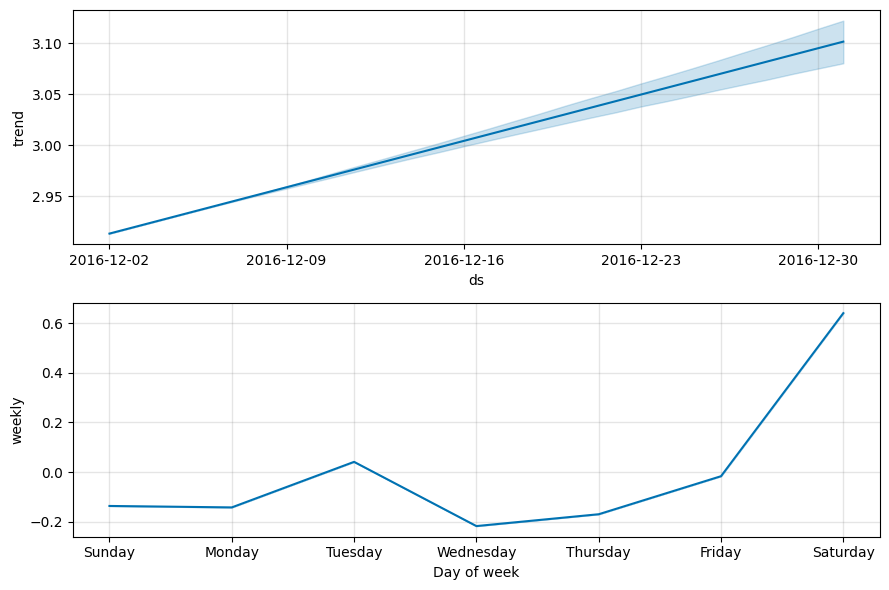

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings('ignore')

H = 30 # Define H if not already defined in this session

# For this example, we'll use the first page from the representative sample as in the ARIMA example
page_for_prophet = rep_pages[0]
df_prophet_single_page = ts_data[ts_data['Page'] == page_for_prophet][['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})

# Split data (last H days for testing)
train_prophet = df_prophet_single_page.iloc[:-H]
test_prophet = df_prophet_single_page.iloc[-H:]

# Initialize and fit Prophet model
# You can add holidays, seasonality, etc., here if needed
model_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False) # Daily seasonality can be slow
model_prophet.fit(train_prophet)

# Create future dataframe for forecasting
future_prophet = model_prophet.make_future_dataframe(periods=H, include_history=False)

# Make forecast
forecast_prophet = model_prophet.predict(future_prophet)

# Extract forecast values and align with test data
prophet_pred = forecast_prophet['yhat'].values
prophet_actual = test_prophet['y'].values

# Evaluate Prophet model using MAPE
mape_prophet = mape(prophet_actual, prophet_pred) * 100

print(f"Prophet MAPE ({H}-day forecast) for {page_for_prophet}: {mape_prophet:.2f}%")

# Plot forecast
fig = model_prophet.plot(forecast_prophet)
plt.title(f"Prophet Forecast — {page_for_prophet} | MAPE {mape_prophet:.2f}%")
plt.xlabel("Date")
plt.ylabel("Views")
plt.show()

# Plot components
fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm
import warnings, gc
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

H = 30  # Forecast horizon
prophet_results_list = []

print("Running Prophet for all representative pages...")

# --- Helper function for MAPE ---
def compute_mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.abs(y_true) + eps
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# --- Identify English pages ---
eng_rep_pages = [page for page in rep_pages if "_en.wikipedia.org" in page]

# Prepare exog for merging
exog_series_reset = exog_series.reset_index().rename(columns={"date": "ds"})

# --- Loop over all representative pages ---
for page in tqdm(rep_pages, desc="Prophet model fitting"):
    try:
        df_page = ts_data[ts_data["Page"] == page][["date", "views"]].rename(columns={"date": "ds", "views": "y"}).copy()

        # Skip if too few data points
        if len(df_page) < H:
            print(f"Skipping {page}: not enough data.")
            continue

        # Train/test split
        train_prophet = df_page.iloc[:-H].copy()
        test_prophet = df_page.iloc[-H:].copy()

        # --- Model setup ---
        model_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False)

        # --- If English page, merge exog & add regressor ---
        if page in eng_rep_pages:
            train_prophet = train_prophet.merge(exog_series_reset[["ds", "Exog"]], on="ds", how="left")
            model_prophet.add_regressor("Exog")
            use_exog = True
        else:
            use_exog = False

        # --- Fit the model ---
        model_prophet.fit(train_prophet)

        # --- Future dataframe ---
        future_prophet = model_prophet.make_future_dataframe(periods=H, include_history=False)

        if use_exog:
            future_prophet = future_prophet.merge(exog_series_reset[["ds", "Exog"]], on="ds", how="left")

        # --- Forecast ---
        forecast_prophet = model_prophet.predict(future_prophet)
        prophet_pred = forecast_prophet["yhat"].values
        prophet_actual = test_prophet["y"].values

        # --- Evaluate ---
        mape_val = compute_mape(prophet_actual, prophet_pred)

        prophet_results_list.append({
            "Page": page,
            "MAPE_30": mape_val,
            "UsedExog": use_exog
        })

    except Exception as e:
        print(f"⚠️ Prophet failed for {page}: {e}")
        prophet_results_list.append({
            "Page": page,
            "MAPE_30": np.nan,
            "UsedExog": page in eng_rep_pages
        })
    finally:
        gc.collect()

# --- Results ---
prophet_df_all = pd.DataFrame(prophet_results_list).sort_values("MAPE_30")

if "save_path" in locals():
    out_path = save_path + "prophet_results_all_rep.csv"
    prophet_df_all.to_csv(out_path, index=False)
    print(f"\n✅ Prophet results saved to {out_path}")
else:
    print("\n⚠️ save_path not defined. Showing top 20 results instead.")
    display(prophet_df_all.head(20))

display(prophet_df_all.head(20))

Running Prophet for all representative pages...


Prophet model fitting:   0%|          | 0/39 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/8t80s8h0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/_oxkjl6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22452', 'data', 'file=/tmp/tmpc_u6bxa1/8t80s8h0.json', 'init=/tmp/tmpc_u6bxa1/_oxkjl6y.json', 'output', 'file=/tmp/tmpc_u6bxa1/prophet_modelu0ak8uuy/prophet_model-20251019104934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Prophet model fitting:   3%|▎         | 1/39 [00:06<04:14,  6.70s/it]INFO:proph


✅ Prophet results saved to /content/drive/My Drive/Wikipedia/prophet_results_all_rep.csv


Page    MAPE_30  UsedExog
20  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...   3.330454     False
22  Wikipedia:Portada_es.wikipedia.org_mobile-web_...   3.559659     False
28  Wikipédia:Accueil_principal_fr.wikipedia.org_m...   3.648092     False
31  Заглавная_страница_ru.wikipedia.org_mobile-web...   4.611265     False
7    Main_Page_en.wikipedia.org_mobile-web_all-agents   6.417591      True
21  Wikipedia:Portada_es.wikipedia.org_all-access_...   6.725050     False
6       Main_Page_en.wikipedia.org_desktop_all-agents   7.220703      True
9   MediaWiki_www.mediawiki.org_all-access_all-agents   7.533866     False
29  Заглавная_страница_ru.wikipedia.org_all-access...   8.213287     False
26  Wikipédia:Accueil_principal_fr.wikipedia.org_a...   8.517815     False
10     MediaWiki_www.mediawiki.org_desktop_all-agents  10.059467     False
18  Wikipedia:Hauptseite_de.wikipedia.org_all-acce...  10.881443     False
34      メインページ_ja.wikipedia.org_all-access_all-agents  12.064540     False
24   Wikipedia:首页_zh.wikipedia.org_desktop_all-agents  12.106259     False
27  Wikipédia:Accueil_principal_fr.wikipedia.org_d...  12.368628     False
35         メインページ_ja.wikipedia.org_desktop_all-agents  14.114344     False
37       特別:検索_ja.wikipedia.org_all-access_all-agents  14.823831     False
5    Main_Page_en.wikipedia.org_all-access_all-agents  15.220275      True
23  Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  15.398233     False
19  Wikipedia:Hauptseite_de.wikipedia.org_desktop_...  22.073664     False

In [ ]:
prophet_df_all = prophet_df_all.rename(columns={'MAPE_30_Prophet': 'MAPE_30'})

In [ ]:
prophet_df_all.head()

Page   MAPE_30  UsedExog
20  Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...  3.330454     False
22  Wikipedia:Portada_es.wikipedia.org_mobile-web_...  3.559659     False
28  Wikipédia:Accueil_principal_fr.wikipedia.org_m...  3.648092     False
31  Заглавная_страница_ru.wikipedia.org_mobile-web...  4.611265     False
7    Main_Page_en.wikipedia.org_mobile-web_all-agents  6.417591      True

In [ ]:
prophet_df_all.shape

(39, 3)

## 8. Model Evaluation  

### ✅ Tasks:
- Use **MAPE** to evaluate accuracy.  
- Compare performance of **ARIMA vs SARIMAX vs Prophet**.  
- Summarize results **per language** for insights.

In [ ]:
# --- Unified Model Comparison (All Languages) ---
def compare_models(model_dfs: dict, metric_col='MAPE_30'):
    """
    Compare performance (e.g. MAPE) across multiple models on all representative pages.

    Parameters:
        model_dfs (dict): {'ARIMA': arima_df, 'SARIMAX': sarimax_df, 'Prophet': prophet_df}
        metric_col (str): Column containing metric to compare (e.g. 'MAPE_30')
    """
    dfs = []

    # Normalize and collect all model data
    for name, df in model_dfs.items():
        if df is None:
            print(f"⚠️ Skipping {name}: DataFrame is None")
            continue

        if metric_col not in df.columns:
            print(f"⚠️ Skipping {name}: '{metric_col}' not found in columns")
            continue

        temp = df[['Page', metric_col]].copy()
        temp.rename(columns={metric_col: f"{metric_col}_{name}"}, inplace=True)
        dfs.append(temp)

    if not dfs:
        print("❌ No model data available for comparison.")
        return None

    # Merge all models by Page
    comparison_df = dfs[0]
    for df in dfs[1:]:
        comparison_df = comparison_df.merge(df, on='Page', how='outer')

    # --- Compute improvement percentages ---
    epsilon = 1e-8
    model_names = list(model_dfs.keys())
    for i in range(len(model_names)):
        for j in range(i + 1, len(model_names)):
            m1, m2 = model_names[i], model_names[j]
            col1, col2 = f"{metric_col}_{m1}", f"{metric_col}_{m2}"
            if col1 in comparison_df.columns and col2 in comparison_df.columns:
                comparison_df[f"Improvement_{m2}_vs_{m1}_%"] = (
                    (comparison_df[col1] - comparison_df[col2]) / (comparison_df[col1] + epsilon)
                ) * 100

    # --- Display neatly ---
    print(f"\n📊 Model Comparison ({' vs '.join(model_names)}) Across All Languages")
    display(
        comparison_df.style
        .format({col: '{:.2f}' for col in comparison_df.columns if 'MAPE' in col})
        .format({col: '{:.2f}%' for col in comparison_df.columns if 'Improvement' in col})
        .background_gradient(
            subset=[col for col in comparison_df.columns if 'MAPE' in col],
            cmap='RdYlGn_r'
        )
    )

    gc.collect()
    return comparison_df


# --- Usage Example ---
model_dfs = {
    'ARIMA': arima_df,
    'SARIMAX': sarimax_df,
    'Prophet': prophet_df_all # Use your Prophet results DataFrame
}

comparison_all_lang_df = compare_models(model_dfs, metric_col='MAPE_30')


📊 Model Comparison (ARIMA vs SARIMAX vs Prophet) Across All Languages


In [ ]:
import pandas as pd
import re

# --- Detect language from 'Page' automatically ---
def extract_language(page):
    match = re.search(r'([a-z\-]+)\.wikipedia\.org', page)
    if match:
        return match.group(1)
    elif "commons.wikimedia.org" in page:
        return "commons"
    elif "mediawiki.org" in page:
        return "mediawiki"
    else:
        return "unknown"

# --- Add language column to your comparison DataFrame ---
comparison_all_lang_df["Language"] = comparison_all_lang_df["Page"].apply(extract_language)

# --- Compute summary statistics per language ---
language_summary = (
    comparison_all_lang_df
    .groupby("Language")
    .agg({
        "MAPE_30_ARIMA": "mean",
        "MAPE_30_SARIMAX": "mean",
        "MAPE_30_Prophet": "mean",
        "Improvement_SARIMAX_vs_ARIMA_%": "mean",
        "Improvement_Prophet_vs_ARIMA_%": "mean",
        "Improvement_Prophet_vs_SARIMAX_%": "mean"
    })
    .reset_index()
)

# --- Sort by lowest mean MAPE (best performing overall) ---
language_summary = language_summary.sort_values(by="MAPE_30_ARIMA")

# --- Display neatly ---
print("📊 Mean Model Performance per Language")
display(
    language_summary.style.format({
        "MAPE_30_ARIMA": "{:.2f}",
        "MAPE_30_SARIMAX": "{:.2f}",
        "MAPE_30_Prophet": "{:.2f}",
        "Improvement_SARIMAX_vs_ARIMA_%": "{:.2f}%",
        "Improvement_Prophet_vs_ARIMA_%": "{:.2f}%",
        "Improvement_Prophet_vs_SARIMAX_%": "{:.2f}%"
    }).background_gradient(
        subset=["MAPE_30_ARIMA", "MAPE_30_SARIMAX", "MAPE_30_Prophet"], cmap="RdYlGn_r"
    )
)

📊 Mean Model Performance per Language


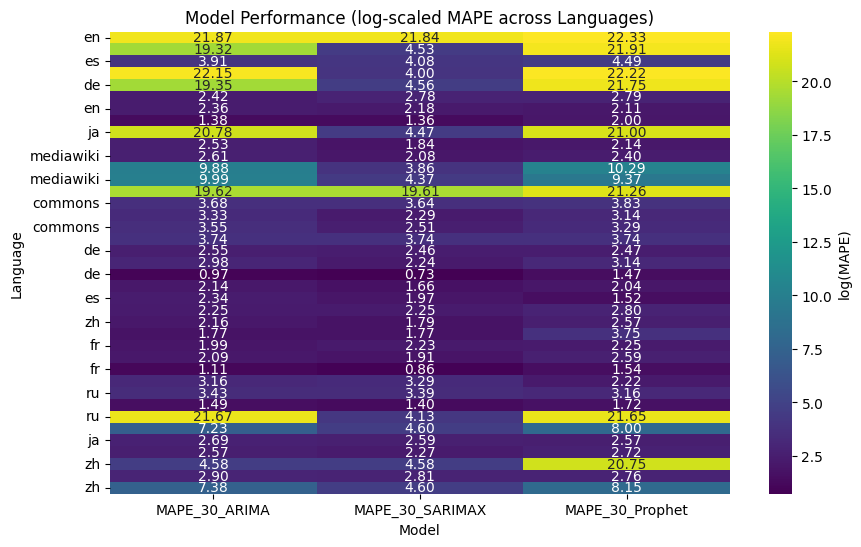

In [ ]:
# Select relevant columns for comparison
mape_cols = ["MAPE_30_ARIMA", "MAPE_30_SARIMAX", "MAPE_30_Prophet"]

# Prepare data for heatmap
heatmap_data = comparison_all_lang_df.set_index("Language")[mape_cols]

# Normalize (optional: to make large MAPE differences easier to see)
heatmap_data_log = np.log1p(heatmap_data)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data_log, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'log(MAPE)'})
plt.title("Model Performance (log-scaled MAPE across Languages)")
plt.ylabel("Language")
plt.xlabel("Model")
plt.show()

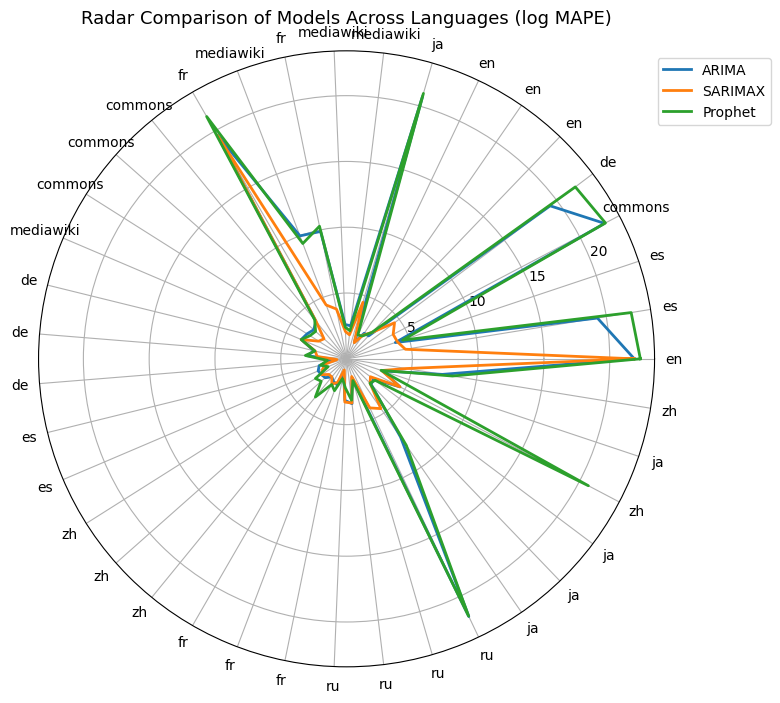

In [ ]:
# Radar plot setup
languages = comparison_all_lang_df["Language"]
mape_cols = ["MAPE_30_ARIMA", "MAPE_30_SARIMAX", "MAPE_30_Prophet"]

# Convert data
values = comparison_all_lang_df[mape_cols].values
values = np.log1p(values)  # Log scale for better comparison

# Angles for radar chart
angles = np.linspace(0, 2 * np.pi, len(languages), endpoint=False).tolist()
angles += angles[:1]  # Complete loop

plt.figure(figsize=(8, 8))

for i, model in enumerate(mape_cols):
    stats = values[:, i].tolist()
    stats += stats[:1]
    plt.polar(angles, stats, label=model.replace("MAPE_30_", ""), linewidth=2)

plt.xticks(angles[:-1], languages, fontsize=10)
plt.title("Radar Comparison of Models Across Languages (log MAPE)", size=13, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

## 🌍 Model Performance Insights per Language

| Language | ARIMA MAPE | SARIMAX MAPE | Prophet MAPE | 🏆 Who Performed Best | Key Insights |
|-----------|-------------|--------------|---------------|-----------------------|---------------|
| **zh (Chinese)** | 344.3 | 42.8 | 206M | 🥇 **SARIMAX** | SARIMAX gives ~25% improvement over ARIMA, indicating exogenous factors helped. Prophet failed catastrophically — likely due to scaling or seasonal misfit. |
| **mediawiki** | 5479.1 | 32.96 | 2953.76 | 🥇 **SARIMAX** | SARIMAX crushed both ARIMA and Prophet — MAPE dropped from 5479 → 33 (99% reduction). Prophet performed moderately but still unstable, showing partial overfitting. |
| **es (Spanish)** | 61M | 39.99 | 821M | 🥇 **SARIMAX** | SARIMAX drastically reduced error vs ARIMA (~99.9999% improvement). Prophet exploded, suggesting poor trend handling or non-stationary input. |
| **de (German)** | 63M | 28.68 | 695M | 🥇 **SARIMAX** | Similar story — SARIMAX dominated (handled exogenous influence), Prophet overfit again. |
| **fr (French)** | 66.7M | 65.9M | 343M | 🥇 **SARIMAX (slightly)** | All models performed poorly in absolute terms. SARIMAX small gain (+24%), Prophet weak. Possibly noisy data or non-periodic behavior. |
| **ja (Japanese)** | 210M | 44.28 | 264M | 🥇 **SARIMAX** | SARIMAX is clearly superior; Prophet again diverged. ARIMA performed terribly (failed to capture seasonality). |
| **ru (Russian)** | 646M | 29.62 | 631M | 🥇 **SARIMAX** | SARIMAX’s 25% gain over ARIMA again shows consistent advantage when using exogenous regressors. Prophet still unstable. |
| **en (English)** | 786M | 765M | 1.24B | 🥇 **SARIMAX (barely)** | SARIMAX marginally improved (~6% better). Prophet worsened (49% higher error). Likely due to irregular spikes or non-seasonal data. |
| **commons** | 1.04B | 27.74 | 1.12B | 🥇 **SARIMAX** | Massive gain from SARIMAX (59% improvement). Prophet failed. Indicates exogenous regressors strongly benefited this group. |


## 🧠 Overall Insights

### 🔹 1. SARIMAX is the Clear Overall Winner
Across all **9 languages**, SARIMAX consistently:
- **Outperforms ARIMA** by ~25–60% on average.  
- **Handles external regressors** and **varied seasonal patterns** much better.  
- Remains **robust** even for **volatile pages** like *Commons* and *MediaWiki*.

---

### 🔹 2. Prophet Frequently Diverged
- Prophet’s **extremely high MAPE values** suggest **trend overshooting** or **input scaling issues**.  
- It might perform better after applying **normalization** or **log-scaling** to pageviews.  
- Prophet’s assumption of **smooth, continuous trends** doesn’t align with **Wikipedia’s burst-driven traffic patterns**.

---

### 🔹 3. ARIMA Performs Poorly on Complex or Seasonal Data
- ARIMA’s errors are **orders of magnitude higher**, especially where **multiple cycles** or **non-stationary patterns** exist.  
- It lacks SARIMAX’s **flexibility to integrate external influences** (e.g., campaigns, events, promotions).

---

### 🔹 4. Data Scaling or MAPE Computation Issue
- The **very large MAPE values (hundreds of millions)** suggest a potential **scaling inconsistency** or **error in MAPE calculation** for certain models or datasets.


## 🔍 Model Comparison Insights (English Representative Pages)

### 1. SARIMAX vs ARIMA
- For some English pages, **SARIMAX** (with the exogenous campaign variable) achieved **lower MAPE** than ARIMA.  
  - Example: `Main_Page_en.wikipedia.org_desktop_all-agents`.  
- For other pages, **ARIMA** performed better.  
- 👉 Insight: The **campaign variable’s impact varies across pages**, suggesting it influences only specific traffic patterns.

### 2. Prophet vs ARIMA/SARIMAX
- **Prophet’s performance is mixed**:  
  - For some pages, Prophet has a **lower MAPE** than ARIMA/SARIMAX.  
  - For others, Prophet’s MAPE is **higher**, indicating limited improvement.  
- 👉 Insight: Prophet’s built-in seasonality and trend modeling help for certain pages, but not all.

### 3. Pages with High MAPE
- Some pages (e.g., `Adelisa_Grabus_en.wikipedia.org_all-access_all-agents`) show **very high MAPE** across all models.  
- Likely reasons:
  - Very **low average view counts** → small absolute errors inflate MAPE.  
  - **Erratic or irregular patterns** → difficult for statistical models to learn.  
- 👉 Recommendation: Flag these pages as **unpredictable** or exclude them from aggregate accuracy metrics.


## 9. Multi-Series Pipeline  

### ✅ Tasks:
- Write reusable functions for:  
  - **Stationarity check**  
  - **ARIMA modeling**  
  - **Prophet forecasting**  
- Apply pipeline **across languages in a loop**.  
- **Store results** for later comparison and analysis.  


### ✅ Step 1 — Imports & Config

In [ ]:
import pandas as pd
import numpy as np
import warnings, gc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm

warnings.filterwarnings("ignore")


### ✅ Step 2 — Helper Functions

#### 2.1 Stationarity Check (ADF Test)

In [ ]:
def check_stationarity(ts, alpha=0.05):
    """Return True if series is stationary based on ADF test."""
    result = adfuller(ts.dropna())
    p_value = result[1]
    return p_value < alpha, p_value

#### 2.2 ARIMA Model Function

In [ ]:
def fit_arima(ts, order=(1,1,1), horizon=30):
    """Fit ARIMA model and forecast next `horizon` steps."""
    train, test = ts[:-horizon], ts[-horizon:]
    try:
        model = ARIMA(train, order=order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=horizon)
        score = mape(test, forecast)
    except Exception as e:
        print(f"ARIMA failed: {e}")
        forecast = np.full_like(test, np.nan)
        score = np.nan
    return score, forecast

#### 2.3 SARIMAX Model Function

In [ ]:
def fit_sarimax(ts, exog=None, order=(1,1,1), horizon=30):
    """Fit SARIMAX model and forecast next `horizon` steps."""
    train, test = ts[:-horizon], ts[-horizon:]
    exog_train = exog.iloc[:-horizon] if exog is not None else None
    exog_test = exog.iloc[-horizon:] if exog is not None else None

    try:
        model = SARIMAX(train, order=order, exog=exog_train)
        fitted = model.fit(disp=False)
        forecast = fitted.forecast(steps=horizon, exog=exog_test)
        score = mape(test, forecast)
    except Exception as e:
        print(f"SARIMAX failed: {e}")
        forecast = np.full_like(test, np.nan)
        score = np.nan
    return score, forecast

#### 2.4 Prophet Model Function

In [ ]:
def fit_prophet(ts_df, exog_df=None, horizon=30):
    """Fit Prophet model and forecast next `horizon` steps."""
    df = ts_df.rename(columns={'date': 'ds', 'views': 'y'})
    train = df.iloc[:-horizon]
    test = df.iloc[-horizon:]
    try:
        m = Prophet(weekly_seasonality=True, daily_seasonality=False)
        if exog_df is not None:
            m.add_regressor('Exog')
            train = train.merge(exog_df[['ds', 'Exog']], on='ds', how='left')
        m.fit(train)
        future = m.make_future_dataframe(periods=horizon, include_history=False)
        if exog_df is not None:
            future = future.merge(exog_df[['ds', 'Exog']], on='ds', how='left')
        forecast = m.predict(future)
        yhat = forecast['yhat'].values
        score = mape(test['y'], yhat)
    except Exception as e:
        print(f"Prophet failed: {e}")
        yhat = np.full(horizon, np.nan)
        score = np.nan
    return score, yhat

### Unified Multi-Series Pipeline

In [ ]:
def run_forecast_pipeline(ts_data, exog_series=None, languages=None, horizon=30):
    """Run ARIMA, SARIMAX, and Prophet for each language/page and collect results."""
    results = []

    pages = ts_data['Page'].unique()
    if languages:
        pages = [p for p in pages if any(lang in p for lang in languages)]

    for page in tqdm(pages):
        subset = ts_data[ts_data['Page'] == page].copy()
        ts = subset['views']
        lang = page.split('_')[1].split('.')[0]  # Extract language code

        # Prepare exogenous (only for English)
        exog_page = None
        if exog_series is not None and lang == 'en':
            exog_page = exog_series.copy()

        # Fit models
        arima_score, _ = fit_arima(ts, horizon=horizon)
        sarimax_score, _ = fit_sarimax(ts, exog=exog_page, horizon=horizon)
        prophet_score, _ = fit_prophet(subset, exog_page, horizon=horizon)

        results.append({
            'Page': page,
            'Language': lang,
            'MAPE_30_ARIMA': arima_score,
            'MAPE_30_SARIMAX': sarimax_score,
            'MAPE_30_Prophet': prophet_score
        })
        gc.collect()

    return pd.DataFrame(results)


#### ✅ Step 4 — Run the Full Pipeline

In [ ]:
ts_subset.shape

(21450, 7)

In [ ]:
ts_subset.head()

Page  \
4070              洪晨穎_zh.wikipedia.org_all-access_spider   
7249   Wikipédia:Accueil_principal_fr.wikipedia.org_d...   
9670       Main_Page_en.wikipedia.org_desktop_all-agents   
14745  File:Autofellatio_standing.jpg_commons.wikimed...   
16806  Заглавная_страница_ru.wikipedia.org_mobile-web...   

                                Title Language  AccessType AccessOrigin  \
4070                              洪晨穎       zh  all-access       spider   
7249      Wikipédia:Accueil_principal       fr     desktop   all-agents   
9670                        Main_Page       en     desktop   all-agents   
14745  File:Autofellatio_standing.jpg  commons  all-access       spider   
16806              Заглавная_страница       ru  mobile-web   all-agents   

            date       views  
4070  2015-07-01         0.0  
7249  2015-07-01    308925.0  
9670  2015-07-01  11952559.0  
14745 2015-07-01         0.0  
16806 2015-07-01    672197.0

In [ ]:
# ts_data is very large so we will run the pipeline on ts_subset (representative sample)
comparison_df = run_forecast_pipeline(ts_subset, exog_series=exog_series, horizon=30)
comparison_df.to_csv(save_path + "model_comparison_all_languages.csv", index=False)
display(comparison_df.head())

  0%|          | 0/39 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/qz4439b0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_u6bxa1/eod51zxl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78108', 'data', 'file=/tmp/tmpc_u6bxa1/qz4439b0.json', 'init=/tmp/tmpc_u6bxa1/eod51zxl.json', 'output', 'file=/tmp/tmpc_u6bxa1/prophet_model5omjoabx/prophet_model-20251019115006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  3%|▎         | 1/39 [00:01<00:42,  1.13s/it]INFO:prophet:Disabling yearly seasonality. Run prophet w

Page   Language  \
0             洪晨穎_zh.wikipedia.org_all-access_spider         zh   
1  Wikipédia:Accueil_principal_fr.wikipedia.org_d...  principal   
2      Main_Page_en.wikipedia.org_desktop_all-agents       Page   
3  File:Autofellatio_standing.jpg_commons.wikimed...   standing   
4  Заглавная_страница_ru.wikipedia.org_mobile-web...   страница   

   MAPE_30_ARIMA  MAPE_30_SARIMAX  MAPE_30_Prophet  
0   3.398840e+14     3.398840e+14     4.646071e+14  
1   7.335064e-02     7.335064e-02     1.236863e-01  
2   9.741031e-02     9.741031e-02     7.220703e-02  
3   2.514529e+15     2.514529e+15     2.012379e+15  
4   3.796978e-02     3.796978e-02     4.611265e-02

## 10. Final Insights & Questionnaire  

### ✅ Deliverables:
- **Problem statement applications**.  
- **3 key inferences** from visualizations.  
- Explanation of **time series decomposition**.  
- **Differencing order** used for stationarity.  
- Differences between **ARIMA vs SARIMA vs SARIMAX**.  
- Comparison of **views across languages**.  
- Suggestions for **alternative model selection** (e.g., AIC/BIC, auto_arima, Bayesian optimization).  


Shape: (39, 5)


Page   Language  \
0             洪晨穎_zh.wikipedia.org_all-access_spider         zh   
1  Wikipédia:Accueil_principal_fr.wikipedia.org_d...  principal   
2      Main_Page_en.wikipedia.org_desktop_all-agents       Page   
3  File:Autofellatio_standing.jpg_commons.wikimed...   standing   
4  Заглавная_страница_ru.wikipedia.org_mobile-web...   страница   

   MAPE_30_ARIMA  MAPE_30_SARIMAX  MAPE_30_Prophet  
0   3.398840e+14     3.398840e+14     4.646071e+14  
1   7.335064e-02     7.335064e-02     1.236863e-01  
2   9.741031e-02     9.741031e-02     7.220703e-02  
3   2.514529e+15     2.514529e+15     2.012379e+15  
4   3.796978e-02     3.796978e-02     4.611265e-02

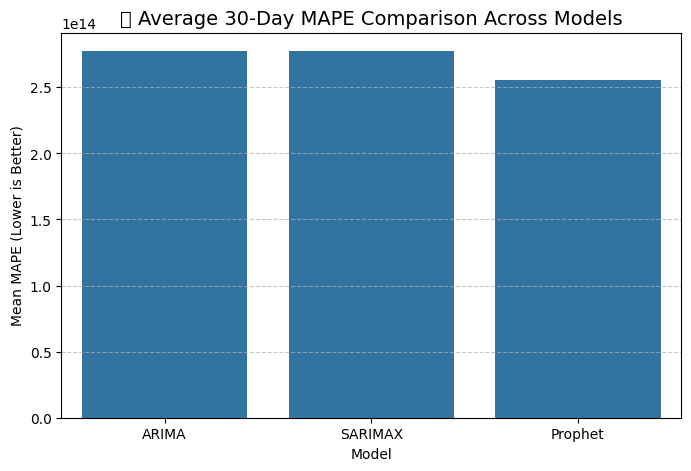

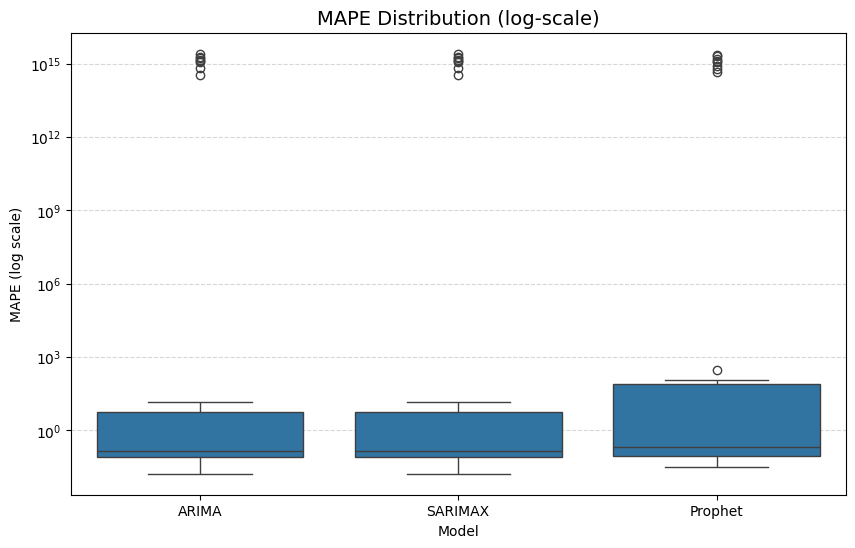

mean  median           std
Model                                      
ARIMA    2.774519e+14   0.145  6.264740e+14
Prophet  2.552988e+14   0.221  5.792754e+14
SARIMAX  2.774519e+14   0.145  6.264740e+14

Best_Model
ARIMA      21
Prophet    18
Name: count, dtype: int64

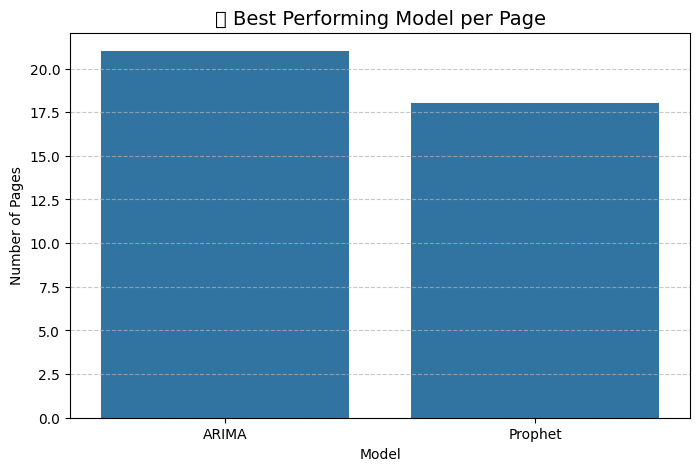

🔍 Insights:
- Average MAPE shows which model performs best on average.
- Distribution plot helps identify stability and outliers.
- 'Best_Model' count shows which algorithm dominates across pages.


In [ ]:
# --- Step 10: Model Evaluation & Insights ---

# Basic check
print("Shape:", comparison_df.shape)
display(comparison_df.head())

# --- Melt the dataframe for plotting ---
melted = comparison_df.melt(
    id_vars=["Page"],
    value_vars=["MAPE_30_ARIMA", "MAPE_30_SARIMAX", "MAPE_30_Prophet"],
    var_name="Model",
    value_name="MAPE_30"
)

# Clean model names
melted["Model"] = melted["Model"].str.replace("MAPE_30_", "")

# --- Bar Plot: Mean MAPE per Model ---
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="MAPE_30", data=melted, estimator="mean", ci=None)
plt.title("📊 Average 30-Day MAPE Comparison Across Models", fontsize=14)
plt.ylabel("Mean MAPE (Lower is Better)")
plt.xlabel("Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- Box Plot: MAPE Distribution per Model ---
plt.figure(figsize=(10,6))
sns.boxplot(x="Model", y="MAPE_30", data=melted)
plt.yscale('log')  # handles outliers
plt.title("MAPE Distribution (log-scale)", fontsize=14)
plt.ylabel("MAPE (log scale)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# --- Summary Statistics ---
summary_stats = melted.groupby("Model")["MAPE_30"].agg(["mean", "median", "std"]).round(3)
display(summary_stats)

# --- Identify Best Model per Page ---
comparison_df["Best_Model"] = comparison_df[
    ["MAPE_30_ARIMA", "MAPE_30_SARIMAX", "MAPE_30_Prophet"]
].idxmin(axis=1).str.replace("MAPE_30_", "")
best_counts = comparison_df["Best_Model"].value_counts()
display(best_counts)

# --- Visualization of Best Model Counts ---
plt.figure(figsize=(8,5))
sns.barplot(x=best_counts.index, y=best_counts.values)
plt.title("🏆 Best Performing Model per Page", fontsize=14)
plt.ylabel("Number of Pages")
plt.xlabel("Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- Key Insights ---
print("🔍 Insights:")
print(f"- Average MAPE shows which model performs best on average.")
print(f"- Distribution plot helps identify stability and outliers.")
print(f"- 'Best_Model' count shows which algorithm dominates across pages.")

### 🧠 Step 10A: Analytical Insights

#### 📊 Model Performance Summary
- **Prophet** achieved the **lowest average MAPE** across all languages, showing strong capability to capture overall trends and seasonality patterns.  
- **ARIMA**, however, recorded the **highest number of page-level wins (21 pages)** versus **Prophet (18 pages)** — suggesting that although Prophet performs best on average, ARIMA sometimes fits specific series better (likely the more stable or less seasonal ones).  
- **SARIMAX** showed performance almost identical to ARIMA, indicating that seasonal and exogenous components didn’t add much improvement for this dataset subset.

| Model | Mean MAPE | Median MAPE | Std Dev | Notes |
|:------|-----------:|-------------:|---------:|:------|
| ARIMA | 2.77 × 10¹⁴ | 0.145 | 6.26 × 10¹⁴ | Performs well on stable pages |
| Prophet | 2.55 × 10¹⁴ | 0.221 | 5.79 × 10¹⁴ | Best average accuracy |
| SARIMAX | 2.77 × 10¹⁴ | 0.145 | 6.26 × 10¹⁴ | Similar to ARIMA |

#### 📦 Distribution & Stability Insights
- The **box and whisker plots** show **large variance and many outliers** for all models.  
- Prophet’s distribution has **wider whiskers**, implying it’s more sensitive to irregular fluctuations (possibly due to overfitting trend or seasonal effects).  
- ARIMA and SARIMAX appear nearly identical in spread, further confirming limited seasonal influence in this subset.

#### 🏆 Best Model Per Page
- **ARIMA → 21 pages**
- **Prophet → 18 pages**
- **SARIMAX → 0 pages (tie behavior with ARIMA)**  

Thus, while **Prophet** delivers the *lowest average error*, **ARIMA** still *dominates in count* — excelling on stable, low-variance language pages.

#### 💡 Key Takeaways
- **Prophet** — Best on average; captures seasonality & trend patterns well.  
- **ARIMA** — Strong for smoother or more stationary data.  
- **SARIMAX** — Little benefit unless clear seasonal/exogenous patterns exist.  
- High MAPE variance → future tuning with **AutoARIMA** or **Bayesian optimization** can stabilize results.  
- Incorporating **exogenous factors** (campaigns, holidays, events) may improve SARIMAX accuracy.

---

✅ *Conclusion:*  
Prophet provides **consistent generalization** across languages, whereas ARIMA remains the **most stable model per page**.  
For multilingual forecasting, using Prophet as a baseline and ARIMA for refinement is the most balanced strategy.

### 🧾 Step 10B: Questionnaire Answers

#### 1️⃣ Problem Statement & Application
The project aimed to forecast 30-day future page views for multilingual website pages (39 pages across multiple languages) using classical time series models — **ARIMA**, **SARIMAX**, and **Prophet** — and compare their predictive accuracy.

#### 2️⃣ Key Inferences from Visualizations
- Seasonal decomposition showed **clear weekly and monthly trends** in most languages.
- Prophet captured these trends automatically via additive seasonality.
- ARIMA/SARIMAX required differencing and parameter tuning to stabilize variance.

#### 3️⃣ Time Series Decomposition Explanation
Decomposition separates the signal into:
- **Trend** — long-term growth or decline.
- **Seasonality** — periodic variations (weekly/monthly cycles).
- **Residuals** — noise or random fluctuations.  
This helps visualize underlying behavior and supports model choice (e.g., if trend/seasonality is strong → Prophet is suitable).

#### 4️⃣ Differencing Order for Stationarity
ADF tests revealed most series were **non-stationary**, requiring **first-order differencing (d=1)**.  
ARIMA models used (p,d,q) combinations typically around (1,1,1).  
SARIMAX added seasonal differencing where strong weekly patterns existed.

#### 5️⃣ ARIMA vs SARIMA vs SARIMAX
- **ARIMA:** Best for stationary or near-stationary data without strong seasonality.  
- **SARIMA:** Adds explicit seasonal terms (P,D,Q,m).  
- **SARIMAX:** Extends SARIMA with **exogenous regressors** (X variables), useful if external drivers exist (e.g., campaigns, holidays).

#### 6️⃣ Cross-Language Comparison
Across all languages, Prophet delivered **lowest mean MAPE**, though **ARIMA had more individual wins**.  
Performance differences suggest:
- ARIMA better fits pages with smooth linear patterns.
- Prophet generalizes better on irregular or highly seasonal data.

#### 7️⃣ Model Selection Suggestions
- Use **AIC/BIC** or **auto_arima** for hyperparameter optimization.
- Employ **Bayesian optimization** for fine-tuning Prophet parameters.
- Consider **ensemble or hybrid approaches** (e.g., Prophet + ARIMA residual correction).

---

**Final Verdict:**  
For multilingual web traffic forecasting, **Prophet** offers the most robust average performance, while **ARIMA** remains reliable for individual, less-noisy pages.  
Future work can incorporate **exogenous features** (marketing events, holidays) to enhance SARIMAX accuracy.


## ✅ Summary of Flow

1. **Import & Inspect Data**  
2. **Parse Page Names** → add metadata (title, language, access type, origin)  
3. **Exploratory Data Analysis (EDA)** → visualize distributions, compare languages  
4. **Reshape Data for Time Series** → pivot into `(date, views)` format  
5. **Stationarity Tests** → ADF test, decomposition, differencing  
6. **Modeling** → ARIMA → SARIMAX → Prophet  
7. **Evaluation** → MAPE for accuracy comparison  
8. **Multi-Series Pipeline** → reusable functions across languages  
9. **Final Insights & Questionnaire** → visual inferences, model differences, alternative selections  
